In [1]:
import numpy as np
from scipy import signal
import pandas as pd
import xarray as xr
import glob
from shapely.geometry import Polygon, LineString, Point, MultiPoint
import pickle

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap,Normalize
tab20 = cm.get_cmap('tab20',20)
tab9  = ListedColormap(tab20(np.linspace(0,8/19,9)))
mirror = LinearSegmentedColormap.from_list('mirror',np.vstack((plt.cm.cividis(np.linspace(0,1,128)),plt.cm.cividis_r(np.linspace(0,1,128)))))

%matplotlib inline
plt.rcParams['font.sans-serif'] = 'Arial' # Choose a nice font here
plt.rcParams['font.size'] = 7 # standard font size
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['mathtext.it'] = 'Arial'
plt.rcParams['figure.facecolor'] = 'white' # make sure background isn't transparent
plt.rcParams['figure.dpi'] = 150

# Constants and definitions

In [2]:
def get_impact_threshold(d,g,rho_f,rho_s,thresholdconstant): #bagnold 1941, p 86, eqn I
    return thresholdconstant*((rho_s-rho_f)/rho_f*g*d)**0.5

In [3]:
# rub' al khali
lonlims = [49.0-0.1,56.3-0.1]
latlims = [18.0-0.1,23.2-0.1]

# constants

d     = 300e-6
z     = 10
g     = 9.8
z0    = 1e-3
rho_s = 2650
rho_f = 1.2
kappa = 0.4
phi = 0.6

fluxconstant      = 5
thresholdconstant = 0.082

usimth = get_impact_threshold(d,g,rho_f,rho_s,thresholdconstant)

r = 6371.229*1e+3 #https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Spatialreferencesystems

In [4]:
dfverts=[[50.52815736, 18.46406547],
        [50.76809151, 18.49951671],
        [50.88279295, 18.48648637],
        [50.93161872, 18.37455539],
        [50.91664226, 18.31630878],
        [50.99694511, 18.31931122],
        [51.07876088, 18.41534758],
        [51.09301637, 18.51468053],
        [51.20432098, 18.58208886],
        [51.44002329, 18.61324037],
        [51.63563799, 18.64198234],
        [51.73127743, 18.62250047],
        [51.88200214, 18.62926307],
        [52.06123241, 18.65455065],
        [52.32841596, 18.70190271],
        [52.41009544, 18.74544072],
        [52.57139702, 18.71655723],
        [52.60252833, 18.65895232],
        [52.68918406, 18.67801159],
        [52.821054  , 18.67452564],
        [52.95172706, 18.64941551],
        [52.99391152, 18.51926534],
        [53.09024799, 18.49525753],
        [53.11707339, 18.45195882],
        [53.19732682, 18.42640817],
        [53.37570235, 18.42875643],
        [53.46373298, 18.47122871],
        [53.51574566, 18.49293376],
        [53.59144505, 18.52338321],
        [53.80638119, 18.67145884],
        [53.96442308, 18.74920205],
        [54.00046227, 18.82143981],
        [54.0467683 , 18.93281133],
        [54.13770064, 19.05373419],
        [54.19604263, 19.13363026],
        [54.23727649, 19.09450803],
        [54.25787276, 19.12057859],
        [54.41588108, 19.31898113],
        [54.5242389 , 19.44710742],
        [54.64824818, 19.53925769],
        [54.82072608, 19.60674499],
        [54.87589202, 19.56913016],
        [55.12528861, 19.7135664 ],
        [55.24156718, 19.80470999],
        [55.40502707, 19.84506991],
        [55.47019971, 19.72337413],
        [55.59349585, 19.79986346],
        [55.80245589, 19.97240868],
        [55.84651607, 20.08747637],
        [55.86801479, 20.26810201],
        [55.78989754, 20.37552557],
        [55.68791666, 20.41665126],
        [55.67513153, 20.53211979],
        [55.82856663, 20.69405777],
        [56.09325843, 20.76658003],
        [56.18494234, 20.86229568],
        [56.20418117, 20.9796403 ],
        [56.1269255 , 21.08131605],
        [56.04811994, 21.19200233],
        [55.9428198 , 21.26623922],
        [55.7647681 , 21.40943226],
        [55.64400056, 21.58371644],
        [55.48903245, 21.80825688],
        [55.43532666, 22.05952333],
        [55.38928625, 22.34993027],
        [55.32840464, 22.62295961],
        [55.22729697, 22.90142631],
        [55.07808791, 22.94229528],
        [54.9630966 , 22.93358437],
        [54.91318445, 22.80513326],
        [54.80552439, 22.7402138 ],
        [54.64740109, 22.75385627],
        [54.48454873, 22.82582428],
        [54.28525733, 22.92644977],
        [54.13862743, 23.01165366],
        [53.94989773, 23.10656844],
        [53.72976046, 23.11682675],
        [53.55030346, 23.06562733],
        [53.4380368 , 22.9769386 ],
        [53.45920572, 22.8618176 ],
        [53.53436195, 22.80190802],
        [53.59387321, 22.72559359],
        [53.61827252, 22.57916425],
        [53.685039  , 22.43226769],
        [53.6470913 , 22.33915233],
        [53.60876035, 22.10503822],
        [53.65627508, 21.90404738],
        [53.6560879 , 21.72177774],
        [53.55231308, 21.17814873],
        [53.48659065, 20.91994193],
        [53.45141579, 20.67573154],
        [53.38253023, 20.51722127],
        [53.3520789 , 20.3267098 ],
        [53.34481044, 20.21723698],
        [53.21215814, 20.10673068],
        [53.04413946, 20.00082051],
        [52.79181145, 19.7652275 ],
        [52.37938496, 19.42627677],
        [52.09339705, 19.24670552],
        [51.65018795, 19.07765693],
        [51.33240101, 19.01298624],
        [51.12993198, 18.94200714],
        [50.82280156, 18.88338642],
        [50.62806846, 18.82882316],
        [50.36793512, 18.75931586],
        [50.18610602, 18.69293169],
        [49.83211592, 18.50569423],
        [49.50598367, 18.38443099],
        [49.10219518, 18.12364326],
        [49.08304078, 18.04908759],
        [49.54300391, 18.17045819],
        [50.22051122, 18.34745439],
        [50.52815736, 18.46406547]]

dfpoly = Polygon(np.asarray(dfverts))

# Development

In [6]:
years  = np.arange(2001,2001+1)
months = np.arange(1,2+1)

i = 0
j = 0

era5  = xr.open_dataset(glob.glob('/g/data/zz93/era5-land/reanalysis/u10/%d/u10_era5-land_oper_sfc_%d%02d*.nc'%(years[i],years[i],months[j]))[0])
era5v = xr.open_dataset(glob.glob('/g/data/zz93/era5-land/reanalysis/v10/%d/v10_era5-land_oper_sfc_%d%02d*.nc'%(years[i],years[i],months[j]))[0])
era5  = era5.merge(era5v)            
era5  = era5.where((era5.longitude>lonlims[0])&(era5.longitude<=lonlims[1])&(era5.latitude>latlims[0])&(era5.latitude<=latlims[1]),drop=True)

dt = np.asarray((era5.time[1]-era5.time[0])/np.timedelta64(1, 's'))

In [35]:
directory = '/g/data/k10/ag5517/rubalkhali-topo/'
n = 0
with open(directory+'%d_analyzed.pkl'%n, 'rb') as f:
    (templongrid0,templatgrid0,thetas0,
    areafraction0,bedrockele0,equivalentthickness0,
    fulllengthfractiontheta0,lengthweightedslopetheta0,bedformlengththeta0) = pickle.load(f)
n = 1
with open(directory+'%d_analyzed.pkl'%n, 'rb') as f:
    (templongrid1,templatgrid1,thetas1,
    areafraction1,bedrockele1,equivalentthickness1,
    fulllengthfractiontheta1,lengthweightedslopetheta1,bedformlengththeta1) = pickle.load(f)
    
templongrid = np.hstack((templongrid0,templongrid1))
templatgrid = templatgrid0
thetas = thetas0
areafraction = np.hstack((areafraction0,areafraction1))
bedrockele = np.hstack((bedrockele0,bedrockele1))
equivalentthickness = np.hstack((equivalentthickness0,equivalentthickness1))
fulllengthfractiontheta = np.hstack((fulllengthfractiontheta0,fulllengthfractiontheta1))
lengthweightedslopetheta = np.hstack((lengthweightedslopetheta0,lengthweightedslopetheta1))
bedformlengththeta = np.hstack((bedformlengththeta0,bedformlengththeta1))

dlon = 0.1
dlat = 0.1

# convert the slope from eta/deg to eta/distance
r = 6371.229*1e+3
tlon = np.linspace(templongrid[0]-dlon/2,templongrid[-1]+dlon/2,len(templongrid)+1)
tlat = np.linspace(templatgrid[0]-dlat/2,templatgrid[-1]+dlat/2,len(templatgrid)+1)
Lon,Lat = np.meshgrid(tlon,tlat)
Ly = (r*np.diff(Lat*np.pi/180,axis=0))[:,1:]
Lx = (r*np.diff(Lon*np.pi/180,axis=1)*np.sin(np.pi/2-Lat[:,1:]*np.pi/180))[1:]
Ls = (Lx*Ly)**0.5
lengthweightedslopetheta = lengthweightedslopetheta*(dlon/Ls[:,:,np.newaxis])
fulllengththeta = fulllengthfractiontheta*Ls[:,:,np.newaxis]
bedrockele = bedrockele*equivalentthickness/equivalentthickness
bedformlengththeta = bedformlengththeta*(Ls[:,:,np.newaxis]/dlon)
beta = 1/np.nanmean(lengthweightedslopetheta)
mask = areafraction/areafraction

/local/k10/ag5517/tmp/ipykernel_2901266/1148961769.py:36: RuntimeWarning: invalid value encountered in multiply
  bedrockele = bedrockele*equivalentthickness/equivalentthickness


In [163]:
era5 = era5.assign(qm=(((era5.u10**2+era5.v10**2)*(kappa/np.log(z/z0))**2-usimth**2)*fluxconstant*usimth/g*rho_f).where(((era5.u10**2+era5.v10**2)**0.5*(kappa/np.log(z/z0)))>usimth,0))
era5 = era5.assign(qa=(np.arctan2(era5.v10,era5.u10)))

uav = np.flip(np.asarray(era5.mean(dim='time').u10),axis=1)
vav = np.flip(np.asarray(era5.mean(dim='time').v10),axis=1)

qa = np.flip(np.asarray(era5.qa),axis=1) #lat is backward in era5...
qm = np.flip(np.asarray(era5.qm),axis=1)*mask[np.newaxis,:,:]

# simple

detax = np.empty((len(era5.time),len(templatgrid),len(templongrid)-1))
detay = np.empty((len(era5.time),len(templatgrid)-1,len(templongrid)))
etax  = np.empty((len(era5.time),len(templatgrid),len(templongrid)-1))
etay  = np.empty((len(era5.time),len(templatgrid)-1,len(templongrid)))

qx = qm*np.cos(qa)
qy = qm*np.sin(qa)

In [164]:
i = 0
tempdirargs = np.argmin(np.abs(thetas[np.newaxis,np.newaxis,:]-qa[i,:,:,np.newaxis]),axis=2)
m,n = np.indices(tempdirargs.shape)
windfacingslope = lengthweightedslopetheta[m,n,tempdirargs]
winddirlengthfrac = fulllengthfractiontheta[m,n,tempdirargs]

qm_slope = qm[i]*winddirlengthfrac*(1+beta*windfacingslope)/2

(48.95, 56.25000000000004, 17.95, 25.25000000000004)

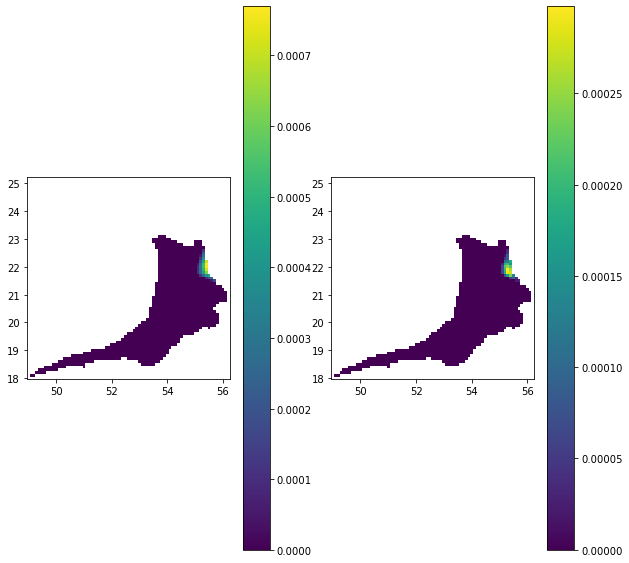

In [165]:
plt.subplot(121)
plt.pcolormesh(templongrid,templatgrid,qm[i])
plt.colorbar()
plt.axis('square')
plt.subplot(122)
plt.pcolormesh(templongrid,templatgrid,qm_slope)
plt.colorbar()
plt.axis('square')

In [166]:
dqdx = np.diff(qx/rho_s,axis=2)/Lx[np.newaxis,:,1:]
dqdy = np.diff(qy/rho_s,axis=1)/Ly[np.newaxis,1:,:]
dqdx = (dqdx[:,:,:-1]+np.diff(dqdx,axis=2)/2)[:,1:-1,:]
dqdy = (dqdy[:,:-1,:]+np.diff(dqdy,axis=1)/2)[:,:,1:-1]
deta = -(dqdx+dqdy)/phi*dt
detatot = np.cumsum(deta,axis=0)[-1]

(49.05, 56.150000000000034, 18.05, 25.150000000000038)

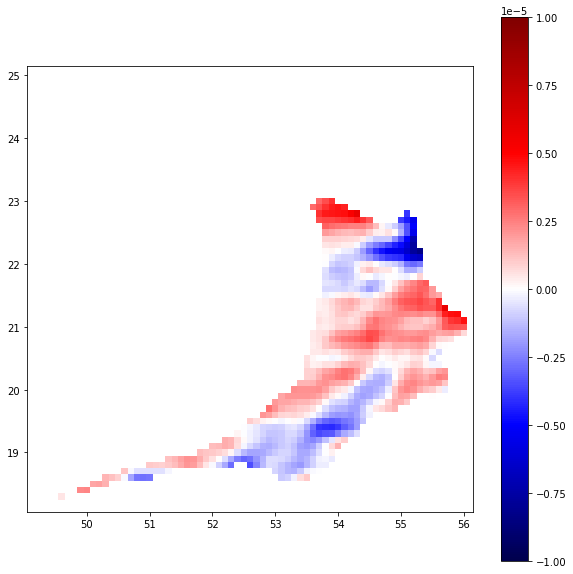

In [168]:
plt.pcolormesh(templongrid[1:-1],templatgrid[1:-1],detatot,vmin=-1e-5,vmax=1e-5,cmap='seismic')
plt.colorbar()
plt.axis('square')

# Generation

In [6]:
directory = '/g/data/k10/ag5517/rubalkhali-topo/'
n = 0
with open(directory+'%d_analyzed.pkl'%n, 'rb') as f:
    (templongrid0,templatgrid0,thetas0,
    areafraction0,bedrockele0,equivalentthickness0,
    fulllengthfractiontheta0,lengthweightedslopetheta0,bedformlengththeta0) = pickle.load(f)
n = 1
with open(directory+'%d_analyzed.pkl'%n, 'rb') as f:
    (templongrid1,templatgrid1,thetas1,
    areafraction1,bedrockele1,equivalentthickness1,
    fulllengthfractiontheta1,lengthweightedslopetheta1,bedformlengththeta1) = pickle.load(f)

templongrid = np.hstack((templongrid0,templongrid1))
templatgrid = templatgrid0
thetas = thetas0
areafraction = np.hstack((areafraction0,areafraction1))
bedrockele = np.hstack((bedrockele0,bedrockele1))
equivalentthickness = np.hstack((equivalentthickness0,equivalentthickness1))
fulllengthfractiontheta = np.hstack((fulllengthfractiontheta0,fulllengthfractiontheta1))
lengthweightedslopetheta = np.hstack((lengthweightedslopetheta0,lengthweightedslopetheta1))
bedformlengththeta = np.hstack((bedformlengththeta0,bedformlengththeta1))

dlon = 0.1
dlat = 0.1

# convert the slope from eta/deg to eta/distance
r = 6371.229*1e+3
tlon = np.linspace(templongrid[0]-dlon/2,templongrid[-1]+dlon/2,len(templongrid)+1)
tlat = np.linspace(templatgrid[0]-dlat/2,templatgrid[-1]+dlat/2,len(templatgrid)+1)
Lon,Lat = np.meshgrid(tlon,tlat)
Ly = (r*np.diff(Lat*np.pi/180,axis=0))[:,1:]
Lx = (r*np.diff(Lon*np.pi/180,axis=1)*np.sin(np.pi/2-Lat[:,1:]*np.pi/180))[1:]
Ls = (Lx*Ly)**0.5
lengthweightedslopetheta = lengthweightedslopetheta*(dlon/Ls[:,:,np.newaxis])
fulllengththeta = fulllengthfractiontheta*Ls[:,:,np.newaxis]
bedrockele = bedrockele*equivalentthickness/equivalentthickness
bedformlengththeta = bedformlengththeta*(Ls[:,:,np.newaxis]/dlon)
beta = 1/np.nanmean(lengthweightedslopetheta)
mask = areafraction/areafraction

/local/k10/ag5517/tmp/ipykernel_267629/271320876.py:36: RuntimeWarning: invalid value encountered in multiply
  bedrockele = bedrockele*equivalentthickness/equivalentthickness


In [7]:
years  = np.arange(1981,2020+1)
months = np.arange(1,12+1)

deta = np.empty((len(years),len(months),len(templatgrid)-2,len(templongrid)-2))
qnx  = np.empty((len(years),len(months),len(templatgrid),len(templongrid)))
qny  = np.empty((len(years),len(months),len(templatgrid),len(templongrid)))
qam  = np.empty((len(years),len(months),len(templatgrid),len(templongrid)))

uav = np.empty((len(years),len(months),len(templatgrid),len(templongrid)))
vav = np.empty((len(years),len(months),len(templatgrid),len(templongrid)))

deta_areas = np.empty((len(years),len(months),len(templatgrid)-2,len(templongrid)-2))
qnx_areas  = np.empty((len(years),len(months),len(templatgrid),len(templongrid)))
qny_areas  = np.empty((len(years),len(months),len(templatgrid),len(templongrid)))
qam_areas  = np.empty((len(years),len(months),len(templatgrid),len(templongrid)))

deta_slope = np.empty((len(years),len(months),len(templatgrid)-2,len(templongrid)-2))
qnx_slope  = np.empty((len(years),len(months),len(templatgrid),len(templongrid)))
qny_slope  = np.empty((len(years),len(months),len(templatgrid),len(templongrid)))
qam_slope  = np.empty((len(years),len(months),len(templatgrid),len(templongrid)))

for i in range(len(years)):
    for j in range(len(months)):
        era5  = xr.open_dataset(glob.glob('/g/data/zz93/era5-land/reanalysis/u10/%d/u10_era5-land_oper_sfc_%d%02d*.nc'%(years[i],years[i],months[j]))[0])
        era5v = xr.open_dataset(glob.glob('/g/data/zz93/era5-land/reanalysis/v10/%d/v10_era5-land_oper_sfc_%d%02d*.nc'%(years[i],years[i],months[j]))[0])
        era5  = era5.merge(era5v)            
        era5  = era5.where((era5.longitude>lonlims[0])&(era5.longitude<=lonlims[1])&(era5.latitude>latlims[0])&(era5.latitude<=latlims[1]),drop=True)
        
        era5 = era5.assign(qm=(((era5.u10**2+era5.v10**2)*(kappa/np.log(z/z0))**2-usimth**2)*fluxconstant*usimth/g*rho_f).where(((era5.u10**2+era5.v10**2)**0.5*(kappa/np.log(z/z0)))>usimth,0))
        era5 = era5.assign(qa=(np.arctan2(era5.v10,era5.u10)))
        
        if (i==0)&(j==0):
            dt = np.asarray((era5.time[1]-era5.time[0])/np.timedelta64(1, 's'))
        
        qa = np.flip(np.asarray(era5.qa),axis=1) #lat is backward in era5...
        qm = np.flip(np.asarray(era5.qm),axis=1)*mask[np.newaxis,:,:]
        
        uav[i,j] = np.mean(np.flip(np.asarray(era5.u10),axis=1),axis=0)
        vav[i,j] = np.mean(np.flip(np.asarray(era5.v10),axis=1),axis=0)
        
        # simple
        
        qx = qm*np.cos(qa)
        qy = qm*np.sin(qa)
        qnx[i,j] = np.sum(qx,axis=0)/len(era5.time)
        qny[i,j] = np.sum(qy,axis=0)/len(era5.time)
        qam[i,j] = np.mean(qm,axis=0)
        
        dqdx = np.diff(qx/rho_s,axis=2)/Lx[np.newaxis,:,1:]
        dqdy = np.diff(qy/rho_s,axis=1)/Ly[np.newaxis,1:,:]
        dqdx = (dqdx[:,:,:-1]+np.diff(dqdx,axis=2)/2)[:,1:-1,:]
        dqdy = (dqdy[:,:-1,:]+np.diff(dqdy,axis=1)/2)[:,:,1:-1]
        deta[i,j] = np.cumsum(-(dqdx+dqdy)/phi*dt,axis=0)[-1]
        
        # areas
        
        qm_areas = qm*areafraction
        qx = qm_areas*np.cos(qa)
        qy = qm_areas*np.sin(qa)
        qnx_areas[i,j] = np.sum(qx,axis=0)/len(era5.time)
        qny_areas[i,j] = np.sum(qy,axis=0)/len(era5.time)
        qam_areas[i,j] = np.mean(qm_areas,axis=0)
        
        dqdx = np.diff(qx/rho_s,axis=2)/Lx[np.newaxis,:,1:]
        dqdy = np.diff(qy/rho_s,axis=1)/Ly[np.newaxis,1:,:]
        dqdx = (dqdx[:,:,:-1]+np.diff(dqdx,axis=2)/2)[:,1:-1,:]
        dqdy = (dqdy[:,:-1,:]+np.diff(dqdy,axis=1)/2)[:,:,1:-1]
        deta_areas[i,j] = np.cumsum(-(dqdx+dqdy)/phi*dt,axis=0)[-1]
        
        # slopes
        
        tempdirargs = np.argmin(np.abs(thetas[np.newaxis,np.newaxis,np.newaxis,:]-qa[:,:,:,np.newaxis]),axis=3)
        l,m,n = np.indices(tempdirargs.shape)

        tempslopes = np.repeat(lengthweightedslopetheta[np.newaxis,:,:,:], len(era5.time), axis=0)
        windfacingslope = tempslopes[l,m,n,tempdirargs]
        
        templengthfrac = np.repeat(fulllengthfractiontheta[np.newaxis,:,:,:], len(era5.time), axis=0)
        winddirlengthfrac = templengthfrac[l,m,n,tempdirargs]
        
        qm_slope = qm*winddirlengthfrac*(1+beta*windfacingslope)/2
        qx = qm_slope*np.cos(qa)
        qy = qm_slope*np.sin(qa)
        qnx_slope[i,j] = np.sum(qx,axis=0)/len(era5.time)
        qny_slope[i,j] = np.sum(qy,axis=0)/len(era5.time)
        qam_slope[i,j] = np.mean(qm_slope,axis=0)
        
        dqdx = np.diff(qx/rho_s,axis=2)/Lx[np.newaxis,:,1:]
        dqdy = np.diff(qy/rho_s,axis=1)/Ly[np.newaxis,1:,:]
        dqdx = (dqdx[:,:,:-1]+np.diff(dqdx,axis=2)/2)[:,1:-1,:]
        dqdy = (dqdy[:,:-1,:]+np.diff(dqdy,axis=1)/2)[:,:,1:-1]
        deta_slope[i,j] = np.cumsum(-(dqdx+dqdy)/phi*dt,axis=0)[-1]    
        
        print('year %d, month %d'%(years[i],months[j]),end='\r')
        
with open(directory+'era5land-RAK.pkl', 'wb') as f:
    pickle.dump((years,months,dt,templongrid,templatgrid,
                 uav,vav,
                 deta,qnx,qny,qam,
                 deta_areas,qnx_areas,qny_areas,qam_areas,
                 deta_slope,qnx_slope,qny_slope,qam_slope), f)

# Load

In [5]:
directory = '/g/data/k10/ag5517/rubalkhali-topo/'

with open(directory+'basemap.pkl', 'rb') as f:
    (templongrid,templatgrid,basemap) = pickle.load(f)

n = 0
with open(directory+'%d_analyzed.pkl'%n, 'rb') as f:
    (templongrid0,templatgrid0,thetas0,
    areafraction0,bedrockele0,equivalentthickness0,
    fulllengthfractiontheta0,lengthweightedslopetheta0,bedformlengththeta0) = pickle.load(f)
n = 1
with open(directory+'%d_analyzed.pkl'%n, 'rb') as f:
    (templongrid1,templatgrid1,thetas1,
    areafraction1,bedrockele1,equivalentthickness1,
    fulllengthfractiontheta1,lengthweightedslopetheta1,bedformlengththeta1) = pickle.load(f)
    
templongrid = np.hstack((templongrid0,templongrid1))
templatgrid = templatgrid0
thetas = thetas0
areafraction = np.hstack((areafraction0,areafraction1))
bedrockele = np.hstack((bedrockele0,bedrockele1))
equivalentthickness = np.hstack((equivalentthickness0,equivalentthickness1))
fulllengthfractiontheta = np.hstack((fulllengthfractiontheta0,fulllengthfractiontheta1))
lengthweightedslopetheta = np.hstack((lengthweightedslopetheta0,lengthweightedslopetheta1))
bedformlengththeta = np.hstack((bedformlengththeta0,bedformlengththeta1))

dlon = 0.1
dlat = 0.1

# convert the slope from eta/deg to eta/distance
r = 6371.229*1e+3
tlon = np.linspace(templongrid[0]-dlon/2,templongrid[-1]+dlon/2,len(templongrid)+1)
tlat = np.linspace(templatgrid[0]-dlat/2,templatgrid[-1]+dlat/2,len(templatgrid)+1)
Lon,Lat = np.meshgrid(tlon,tlat)
Ly = (r*np.diff(Lat*np.pi/180,axis=0))[:,1:]
Lx = (r*np.diff(Lon*np.pi/180,axis=1)*np.sin(np.pi/2-Lat[:,1:]*np.pi/180))[1:]
Ls = (Lx*Ly)**0.5
lengthweightedslopetheta = lengthweightedslopetheta*(dlon/Ls[:,:,np.newaxis])
fulllengththeta = fulllengthfractiontheta*Ls[:,:,np.newaxis]
bedrockele = bedrockele*equivalentthickness/equivalentthickness
bedformlengththeta = bedformlengththeta*(Ls[:,:,np.newaxis]/dlon)
beta = 1/np.nanmean(lengthweightedslopetheta)
mask = areafraction/areafraction

/local/k10/ag5517/tmp/ipykernel_311910/1870988452.py:40: RuntimeWarning: invalid value encountered in multiply
  bedrockele = bedrockele*equivalentthickness/equivalentthickness


In [6]:
with open(directory+'era5land-RAK.pkl', 'rb') as f:
    (years,months,dt,templongrid,templatgrid,
     uav,vav,
     deta,qnx,qny,qam,
     deta_areas,qnx_areas,qny_areas,qam_areas,
     deta_slope,qnx_slope,qny_slope,qam_slope) = pickle.load(f)

In [7]:
lonOI = 54.0
latOI = 22.7
with open(directory+'era5land-qm-%.1flon%.1flat.pkl'%(lonOI,latOI), 'rb') as f:
    qm_store = pickle.load(f)
qm_store = np.ndarray.flatten(qm_store)

# Analysis

In [8]:
basemap_dfmin = np.nanmin(basemap*areafraction/areafraction)

In [9]:
tempdt = (60*60*24*365/12)
mps_to_mmpyr = 1e+3*(60*60*24*365)
s_to_ma = 1e-6/(60*60*24*365)

# detadt is in m/s

detadt     = deta/tempdt
detaflat   = np.reshape(deta,[len(years)*len(months),len(templatgrid)-2,len(templongrid)-2])
detadtflat = detaflat/tempdt
etaflat    = np.cumsum(detaflat,axis=0)
eta        = np.reshape(etaflat,[len(years),len(months),len(templatgrid)-2,len(templongrid)-2])

detadt_areas     = deta_areas/tempdt
detaflat_areas   = np.reshape(deta_areas,[len(years)*len(months),len(templatgrid)-2,len(templongrid)-2])
detadtflat_areas = detaflat_areas/tempdt
etaflat_areas    = np.cumsum(detaflat_areas,axis=0)
eta_areas        = np.reshape(etaflat_areas,[len(years),len(months),len(templatgrid)-2,len(templongrid)-2])

detadt_slope     = deta_slope/tempdt
detaflat_slope   = np.reshape(deta_slope,[len(years)*len(months),len(templatgrid)-2,len(templongrid)-2])
detadtflat_slope = detaflat_slope/tempdt
etaflat_slope    = np.cumsum(detaflat_slope,axis=0)
eta_slope        = np.reshape(etaflat_slope,[len(years),len(months),len(templatgrid)-2,len(templongrid)-2])

In [10]:
qnxtot = np.sum(qnx,axis=(0,1))/(len(years)*len(months))
qnytot = np.sum(qny,axis=(0,1))/(len(years)*len(months))
qnmtot = (qnxtot**2+qnytot**2)**0.5
qnatot = np.arctan2(qnytot,qnxtot)
qamtot = np.mean(qam,axis=(0,1))
qd = qnmtot/qamtot

qnxtot_areas = np.sum(qnx_areas,axis=(0,1))/(len(years)*len(months))
qnytot_areas = np.sum(qny_areas,axis=(0,1))/(len(years)*len(months))
qnmtot_areas = (qnxtot_areas**2+qnytot_areas**2)**0.5
qnatot_areas = np.arctan2(qnytot_areas,qnxtot_areas)
qamtot_areas = np.mean(qam_areas,axis=(0,1))
qd_areas = qnmtot_areas/qamtot_areas

qnxtot_slope = np.sum(qnx_slope,axis=(0,1))/(len(years)*len(months))
qnytot_slope = np.sum(qny_slope,axis=(0,1))/(len(years)*len(months))
qnmtot_slope = (qnxtot_slope**2+qnytot_slope**2)**0.5
qnatot_slope = np.arctan2(qnytot_slope,qnxtot_slope)
qamtot_slope = np.mean(qam_slope,axis=(0,1))
qd_slope = qnmtot_slope/qamtot_slope

In [11]:
qnxflat_slope = np.reshape(qnx_slope,[len(years)*len(months),len(templatgrid),len(templongrid)])
qnyflat_slope = np.reshape(qny_slope,[len(years)*len(months),len(templatgrid),len(templongrid)])

In [12]:
subthetas  = thetas[18:27]
st1,st2    = np.meshgrid(subthetas,subthetas)
diffst     = np.abs(st1-st2)
temp1      = np.concatenate((diffst,np.pi/2-diffst),axis=1)
temp2      = np.concatenate((np.pi/2-diffst,diffst),axis=1)
temp3      = np.concatenate((temp1,temp2))
sub90diffa = np.tile(temp3,(2,2))

subthetas   = thetas[18:]
st1,st2     = np.meshgrid(subthetas,subthetas)
diffst      = np.abs(st1-st2)
temp1       = np.concatenate((diffst,np.pi-diffst),axis=1)
temp2       = np.concatenate((np.pi-diffst,diffst),axis=1)
sub180diffa = np.concatenate((temp1,temp2))

###

thetasteepest = np.zeros_like(equivalentthickness)
thetashallowest = np.zeros_like(equivalentthickness)
thetashortest = np.zeros_like(equivalentthickness)
thetalongest  = np.zeros_like(equivalentthickness)
qnatotbinned_slope = np.zeros_like(equivalentthickness)
bedformlength_qnatotdir_slope = np.zeros_like(equivalentthickness)
lengthweightedslope_qnatotdir_slope = np.zeros_like(equivalentthickness)

sub90diffa_steepest_qnatotdir_slope  = np.zeros_like(equivalentthickness)
sub180diffa_shallowest_qnatotdir_slope = np.zeros_like(equivalentthickness)
sub90diffa_shallowest_qnatotdir_slope  = np.zeros_like(equivalentthickness)
sub180diffa_steepest_qnatotdir_slope = np.zeros_like(equivalentthickness)
sub90diffa_shortest_qnatotdir_slope  = np.zeros_like(equivalentthickness)
sub180diffa_shortest_qnatotdir_slope = np.zeros_like(equivalentthickness)
sub90diffa_longest_qnatotdir_slope   = np.zeros_like(equivalentthickness)
sub180diffa_longest_qnatotdir_slope  = np.zeros_like(equivalentthickness)

thetasteepestargs = np.argmax(lengthweightedslopetheta,axis=2)
thetashallowestargs = np.argmin(lengthweightedslopetheta,axis=2)
thetashortestargs = np.argmin(bedformlengththeta,axis=2)
thetalongestargs  = np.argmax(bedformlengththeta,axis=2)
for i in range(len(templongrid)):
    for j in range(len(templatgrid)):
        thetasteepest[j,i] = thetas[thetasteepestargs[j,i]]
        thetashallowest[j,i] = thetas[thetasteepestargs[j,i]]
        thetashortest[j,i] = thetas[thetashortestargs[j,i]]
        thetalongest[j,i]  = thetas[thetalongestargs[j,i]]
        
        qnatotbinned_slope[j,i] = thetas[np.argmin(np.abs(qnatot_slope[j,i]-thetas))]
        bedformlength_qnatotdir_slope[j,i] = bedformlengththeta[j,i,np.argmin(np.abs(qnatot_slope[j,i]-thetas))]
        lengthweightedslope_qnatotdir_slope[j,i] = lengthweightedslopetheta[j,i,np.argmin(np.abs(qnatot_slope[j,i]-thetas))]
        
        sub90diffa_steepest_qnatotdir_slope[j,i]  = sub90diffa[thetasteepestargs[j,i],np.argmin(np.abs(qnatot_slope[j,i]-thetas))]
        sub180diffa_steepest_qnatotdir_slope[j,i] = sub180diffa[thetasteepestargs[j,i],np.argmin(np.abs(qnatot_slope[j,i]-thetas))]
        sub90diffa_shallowest_qnatotdir_slope[j,i]  = sub90diffa[thetashallowestargs[j,i],np.argmin(np.abs(qnatot_slope[j,i]-thetas))]
        sub180diffa_shallowest_qnatotdir_slope[j,i] = sub180diffa[thetashallowestargs[j,i],np.argmin(np.abs(qnatot_slope[j,i]-thetas))]
        sub90diffa_shortest_qnatotdir_slope[j,i]  = sub90diffa[thetashortestargs[j,i],np.argmin(np.abs(qnatot_slope[j,i]-thetas))]
        sub180diffa_shortest_qnatotdir_slope[j,i] = sub180diffa[thetashortestargs[j,i],np.argmin(np.abs(qnatot_slope[j,i]-thetas))]
        sub90diffa_longest_qnatotdir_slope[j,i]   = sub90diffa[thetalongestargs[j,i],np.argmin(np.abs(qnatot_slope[j,i]-thetas))]
        sub180diffa_longest_qnatotdir_slope[j,i]  = sub180diffa[thetalongestargs[j,i],np.argmin(np.abs(qnatot_slope[j,i]-thetas))]
        
thetasteepest = thetasteepest*areafraction/areafraction
thetashallowest = thetashallowest*areafraction/areafraction
thetashortest = thetashortest*areafraction/areafraction
thetalongest  = thetalongest*areafraction/areafraction

qnatotbinned_slope = qnatotbinned_slope*areafraction/areafraction
bedformlength_qnatotdir_slope = bedformlength_qnatotdir_slope*areafraction/areafraction
lengthweightedslope_qnatotdir_slope = lengthweightedslope_qnatotdir_slope*areafraction/areafraction

sub90diffa_steepest_qnatotdir_slope  = sub90diffa_steepest_qnatotdir_slope*areafraction/areafraction
sub180diffa_steepest_qnatotdir_slope = sub180diffa_steepest_qnatotdir_slope*areafraction/areafraction
sub90diffa_shallowest_qnatotdir_slope  = sub90diffa_shallowest_qnatotdir_slope*areafraction/areafraction
sub180diffa_shallowest_qnatotdir_slope = sub180diffa_shallowest_qnatotdir_slope*areafraction/areafraction
sub90diffa_shortest_qnatotdir_slope  = sub90diffa_shortest_qnatotdir_slope*areafraction/areafraction
sub180diffa_shortest_qnatotdir_slope = sub180diffa_shortest_qnatotdir_slope*areafraction/areafraction
sub90diffa_longest_qnatotdir_slope   = sub90diffa_longest_qnatotdir_slope*areafraction/areafraction
sub180diffa_longest_qnatotdir_slope  = sub180diffa_longest_qnatotdir_slope*areafraction/areafraction

In [13]:
migrationspeed = qnmtot*areafraction/phi/rho_s/equivalentthickness
migrationspeed_areas = qnmtot_areas*areafraction/phi/rho_s/equivalentthickness
migrationspeed_slope = qnmtot_slope*areafraction/phi/rho_s/equivalentthickness

In [14]:
Tz_slope = equivalentthickness[1:-1,1:-1]/np.mean(detadtflat_slope,axis=0)
Tx_slope = bedformlength_qnatotdir_slope/migrationspeed_slope
M_slope  = Tz_slope/Tx_slope[1:-1,1:-1]

In [15]:
yr_to_s = 60*60*24*365
Lyr_slope = (qamtot_slope/rho_s/phi*yr_to_s/np.mean(lengthweightedslopetheta,axis=2))**0.5

In [16]:
crossbedwidth_slope = migrationspeed_slope*yr_to_s
setthickness_slope = np.mean(detadt_slope,axis=(0,1))/migrationspeed_slope[1:-1,1:-1]*bedformlength_qnatotdir_slope[1:-1,1:-1]
setangle_slope = np.arctan(np.mean(detadt_slope,axis=(0,1))/migrationspeed_slope[1:-1,1:-1])

In [17]:
temp = pd.read_csv(directory+'manual-morphology.csv')
temp = np.flipud(np.asarray(temp.iloc[1:,1:-1]))

b  = np.empty_like(areafraction)*np.nan
ob = np.empty_like(areafraction)*np.nan
s  = np.empty_like(areafraction)*np.nan
os = np.empty_like(areafraction)*np.nan
d  = np.empty_like(areafraction)*np.nan
od = np.empty_like(areafraction)*np.nan
t  = np.empty_like(areafraction)*np.nan
td = np.empty_like(areafraction)*np.nan
bs = np.empty_like(areafraction)*np.nan

morph = np.empty_like(areafraction)*np.nan
morphlist = ['Barchan','Oblique\nBarchan','Star','Oblique\nStar','Dome','Oblique\nDome','Transverse','Transverse\nDome','Barchan\nStar']
morphlist_abv = ['B','OB','S','OS','D','OD','T','TD','BS']

oblinds      = [1,3,5]
bsind        = 8
uniinds      = [0,6]
bedmorphinds = [0,1,4,5,6,7]

for i in range(len(templatgrid)):
    for j in range(len(templongrid)):
        if temp[i,j]=='b':
            b[i,j]=1
            morph[i,j]=0
        elif temp[i,j]=='ob':
            ob[i,j]=1
            morph[i,j]=1
        elif temp[i,j]=='s':
            s[i,j]=1
            morph[i,j]=2
        elif temp[i,j]=='os':
            os[i,j]=1
            morph[i,j]=3
        elif temp[i,j]=='d':
            d[i,j]=1
            morph[i,j]=4
        elif temp[i,j]=='od':
            od[i,j]=1
            morph[i,j]=5
        elif temp[i,j]=='t':
            t[i,j]=1
            morph[i,j]=6
        elif temp[i,j]=='td':
            td[i,j]=1
            morph[i,j]=7
        elif temp[i,j]=='bs':
            bs[i,j]=1
            morph[i,j]=8

In [18]:
qm_store_padded = np.concatenate((qm_store,np.zeros(len(qm_store)-1)))
tempS = np.conj(np.fft.fft(qm_store_padded))*np.fft.fft(qm_store_padded)
qm_store_autocorr = np.fft.ifft(tempS)
qm_store_autocorr = qm_store_autocorr[:(qm_store_autocorr.size//2)+1]
qm_store_time = np.arange(len(qm_store_autocorr))*60*60

In [19]:
liwa40alon = 53+32/60+32/60/60
liwa40alat = 22+55/60+22/60/60

liwa40alonind = np.argmin(np.abs(templongrid-liwa40alon))
liwa40alatind = np.argmin(np.abs(templatgrid-liwa40alat))

liwa40aheight = equivalentthickness[liwa40alatind,liwa40alonind]/areafraction[liwa40alatind,liwa40alonind]

In [20]:
# liwa40adetadt_slope = np.mean(detadtflat_slope,axis=0)[liwa40alatind-1,liwa40alonind-1] #should be but nan
liwa40adetadt_slope = np.mean(detadtflat_slope,axis=0)[liwa40alatind-1,liwa40alonind] #move one grid spot right so not nan
print(liwa40adetadt_slope)
liwa40amigrationspeed_slope = migrationspeed_slope[liwa40alatind,liwa40alonind]
print(liwa40amigrationspeed_slope)

5.553289336169302e-13
5.974048049891217e-09


In [21]:
slipfaceangle = 30*np.pi/180
liwa40amigrationspeed_slope*np.tan(slipfaceangle)

liwa40amigrationspeed_slope*np.tan(slipfaceangle)/3e-10

11.497060832521509

In [22]:
# tempdetadt = np.nanmean(detadt_slope[detadt_slope>0])
# tempc = np.nanmean(migrationspeed_slope)
# templ = np.nanmean(bedformlength_qnatotdir_slope)
# tempt = yr_to_s

tempdetadt = 3e-2
tempc = tempdetadt*10
templ = 10
tempt = 1

tempeps = tempc*tempt
tempdel = tempdetadt*templ/tempc

epsangle = -30*np.pi/180
delangle = np.arctan(tempdetadt/tempc)

nsets = 10
nbeds = 40

nx = 1000
tempx = np.linspace(-nbeds*tempeps,nbeds*tempeps,nx)

tempsets = np.empty((nsets,len(tempx)))
for i in range(nsets):
    tempsets[i] = tempx*np.tan(delangle)+tempdel*i

tempbedsx = np.empty((nsets,nbeds,len(tempx)))
tempbedsy = np.empty((nsets,nbeds,len(tempx)))
for i in range(nsets):
    for j in range(nbeds):
        tempbedsx[i,j] = tempx+tempeps*j
        tempbedsy[i,j] = tempx*np.tan(epsangle)+tempdel*i
        tempbedsx[i,j][tempbedsx[i,j]>(tempbedsy[i,j]-tempdel*(i-1))/np.tan(delangle)] = np.nan
        tempbedsx[i,j][tempbedsx[i,j]<(tempbedsy[i,j]-tempdel*(i))/np.tan(delangle)] = np.nan

# Plots

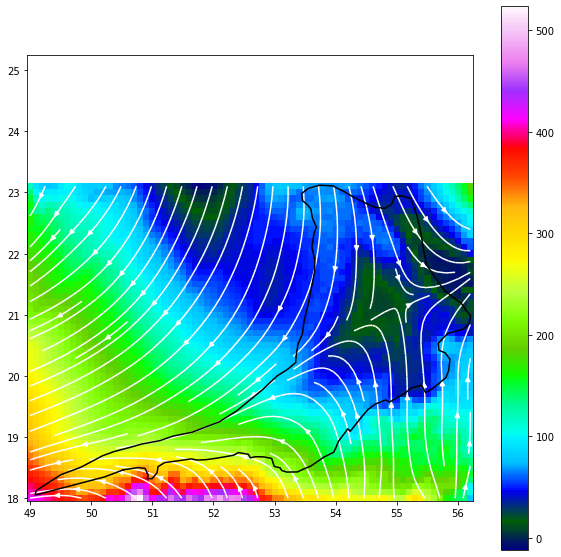

In [141]:
plt.pcolormesh(templongrid,templatgrid,basemap-basemap_dfmin,cmap='gist_ncar')
plt.colorbar()
plt.streamplot(templongrid,templatgrid,np.mean(uav,axis=(0,1)),np.mean(vav,axis=(0,1)),color='w')
plt.axis('square')
plt.plot(*dfpoly.exterior.xy,c='k')

(49.05, 56.150000000000034, 18.05, 25.150000000000038)

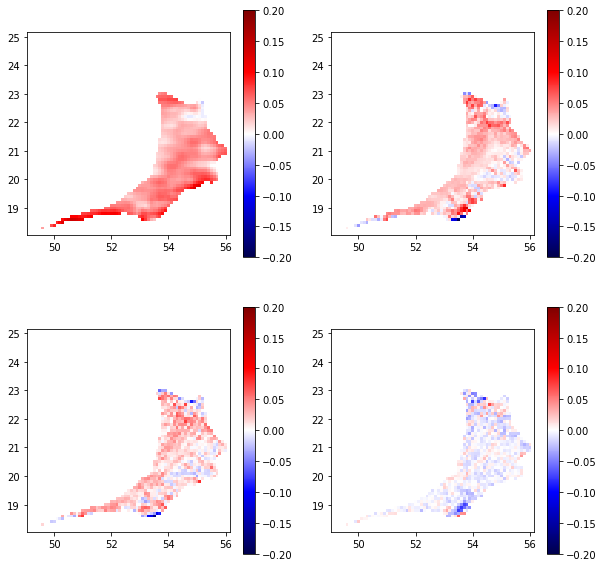

In [20]:
vabs = 2e-1

plt.subplot(221)
plt.pcolormesh(templongrid[1:-1],templatgrid[1:-1],np.mean(detadt,axis=(0,1))*mps_to_mmpyr,vmin=-vabs,vmax=vabs,cmap='seismic')
plt.colorbar()
plt.axis('square')

plt.subplot(222)
plt.pcolormesh(templongrid[1:-1],templatgrid[1:-1],np.mean(detadt_areas,axis=(0,1))*mps_to_mmpyr,vmin=-vabs,vmax=vabs,cmap='seismic')
plt.colorbar()
plt.axis('square')

plt.subplot(223)
plt.pcolormesh(templongrid[1:-1],templatgrid[1:-1],np.mean(detadt_slope,axis=(0,1))*mps_to_mmpyr,vmin=-vabs,vmax=vabs,cmap='seismic')
plt.colorbar()
plt.axis('square')

plt.subplot(224)
plt.pcolormesh(templongrid[1:-1],templatgrid[1:-1],(np.mean(detadt_slope,axis=(0,1))-np.mean(detadt_areas,axis=(0,1)))*mps_to_mmpyr,vmin=-vabs,vmax=vabs,cmap='seismic')
plt.colorbar()
plt.axis('square')

In [48]:
np.nanmean(np.abs(Tz_slope))/yr_to_s*1e-6

4.625822539122753

In [47]:
np.nanmean(Tx_slope)/yr_to_s

56458.91837251037

In [44]:
np.nanmean(np.abs(Tz_slope))/np.nanmean(Tx_slope)

81.93253913583736

In [21]:
(np.nansum(eta_areas[-1,-1])-np.nansum(eta_slope[-1,-1]))/np.nansum(eta_areas[-1,-1])

0.2257930171191934

(-2.0, 2.0)

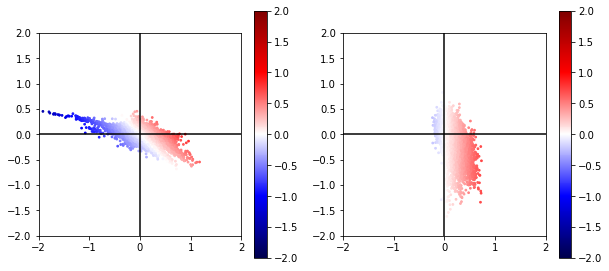

In [22]:
dmax = 2e-0
dmin = -dmax

plt.subplot(221)
plt.scatter(detadt_areas*mps_to_mmpyr,(detadt_slope-detadt_areas)*mps_to_mmpyr,
            c=detadt_slope*mps_to_mmpyr,vmin=dmin,vmax=dmax,cmap='seismic',s=3)
plt.colorbar()
plt.plot([dmin,dmax],[0,0],c='k')
plt.plot([0,0],[dmin,dmax],c='k')
plt.axis('square')
plt.xlim(dmin,dmax)
plt.ylim(dmin,dmax)

plt.subplot(222)
plt.scatter(detadt*mps_to_mmpyr,(detadt_slope-detadt)*mps_to_mmpyr,
            c=detadt*mps_to_mmpyr,vmin=dmin,vmax=dmax,cmap='seismic',s=3)
plt.colorbar()
plt.plot([dmin,dmax],[0,0],c='k')
plt.plot([0,0],[dmin,dmax],c='k')
plt.axis('square')
plt.xlim(dmin,dmax)
plt.ylim(dmin,dmax)

(48.95, 56.25000000000004, 17.95, 25.25000000000004)

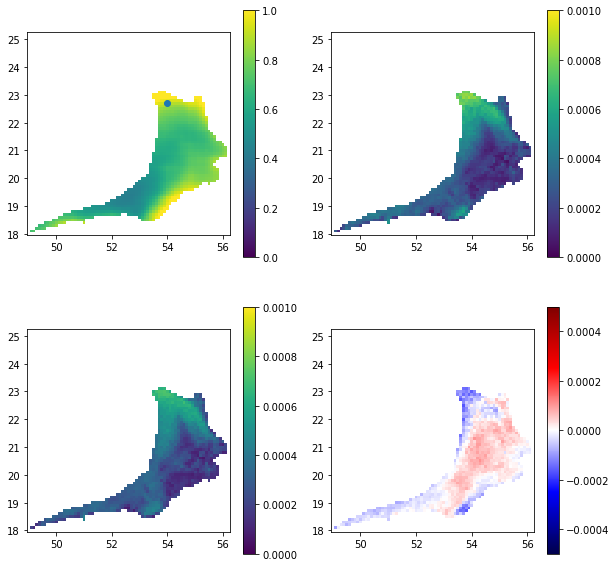

In [134]:
plt.subplot(221)
plt.pcolormesh(templongrid,templatgrid,np.mean(qam,axis=(0,1)),vmin=0,vmax=0.001)
plt.colorbar()
plt.axis('square')

plt.subplot(222)
plt.pcolormesh(templongrid,templatgrid,np.mean(qam_areas,axis=(0,1)),vmin=0,vmax=0.001)
plt.colorbar()
plt.axis('square')

plt.subplot(223)
plt.pcolormesh(templongrid,templatgrid,np.mean(qam_slope,axis=(0,1)),vmin=0,vmax=0.001)
plt.colorbar()
plt.axis('square')

plt.subplot(224)
plt.pcolormesh(templongrid,templatgrid,np.mean(qam_slope,axis=(0,1))-np.mean(qam_areas,axis=(0,1)),vmin=-5e-4,vmax=5e-4,cmap='seismic')
plt.colorbar()
plt.axis('square')

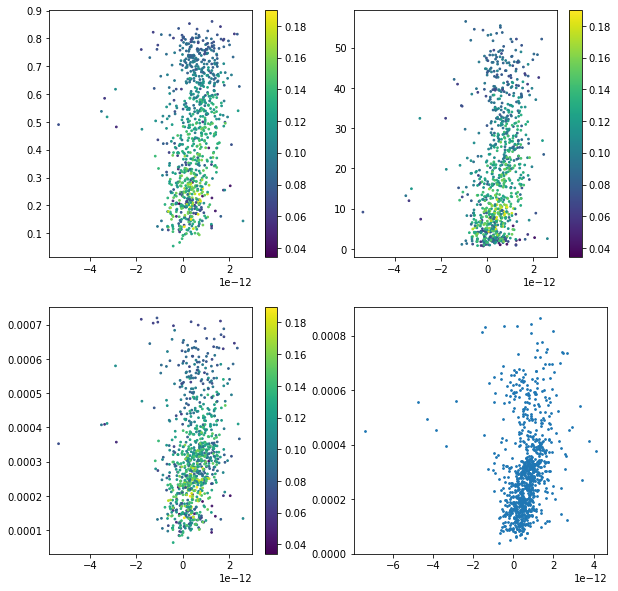

In [24]:
plt.subplot(221)
plt.scatter(np.mean(detadt_slope,axis=(0,1)),areafraction[1:-1,1:-1],
            c=np.mean(lengthweightedslopetheta,axis=2)[1:-1,1:-1],s=3)
plt.colorbar()
plt.subplot(222)
plt.scatter(np.mean(detadt_slope,axis=(0,1)),equivalentthickness[1:-1,1:-1],
            c=np.mean(lengthweightedslopetheta,axis=2)[1:-1,1:-1],s=3)
plt.colorbar()
plt.subplot(223)
plt.scatter(np.mean(detadt_slope,axis=(0,1)),np.mean(qam_slope,axis=(0,1))[1:-1,1:-1],
            c=np.mean(lengthweightedslopetheta,axis=2)[1:-1,1:-1],s=3)
plt.colorbar()
plt.subplot(224)
plt.scatter(np.mean(detadt_areas,axis=(0,1)),np.mean(qam_areas,axis=(0,1))[1:-1,1:-1],s=3)

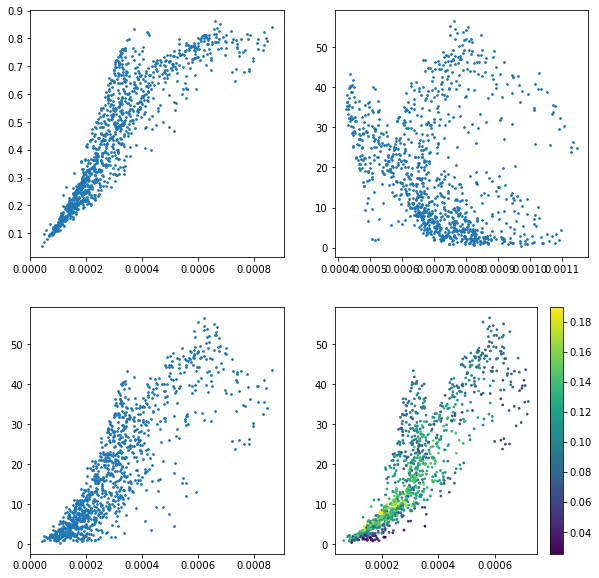

In [25]:
plt.subplot(221)
plt.scatter(np.mean(qam_areas,axis=(0,1)),areafraction,s=3)
plt.subplot(222)
plt.scatter(np.mean(qam,axis=(0,1)),equivalentthickness,s=3)
plt.subplot(223)
plt.scatter(np.mean(qam_areas,axis=(0,1)),equivalentthickness,s=3)
plt.subplot(224)
plt.scatter(np.ndarray.flatten(np.mean(qam_slope,axis=(0,1))),equivalentthickness,
            c=np.mean(lengthweightedslopetheta,axis=2),s=3)
plt.colorbar()

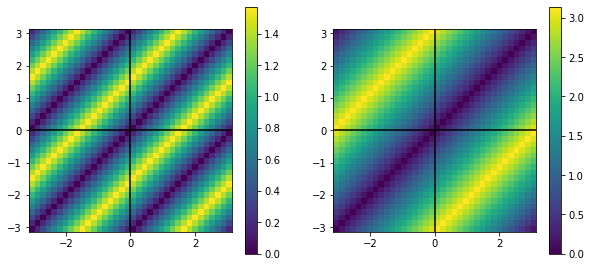

In [26]:
plt.subplot(221)
plt.pcolormesh(thetas,thetas,sub90diffa,vmin=0,vmax=np.pi/2)
plt.colorbar()
plt.axis('square')
plt.plot([-np.pi,np.pi],[0,0],c='k')
plt.plot([0,0],[-np.pi,np.pi],c='k')

plt.subplot(222)
plt.pcolormesh(thetas,thetas,sub180diffa,vmin=0,vmax=np.pi)
plt.colorbar()
plt.axis('square')
plt.plot([-np.pi,np.pi],[0,0],c='k')
plt.plot([0,0],[-np.pi,np.pi],c='k')

(48.95, 56.25000000000004, 17.95, 25.25000000000004)

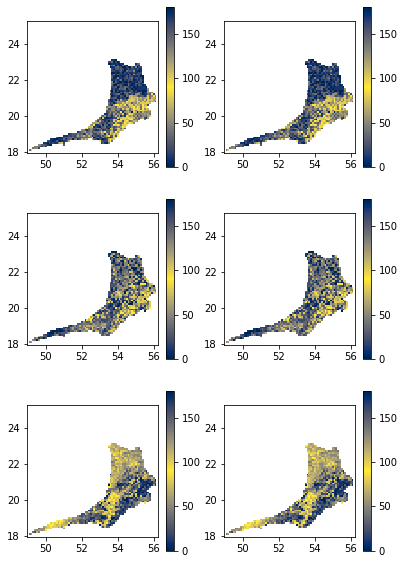

In [53]:
plt.subplot(331)
plt.pcolormesh(templongrid,templatgrid,sub90diffa_steepest_qnatotdir_slope*180/np.pi,vmin=0,vmax=180,cmap=mirror)
plt.colorbar()
plt.axis('square')

plt.subplot(332)
plt.pcolormesh(templongrid,templatgrid,sub180diffa_steepest_qnatotdir_slope*180/np.pi,vmin=0,vmax=180,cmap=mirror)
plt.colorbar()
plt.axis('square')

plt.subplot(334)
plt.pcolormesh(templongrid,templatgrid,sub90diffa_shortest_qnatotdir_slope*180/np.pi,vmin=0,vmax=180,cmap=mirror)
plt.colorbar()
plt.axis('square')

plt.subplot(335)
plt.pcolormesh(templongrid,templatgrid,sub180diffa_shortest_qnatotdir_slope*180/np.pi,vmin=0,vmax=180,cmap=mirror)
plt.colorbar()
plt.axis('square')

plt.subplot(337)
plt.pcolormesh(templongrid,templatgrid,sub90diffa_longest_qnatotdir_slope*180/np.pi,vmin=0,vmax=180,cmap=mirror)
plt.colorbar()
plt.axis('square')

plt.subplot(338)
plt.pcolormesh(templongrid,templatgrid,sub180diffa_longest_qnatotdir_slope*180/np.pi,vmin=0,vmax=180,cmap=mirror)
plt.colorbar()
plt.axis('square')

(48.95, 56.25000000000004, 17.95, 25.25000000000004)

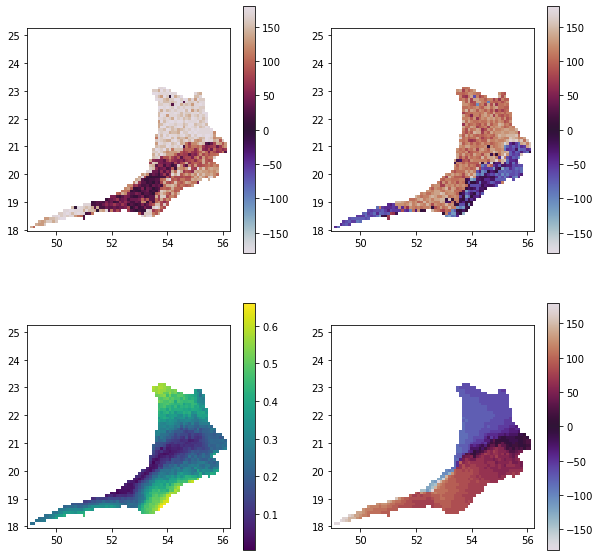

In [125]:
plt.subplot(221)
plt.pcolormesh(templongrid,templatgrid,sub180diffa_steepest_qnatotdir_slope*180/np.pi,vmin=-180,vmax=180,cmap='twilight')
plt.colorbar()
plt.axis('square')

plt.subplot(222)
plt.pcolormesh(templongrid,templatgrid,thetasteepest*180/np.pi,vmin=-180,vmax=180,cmap='twilight')
plt.colorbar()
plt.axis('square')

plt.subplot(223)
plt.pcolormesh(templongrid,templatgrid,qd_slope)
plt.colorbar()
plt.axis('square')

plt.subplot(224)
plt.pcolormesh(templongrid,templatgrid,qnatotbinned_slope*180/np.pi,vmin=-180,vmax=180,cmap='twilight')
plt.colorbar()
plt.axis('square')

(48.95, 56.25000000000004, 17.95, 25.25000000000004)

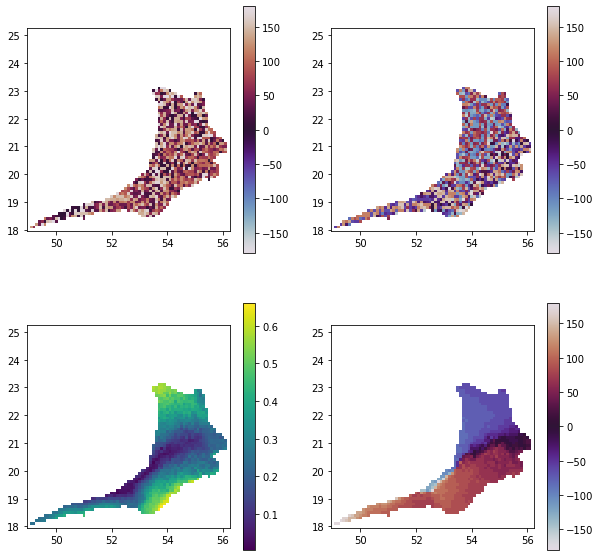

In [29]:
plt.subplot(221)
plt.pcolormesh(templongrid,templatgrid,sub180diffa_shortest_qnatotdir_slope*180/np.pi,vmin=-180,vmax=180,cmap='twilight')
plt.colorbar()
plt.axis('square')

plt.subplot(222)
plt.pcolormesh(templongrid,templatgrid,thetashortest*180/np.pi,vmin=-180,vmax=180,cmap='twilight')
plt.colorbar()
plt.axis('square')

plt.subplot(223)
plt.pcolormesh(templongrid,templatgrid,qnmtot_slope/qamtot_slope)
plt.colorbar()
plt.axis('square')

plt.subplot(224)
plt.pcolormesh(templongrid,templatgrid,qnatotbinned_slope*180/np.pi,vmin=-180,vmax=180,cmap='twilight')
plt.colorbar()
plt.axis('square')

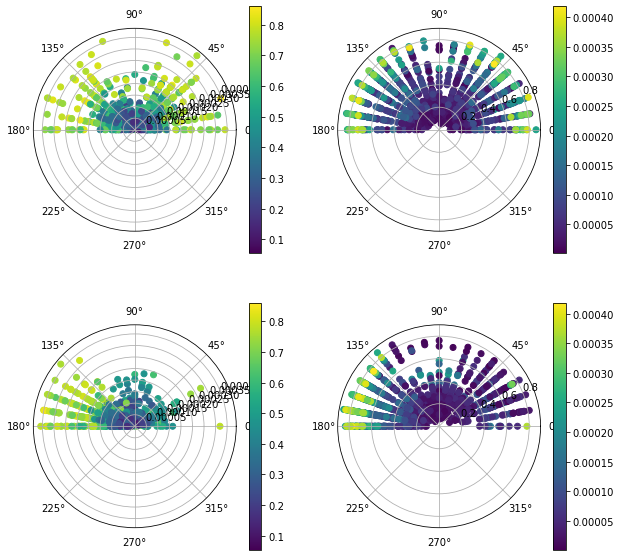

In [30]:
plt.subplot(221,projection='polar')
plt.scatter(sub180diffa_shortest_qnatotdir_slope,qnmtot_slope,c=areafraction)
plt.colorbar()

plt.subplot(222,projection='polar')
plt.scatter(sub180diffa_shortest_qnatotdir_slope,areafraction,c=qnmtot_slope)
plt.colorbar()

plt.subplot(223,projection='polar')
plt.scatter(sub180diffa_steepest_qnatotdir_slope,qnmtot_slope,c=areafraction)
plt.colorbar()

plt.subplot(224,projection='polar')
plt.scatter(sub180diffa_steepest_qnatotdir_slope,areafraction,c=qnmtot_slope)
plt.colorbar()

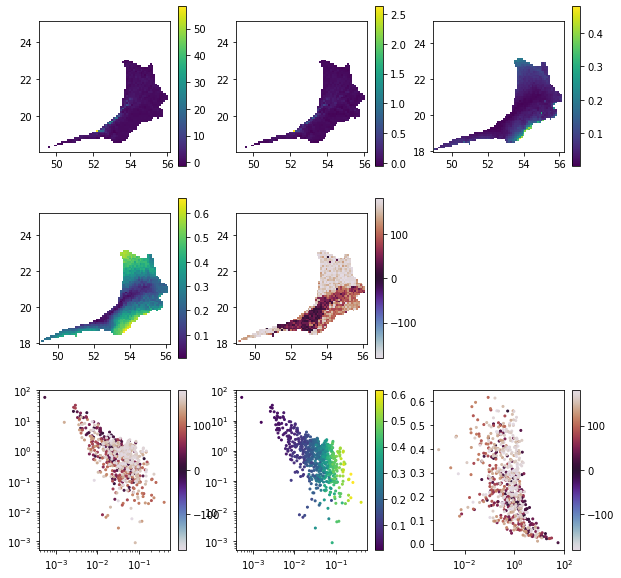

In [31]:
ss = 4

plt.subplot(331)
plt.pcolormesh(templongrid[1:-1],templatgrid[1:-1],setthickness_slope)
plt.colorbar()
plt.axis('square')

plt.subplot(332)
plt.pcolormesh(templongrid[1:-1],templatgrid[1:-1],setangle_slope*180/np.pi)
plt.colorbar()
plt.axis('square')

plt.subplot(333)
plt.pcolormesh(templongrid,templatgrid,crossbedwidth_slope)
plt.colorbar()
plt.axis('square')

plt.subplot(334)
plt.pcolormesh(templongrid,templatgrid,qd_slope)
plt.colorbar()
plt.axis('square')

plt.subplot(335)
plt.pcolormesh(templongrid,templatgrid,sub180diffa_steepest_qnatotdir_slope*180/np.pi,vmin=-180,vmax=180,cmap='twilight')
plt.colorbar()
plt.axis('square')

plt.subplot(337)
plt.scatter(crossbedwidth_slope[1:-1,1:-1],setthickness_slope,c=sub180diffa_steepest_qnatotdir_slope[1:-1,1:-1]*180/np.pi,vmin=-180,vmax=180,cmap='twilight',s=ss)
plt.colorbar()
plt.xscale('log')
plt.yscale('log')

plt.subplot(338)
plt.scatter(crossbedwidth_slope[1:-1,1:-1],setthickness_slope,c=qd_slope[1:-1,1:-1],s=ss)
plt.colorbar()
plt.xscale('log')
plt.yscale('log')

plt.subplot(339)
plt.scatter(setthickness_slope,qd_slope[1:-1,1:-1],c=sub180diffa_steepest_qnatotdir_slope[1:-1,1:-1]*180/np.pi,vmin=-180,vmax=180,cmap='twilight',s=ss)
plt.colorbar()
plt.xscale('log')

/local/k10/ag5517/tmp/ipykernel_334147/326671977.py:30: RuntimeWarning: invalid value encountered in sqrt
  plt.scatter((crossbedwidth_slope[1:-1,1:-1][morph[1:-1,1:-1]==uniinds[i]]/setthickness_slope[morph[1:-1,1:-1]==uniinds[i]])**0.5,migrationspeed_slope[1:-1,1:-1][morph[1:-1,1:-1]==uniinds[i]],s=ss,


Text(0.5, 1.0, 'transverse and barchan dunes')

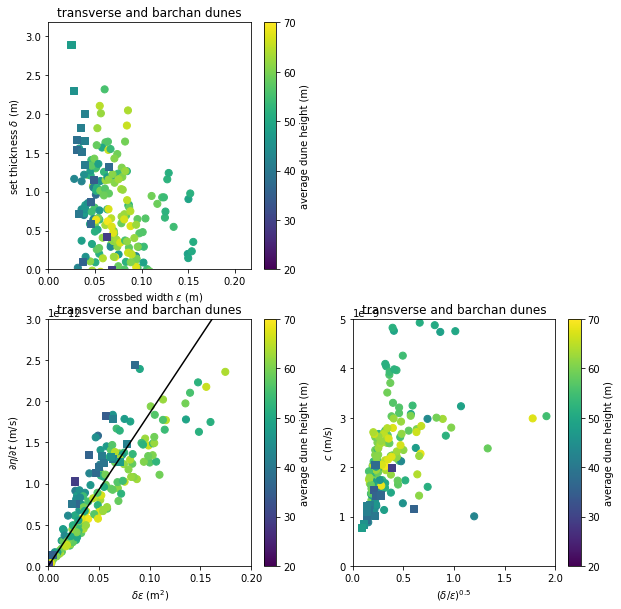

In [184]:
ss = 50
mstyles = ['o','s']

plt.subplot(221)
for i in range(len(uniinds)):
    plt.scatter(crossbedwidth_slope[1:-1,1:-1][morph[1:-1,1:-1]==uniinds[i]],setthickness_slope[morph[1:-1,1:-1]==uniinds[i]],s=ss,
                c=(equivalentthickness/areafraction)[1:-1,1:-1][morph[1:-1,1:-1]==uniinds[i]],marker=mstyles[i],vmin=20,vmax=70)
plt.colorbar(label='average dune height (m)')
plt.xlim(0,np.nanmax(crossbedwidth_slope[1:-1,1:-1][np.any([morph[1:-1,1:-1]==uniinds[i] for i in range(len(uniinds))],axis=0)])*1.1)
plt.ylim(0,np.nanmax(setthickness_slope[np.any([morph[1:-1,1:-1]==uniinds[i] for i in range(len(uniinds))],axis=0)])*1.1)
plt.xlabel('crossbed width $\\epsilon$ (m)')
plt.ylabel('set thickness $\\delta$ (m)')
plt.title('transverse and barchan dunes')

plt.subplot(223)
for i in range(len(uniinds)):
    plt.scatter(setthickness_slope[morph[1:-1,1:-1]==uniinds[i]]*crossbedwidth_slope[1:-1,1:-1][morph[1:-1,1:-1]==uniinds[i]],np.mean(detadt_slope,axis=(0,1))[morph[1:-1,1:-1]==uniinds[i]],s=ss,
                c=(equivalentthickness/areafraction)[1:-1,1:-1][morph[1:-1,1:-1]==uniinds[i]],marker=mstyles[i],vmin=20,vmax=70)
plt.colorbar(label='average dune height (m)')
plt.plot([0,0.2],[0,0.2*1/yr_to_s/np.nanmean(bedformlength_qnatotdir_slope[np.any([morph==uniinds[i] for i in range(len(uniinds))],axis=0)])],c='k')
plt.xlim(0,0.2)
plt.ylim(0,3e-12)

plt.xlabel('$\\delta\\epsilon$ (m$^2$)')
plt.ylabel('$\\partial\\eta/\\partial t$ (m/s)')
plt.title('transverse and barchan dunes')

plt.subplot(224)
for i in range(len(uniinds)):
    plt.scatter((crossbedwidth_slope[1:-1,1:-1][morph[1:-1,1:-1]==uniinds[i]]/setthickness_slope[morph[1:-1,1:-1]==uniinds[i]])**0.5,migrationspeed_slope[1:-1,1:-1][morph[1:-1,1:-1]==uniinds[i]],s=ss,
                c=(equivalentthickness/areafraction)[1:-1,1:-1][morph[1:-1,1:-1]==uniinds[i]],marker=mstyles[i],vmin=20,vmax=70)
plt.colorbar(label='average dune height (m)')
# plt.xlim(5e-2,1e+1)
# plt.xscale('log')
# plt.ylim(1e-10,1e-8)
# plt.yscale('log')
plt.xlim(0,2)
plt.ylim(0,5e-9)

plt.xlabel('$(\\delta/\\epsilon)^{0.5}$')
plt.ylabel('$c$ (m/s)')
plt.title('transverse and barchan dunes')

/local/k10/ag5517/tmp/ipykernel_334147/2322257887.py:23: RuntimeWarning: invalid value encountered in sqrt
  plt.scatter((crossbedwidth_slope[1:-1,1:-1]/setthickness_slope)**0.5,migrationspeed_slope[1:-1,1:-1],s=ss,c=(equivalentthickness/areafraction)[1:-1,1:-1],vmin=0,vmax=70)


Text(0, 0.5, '$c$ (m/s)')

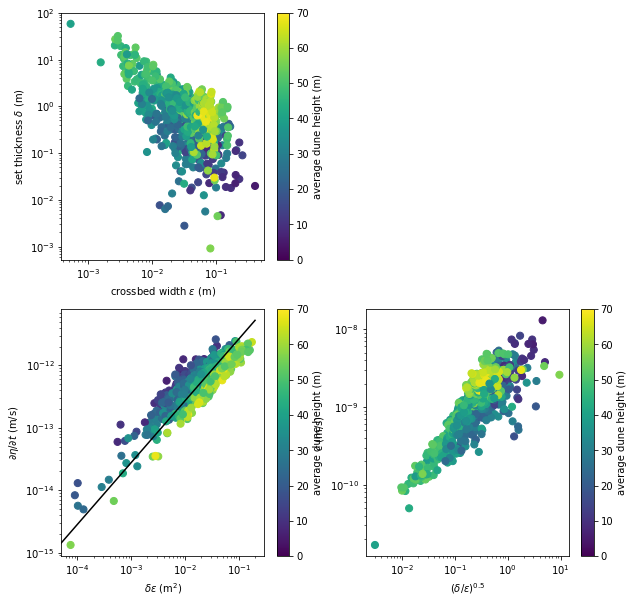

In [201]:
ss = 50
mstyles = ['o','s']

plt.subplot(221)
plt.scatter(crossbedwidth_slope[1:-1,1:-1],setthickness_slope,s=ss,c=(equivalentthickness/areafraction)[1:-1,1:-1],vmin=0,vmax=70)
plt.colorbar(label='average dune height (m)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('crossbed width $\\epsilon$ (m)')
plt.ylabel('set thickness $\\delta$ (m)')

plt.subplot(223)
plt.scatter(setthickness_slope*crossbedwidth_slope[1:-1,1:-1],np.mean(detadt_slope,axis=(0,1)),s=ss,c=(equivalentthickness/areafraction)[1:-1,1:-1],vmin=0,vmax=70)
plt.colorbar(label='average dune height (m)')
plt.plot([0,0.2],[0,0.2*1/yr_to_s/np.nanmean(bedformlength_qnatotdir_slope)],c='k')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('$\\delta\\epsilon$ (m$^2$)')
plt.ylabel('$\\partial\\eta/\\partial t$ (m/s)')

plt.subplot(224)
plt.scatter((crossbedwidth_slope[1:-1,1:-1]/setthickness_slope)**0.5,migrationspeed_slope[1:-1,1:-1],s=ss,c=(equivalentthickness/areafraction)[1:-1,1:-1],vmin=0,vmax=70)
plt.colorbar(label='average dune height (m)')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('$(\\delta/\\epsilon)^{0.5}$')
plt.ylabel('$c$ (m/s)')

(48.95, 56.25000000000004, 17.95, 25.25000000000004)

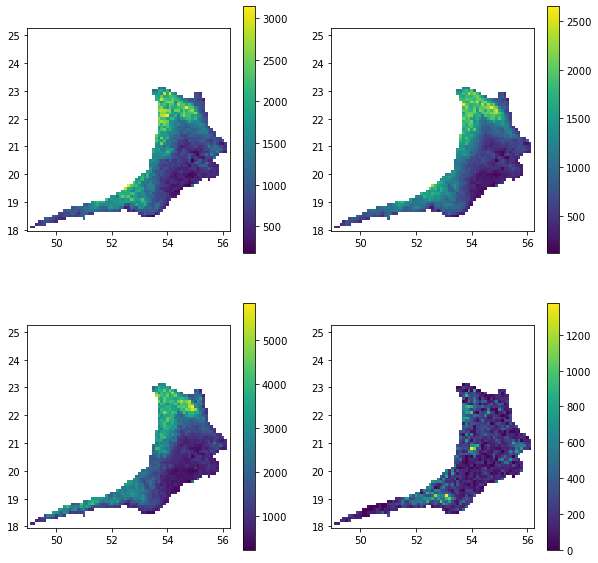

In [32]:
plt.subplot(221)
plt.pcolormesh(templongrid,templatgrid,bedformlength_qnatotdir_slope)
plt.colorbar()
plt.axis('square')

plt.subplot(222)
plt.pcolormesh(templongrid,templatgrid,np.min(bedformlengththeta,axis=2))
plt.colorbar()
plt.axis('square')

plt.subplot(223)
plt.pcolormesh(templongrid,templatgrid,np.max(bedformlengththeta,axis=2))
plt.colorbar()
plt.axis('square')

plt.subplot(224)
plt.pcolormesh(templongrid,templatgrid,bedformlength_qnatotdir_slope-np.min(bedformlengththeta,axis=2))
plt.colorbar()
plt.axis('square')

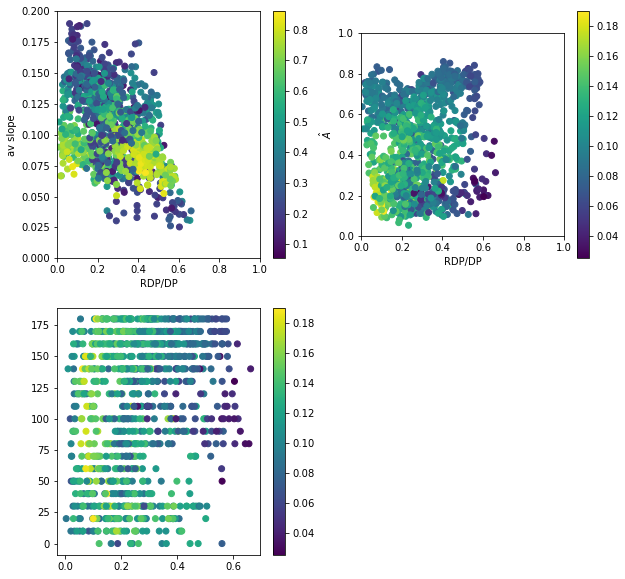

In [126]:
plt.subplot(221)
plt.scatter(qnmtot_slope/qamtot_slope,np.mean(lengthweightedslopetheta,axis=2),c=areafraction)
plt.colorbar()
plt.xlim(0,1)
plt.ylim(0,0.2)
plt.xlabel('RDP/DP')
plt.ylabel('av slope')

plt.subplot(222)
plt.scatter(qnmtot_slope/qamtot_slope,areafraction,c=np.mean(lengthweightedslopetheta,axis=2))
plt.colorbar()
plt.axis('square')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('RDP/DP')
plt.ylabel('$\\hat{A}$')

plt.subplot(223)
plt.scatter(qd_slope,sub180diffa_steepest_qnatotdir_slope*180/np.pi,c=np.mean(lengthweightedslopetheta,axis=2))
plt.colorbar()

/local/k10/ag5517/tmp/ipykernel_1320372/4095978627.py:26: RuntimeWarning: Mean of empty slice
  tempby_av[i] = np.nanmean(tempy[(tempx>tempbx[i])&(tempx<=tempbx[i+1])])
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1372: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


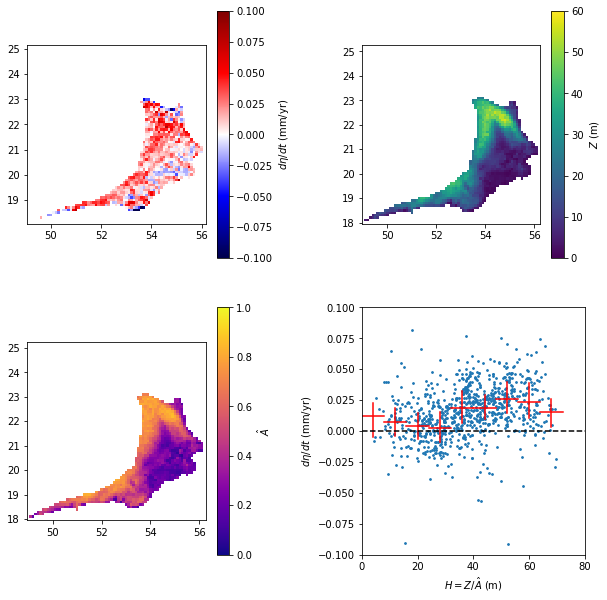

In [34]:
plt.subplot(221)
plt.pcolormesh(templongrid[1:-1],templatgrid[1:-1],np.mean(detadtflat_slope,axis=0)*mps_to_mmpyr,vmin=-1e-1,vmax=1e-1,cmap='seismic')
plt.colorbar(label='$d\eta/dt$ (mm/yr)')
plt.axis('square')

plt.subplot(222)
plt.pcolormesh(templongrid,templatgrid,equivalentthickness,vmin=0,vmax=60)
plt.colorbar(label='$Z$ (m)')
plt.axis('square')

plt.subplot(223)
plt.pcolormesh(templongrid,templatgrid,areafraction,vmin=0,vmax=1,cmap='plasma')
plt.colorbar(label='$\\hat{A}$')
plt.axis('square')

plt.subplot(224)
plt.scatter(equivalentthickness[1:-1,1:-1]/areafraction[1:-1,1:-1],np.mean(detadtflat_slope,axis=0)*mps_to_mmpyr,s=3)

tempy  = np.ndarray.flatten(np.mean(detadtflat_slope,axis=0))
tempx  = np.ndarray.flatten(equivalentthickness[1:-1,1:-1]/areafraction[1:-1,1:-1])
tempbx = np.linspace(0,80,11)
tempby_av = np.empty(len(tempbx)-1)
tempby_25 = np.empty(len(tempbx)-1)
tempby_75 = np.empty(len(tempbx)-1)
for i in range(len(tempbx)-1):
    tempby_av[i] = np.nanmean(tempy[(tempx>tempbx[i])&(tempx<=tempbx[i+1])])
    tempby_25[i] = np.nanpercentile(tempy[(tempx>tempbx[i])&(tempx<=tempbx[i+1])],25)
    tempby_75[i] = np.nanpercentile(tempy[(tempx>tempbx[i])&(tempx<=tempbx[i+1])],75)
for i in range(len(tempbx)-1):
    plt.plot([tempbx[i],tempbx[i+1]],[tempby_av[i]*mps_to_mmpyr,tempby_av[i]*mps_to_mmpyr],c='r')
    plt.plot([(tempbx[i]+tempbx[i+1])/2,(tempbx[i]+tempbx[i+1])/2],[tempby_25[i]*mps_to_mmpyr,tempby_75[i]*mps_to_mmpyr],c='r')
plt.plot([tempbx[0],tempbx[-1]],[0,0],'--k')

plt.xlim(0,80)
plt.ylim(-1e-1,1e-1)
plt.ylabel('$d\eta/dt$ (mm/yr)')
plt.xlabel('$H=Z/\\hat{A}$ (m)')

plt.subplots_adjust(wspace=0.5)

In [35]:
np.nanmax(equivalentthickness[1:-1,1:-1]/np.mean(detadtflat_slope,axis=0)*s_to_ma)

1032.0586351105696

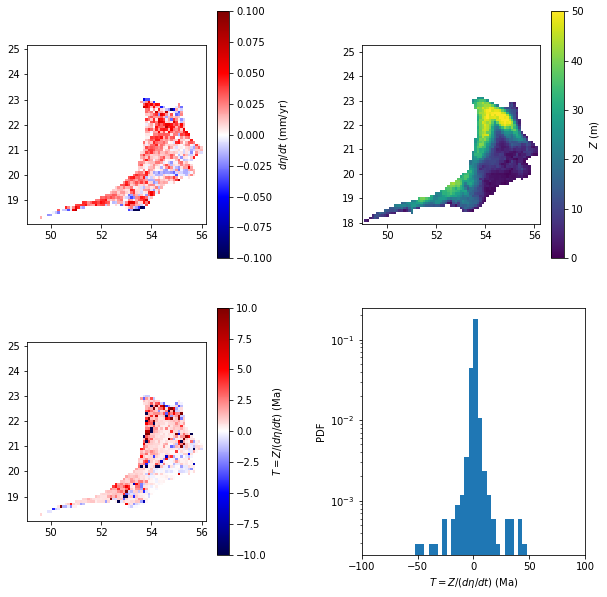

In [36]:
plt.subplot(221)
plt.pcolormesh(templongrid[1:-1],templatgrid[1:-1],np.mean(detadtflat_slope,axis=0)*mps_to_mmpyr,vmin=-1e-1,vmax=1e-1,cmap='seismic')
plt.colorbar(label='$d\eta/dt$ (mm/yr)')
plt.axis('square')

plt.subplot(222)
plt.pcolormesh(templongrid,templatgrid,equivalentthickness,vmin=0,vmax=50)
plt.colorbar(label='$Z$ (m)')
plt.axis('square')

plt.subplot(223)
plt.pcolormesh(templongrid[1:-1],templatgrid[1:-1],equivalentthickness[1:-1,1:-1]/np.mean(detadtflat_slope,axis=0)*s_to_ma,vmin=-10,vmax=10,cmap='seismic')
plt.colorbar(label='$T=Z/(d\eta/dt)$ (Ma)')
plt.axis('square')

plt.subplot(224)
tempbabs = 100
tempbx = np.linspace(-tempbabs,tempbabs,51)
plt.hist(np.ndarray.flatten(equivalentthickness[1:-1,1:-1]/np.mean(detadtflat_slope,axis=0))*s_to_ma,bins=tempbx,density=True,log=True)

plt.xlim(-tempbabs,tempbabs)
# plt.ylim(0,0.3)
plt.ylabel('PDF')
plt.xlabel('$T=Z/(d\eta/dt)$ (Ma)')

plt.subplots_adjust(wspace=0.5)

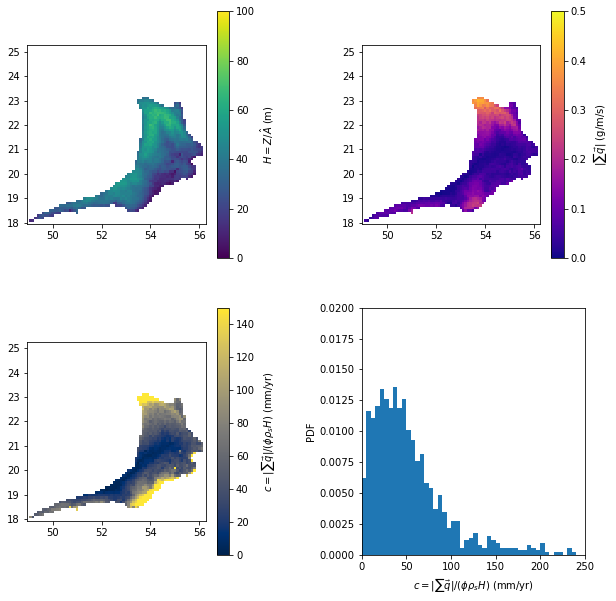

In [37]:
plt.subplot(221)
plt.pcolormesh(templongrid,templatgrid,equivalentthickness/areafraction,vmin=0,vmax=100)
plt.colorbar(label='$H=Z/\\hat{A}$ (m)')
plt.axis('square')

plt.subplot(222)
plt.pcolormesh(templongrid,templatgrid,qnmtot_slope*1e+3,vmin=0,vmax=0.5,cmap='plasma')
plt.colorbar(label='$|\\sum\\vec{q}|$ (g/m/s)')
plt.axis('square')

plt.subplot(223)
plt.pcolormesh(templongrid,templatgrid,migrationspeed_slope*mps_to_mmpyr,vmin=0,vmax=150,cmap='cividis')
plt.colorbar(label='$c=|\\sum\\vec{q}|/(\\phi\\rho_sH)$ (mm/yr)')
plt.axis('square')

plt.subplot(224)
tempbx = np.linspace(0,250,51)
plt.hist(np.ndarray.flatten(migrationspeed_slope)*mps_to_mmpyr,bins=tempbx,density=True)
plt.xlim(0,250)
plt.ylim(0,0.02)
plt.ylabel('PDF')
plt.xlabel('$c=|\\sum\\vec{q}|/(\\phi\\rho_sH)$ (mm/yr)')

plt.subplots_adjust(wspace=0.5)

(48.95, 56.25000000000004, 17.95, 25.25000000000004)

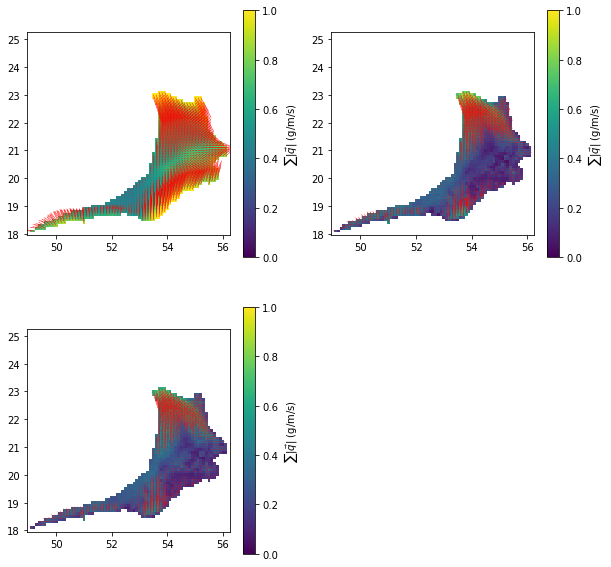

In [127]:
plt.subplot(221)
plt.pcolormesh(templongrid,templatgrid,qamtot*1e+3,vmin=0,vmax=1,cmap='viridis')
plt.colorbar(label='$\\sum|\\vec{q}|$ (g/m/s)')
plt.quiver(templongrid,templatgrid,qnxtot,qnytot,scale=5e-3,color='r',headwidth=1.5)
plt.axis('square')

plt.subplot(222)
plt.pcolormesh(templongrid,templatgrid,qamtot_areas*1e+3,vmin=0,vmax=1,cmap='viridis')
plt.colorbar(label='$\\sum|\\vec{q}|$ (g/m/s)')
plt.quiver(templongrid,templatgrid,qnxtot_areas,qnytot_areas,scale=5e-3,color='r',headwidth=1.5)
plt.axis('square')

plt.subplot(223)
plt.pcolormesh(templongrid,templatgrid,qamtot_slope*1e+3,vmin=0,vmax=1,cmap='viridis')
plt.colorbar(label='$\\sum|\\vec{q}|$ (g/m/s)')
plt.quiver(templongrid,templatgrid,qnxtot_slope,qnytot_slope,scale=5e-3,color='r',headwidth=1.5)
plt.axis('square')

(48.95, 56.25000000000004, 17.95, 25.25000000000004)

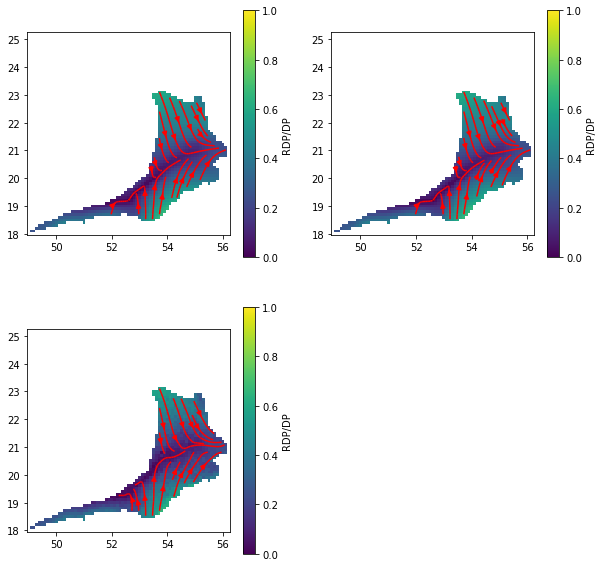

In [39]:
plt.subplot(221)
plt.pcolormesh(templongrid,templatgrid,qd,vmin=0,vmax=1,cmap='viridis')
plt.colorbar(label='RDP/DP')
plt.streamplot(templongrid,templatgrid,qnxtot,qnytot,color='r')
plt.axis('square')

plt.subplot(222)
plt.pcolormesh(templongrid,templatgrid,qd_areas,vmin=0,vmax=1,cmap='viridis')
plt.colorbar(label='RDP/DP')
plt.streamplot(templongrid,templatgrid,qnxtot_areas,qnytot_areas,color='r')
plt.axis('square')

plt.subplot(223)
plt.pcolormesh(templongrid,templatgrid,qd_slope,vmin=0,vmax=1,cmap='viridis')
plt.colorbar(label='RDP/DP')
plt.streamplot(templongrid,templatgrid,qnxtot_slope,qnytot_slope,color='r')
plt.axis('square')

/local/k10/ag5517/tmp/ipykernel_1320372/3204109231.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/f, Pxx)
/local/k10/ag5517/tmp/ipykernel_1320372/3204109231.py:35: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/f, Pxx)
/local/k10/ag5517/tmp/ipykernel_1320372/3204109231.py:37: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/f, Pxx)


Text(0, 0.5, 'Power (mm$^2$/yr$^2$)')

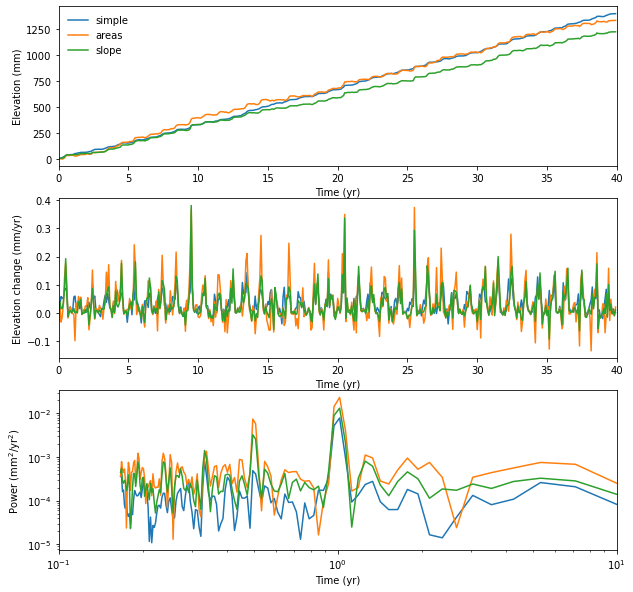

In [40]:
i = 30
j = 50

x0 = etaflat[:,i,j]*1e+6
x1 = detadtflat[:,i,j]*mps_to_mmpyr

x0_areas = etaflat_areas[:,i,j]*1e+6
x1_areas = detadtflat_areas[:,i,j]*mps_to_mmpyr

x0_slope = etaflat_slope[:,i,j]*1e+6
x1_slope = detadtflat_slope[:,i,j]*mps_to_mmpyr

plt.subplot(311)
plt.plot(np.arange(len(years)*len(months))/12,x0,label='simple')
plt.plot(np.arange(len(years)*len(months))/12,x0_areas,label='areas')
plt.plot(np.arange(len(years)*len(months))/12,x0_slope,label='slope')
plt.xlim(0,len(years)*len(months)/12)
# plt.ylim(np.min(x0),np.max(x0))
plt.xlabel('Time (yr)')
plt.ylabel('Elevation (mm)')
plt.legend(frameon=False)

plt.subplot(312)
plt.plot(np.arange(len(years)*len(months))/12,x1)
plt.plot(np.arange(len(years)*len(months))/12,x1_areas)
plt.plot(np.arange(len(years)*len(months))/12,x1_slope)
plt.xlim(0,len(years)*len(months)/12)
plt.xlabel('Time (yr)')
plt.ylabel('Elevation change (mm/yr)')

plt.subplot(313)
f, Pxx = signal.welch(x1[:-1], 12)
plt.plot(1/f, Pxx)
f, Pxx = signal.welch(x1_areas[:-1], 12)
plt.plot(1/f, Pxx)
f, Pxx = signal.welch(x1_slope[:-1], 12)
plt.plot(1/f, Pxx)
plt.xlim(0.1,10)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time (yr)')
plt.ylabel('Power (mm$^2$/yr$^2$)')

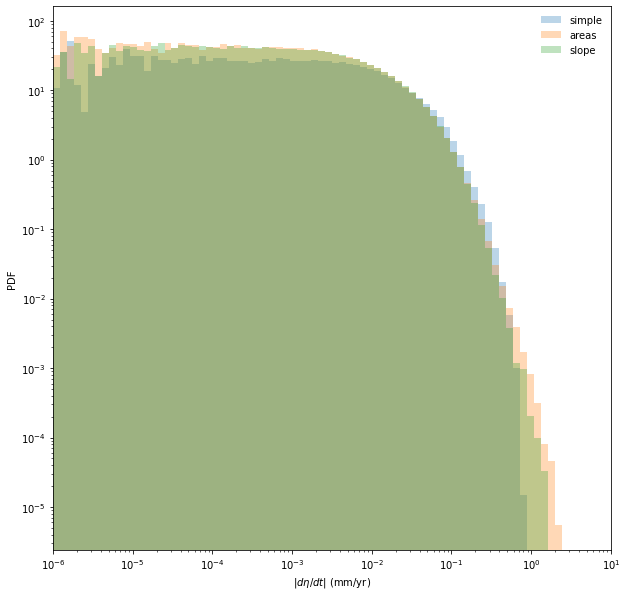

In [41]:
bmin = 1e-6
bmax = 1e+1
bnum = 81
bins = np.logspace(np.log10(bmin),np.log10(bmax),bnum)

temp = np.ndarray.flatten(np.abs(detadt))
temp = temp[~np.isnan(temp)]
_,_,_=plt.hist(temp*mps_to_mmpyr,bins=bins,log=True,density=True,alpha=0.3,label='simple')

temp = np.ndarray.flatten(np.abs(detadt_areas))
temp = temp[~np.isnan(temp)]
_,_,_=plt.hist(temp*mps_to_mmpyr,bins=bins,log=True,density=True,alpha=0.3,label='areas')

temp = np.ndarray.flatten(np.abs(detadt_slope))
temp = temp[~np.isnan(temp)]
_,_,_=plt.hist(temp*mps_to_mmpyr,bins=bins,log=True,density=True,alpha=0.3,label='slope')

plt.xscale('log')
plt.xlim(bmin,bmax)
plt.xlabel('$|d\eta/dt|$ (mm/yr)')
plt.ylabel('PDF')
plt.legend(frameon=False)

[Text(1, 0, 'B'),
 Text(1, 1, 'OB'),
 Text(1, 2, 'S'),
 Text(1, 3, 'OS'),
 Text(1, 4, 'D'),
 Text(1, 5, 'OD'),
 Text(1, 6, 'T'),
 Text(1, 7, 'TD'),
 Text(1, 8, 'BS')]

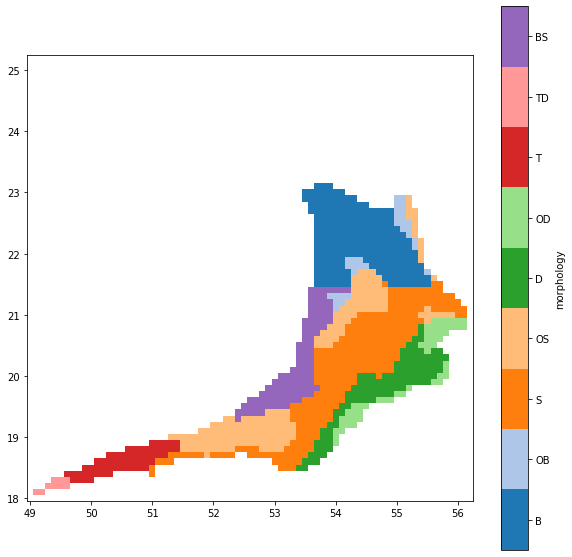

In [42]:
fig = plt.gcf()
p1 = plt.pcolormesh(templongrid,templatgrid,morph,vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9)
c1 = fig.colorbar(p1,ticks=np.arange(len(morphlist_abv)),label='morphology')
plt.axis('square')
c1.ax.set_yticklabels(morphlist_abv)

(-5.0, 185.0)

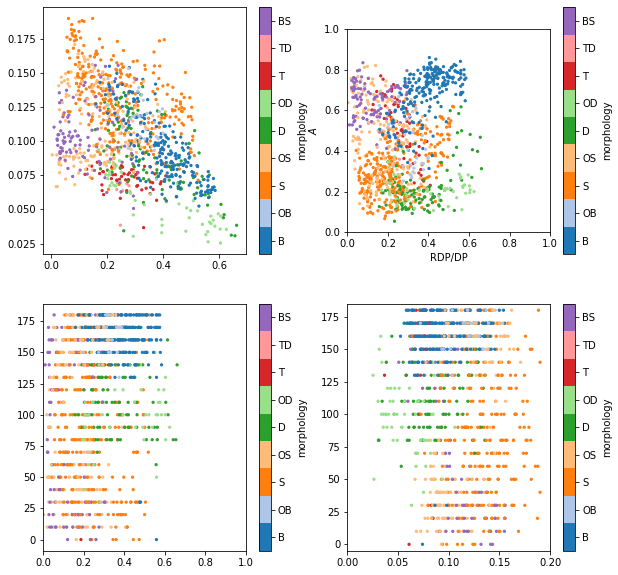

In [43]:
S = 5

fig = plt.gcf()

plt.subplot(221)
p1 = plt.scatter(qd_slope,np.mean(lengthweightedslopetheta,axis=2),c=morph,vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c1 = fig.colorbar(p1,ticks=np.arange(len(morphlist_abv)),label='morphology')
c1.ax.set_yticklabels(morphlist_abv)

plt.subplot(222)
p2 = plt.scatter(qd_slope,areafraction,c=morph,vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c2 = fig.colorbar(p2,ticks=np.arange(len(morphlist_abv)),label='morphology')
c2.ax.set_yticklabels(morphlist_abv)
plt.axis('square')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('RDP/DP')
plt.ylabel('$\\hat{A}$')

plt.subplot(223)
p3 = plt.scatter(qd_slope,sub180diffa_steepest_qnatotdir_slope*180/np.pi,c=morph,vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c3 = fig.colorbar(p3,ticks=np.arange(len(morphlist_abv)),label='morphology')
c3.ax.set_yticklabels(morphlist_abv)
plt.xlim(0,1)

plt.subplot(224)
p4 = plt.scatter(np.mean(lengthweightedslopetheta,axis=2),sub180diffa_steepest_qnatotdir_slope*180/np.pi,c=morph,vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c4 = fig.colorbar(p4,ticks=np.arange(len(morphlist_abv)),label='morphology')
c4.ax.set_yticklabels(morphlist_abv)
plt.xlim(0,0.2)
plt.ylim(-5,185)

[Text(1, 0, 'B'),
 Text(1, 1, 'OB'),
 Text(1, 2, 'S'),
 Text(1, 3, 'OS'),
 Text(1, 4, 'D'),
 Text(1, 5, 'OD'),
 Text(1, 6, 'T'),
 Text(1, 7, 'TD'),
 Text(1, 8, 'BS')]

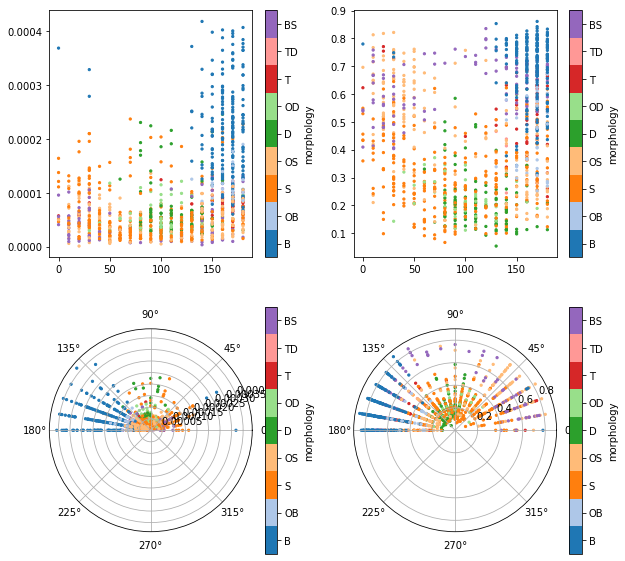

In [44]:
S = 5

fig = plt.gcf()

plt.subplot(221)
p1 = plt.scatter(sub180diffa_steepest_qnatotdir_slope*180/np.pi,qnmtot_slope,c=morph,vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c1 = fig.colorbar(p1,ticks=np.arange(len(morphlist_abv)),label='morphology')
c1.ax.set_yticklabels(morphlist_abv)

plt.subplot(222)
p2 = plt.scatter(sub180diffa_steepest_qnatotdir_slope*180/np.pi,areafraction,c=morph,vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c2 = fig.colorbar(p2,ticks=np.arange(len(morphlist_abv)),label='morphology')
c2.ax.set_yticklabels(morphlist_abv)

plt.subplot(223,projection='polar')
p3 = plt.scatter(sub180diffa_steepest_qnatotdir_slope,qnmtot_slope,c=morph,vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c3 = fig.colorbar(p3,ticks=np.arange(len(morphlist_abv)),label='morphology')
c3.ax.set_yticklabels(morphlist_abv)

plt.subplot(224,projection='polar')
p4 = plt.scatter(sub180diffa_steepest_qnatotdir_slope,areafraction,c=morph,vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c4 = fig.colorbar(p4,ticks=np.arange(len(morphlist_abv)),label='morphology')
c4.ax.set_yticklabels(morphlist_abv)

(10.0, 14.0)

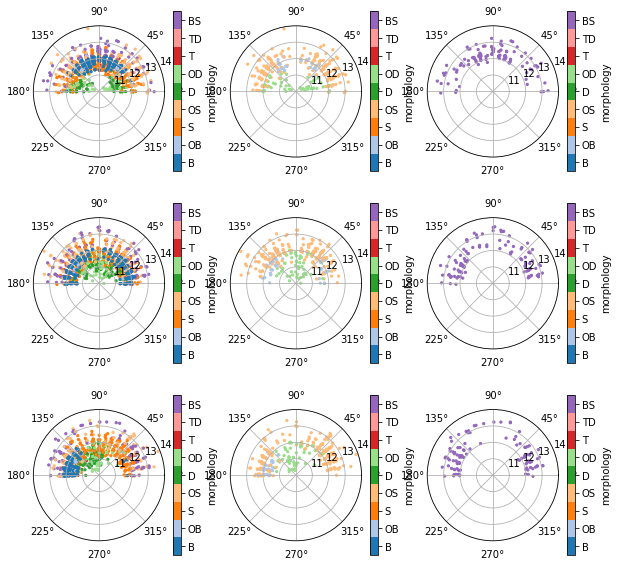

In [98]:
rmin,rmax = 10,14

S = 5
fig = plt.gcf()

plt.subplot(331,projection='polar')
p4 = plt.scatter(sub180diffa_longest_qnatotdir_slope+np.random.uniform(-2/180*np.pi,2/180*np.pi,np.shape(sub180diffa_longest_qnatotdir_slope)),np.log10(Tx_slope),c=morph,vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c4 = fig.colorbar(p4,ticks=np.arange(len(morphlist_abv)),label='morphology')
c4.ax.set_yticklabels(morphlist_abv)
plt.ylim(rmin,rmax)

plt.subplot(332,projection='polar')
p4 = plt.scatter(sub180diffa_longest_qnatotdir_slope[np.any([morph==oblinds[i] for i in range(len(oblinds))],axis=0)]+np.random.uniform(-2/180*np.pi,2/180*np.pi,np.shape(sub180diffa_longest_qnatotdir_slope[np.any([morph==oblinds[i] for i in range(len(oblinds))],axis=0)])),
                 np.log10(Tx_slope)[np.any([morph==oblinds[i] for i in range(len(oblinds))],axis=0)],c=morph[np.any([morph==oblinds[i] for i in range(len(oblinds))],axis=0)],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c4 = fig.colorbar(p4,ticks=np.arange(len(morphlist_abv)),label='morphology')
c4.ax.set_yticklabels(morphlist_abv)
plt.ylim(rmin,rmax)

plt.subplot(333,projection='polar')
p4 = plt.scatter(sub180diffa_longest_qnatotdir_slope[morph==bsind]+np.random.uniform(-2/180*np.pi,2/180*np.pi,np.shape(sub180diffa_longest_qnatotdir_slope[morph==bsind])),
                 np.log10(Tx_slope)[morph==bsind],c=morph[morph==bsind],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c4 = fig.colorbar(p4,ticks=np.arange(len(morphlist_abv)),label='morphology')
c4.ax.set_yticklabels(morphlist_abv)
plt.ylim(rmin,rmax)

plt.subplot(334,projection='polar')
p4 = plt.scatter(sub180diffa_shortest_qnatotdir_slope+np.random.uniform(-2/180*np.pi,2/180*np.pi,np.shape(sub180diffa_shortest_qnatotdir_slope)),np.log10(Tx_slope),c=morph,vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c4 = fig.colorbar(p4,ticks=np.arange(len(morphlist_abv)),label='morphology')
c4.ax.set_yticklabels(morphlist_abv)
plt.ylim(rmin,rmax)

plt.subplot(335,projection='polar')
p4 = plt.scatter(sub180diffa_shortest_qnatotdir_slope[np.any([morph==oblinds[i] for i in range(len(oblinds))],axis=0)]+np.random.uniform(-2/180*np.pi,2/180*np.pi,np.shape(sub180diffa_shortest_qnatotdir_slope[np.any([morph==oblinds[i] for i in range(len(oblinds))],axis=0)])),
                 np.log10(Tx_slope)[np.any([morph==oblinds[i] for i in range(len(oblinds))],axis=0)],c=morph[np.any([morph==oblinds[i] for i in range(len(oblinds))],axis=0)],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c4 = fig.colorbar(p4,ticks=np.arange(len(morphlist_abv)),label='morphology')
c4.ax.set_yticklabels(morphlist_abv)
plt.ylim(rmin,rmax)

plt.subplot(336,projection='polar')
p4 = plt.scatter(sub180diffa_shortest_qnatotdir_slope[morph==bsind]+np.random.uniform(-2/180*np.pi,2/180*np.pi,np.shape(sub180diffa_shortest_qnatotdir_slope[morph==bsind])),
                 np.log10(Tx_slope)[morph==bsind],c=morph[morph==bsind],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c4 = fig.colorbar(p4,ticks=np.arange(len(morphlist_abv)),label='morphology')
c4.ax.set_yticklabels(morphlist_abv)
plt.ylim(rmin,rmax)

plt.subplot(337,projection='polar')
p4 = plt.scatter(sub180diffa_steepest_qnatotdir_slope+np.random.uniform(-2/180*np.pi,2/180*np.pi,np.shape(sub180diffa_steepest_qnatotdir_slope)),np.log10(Tx_slope),c=morph,vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c4 = fig.colorbar(p4,ticks=np.arange(len(morphlist_abv)),label='morphology')
c4.ax.set_yticklabels(morphlist_abv)
plt.ylim(rmin,rmax)

plt.subplot(338,projection='polar')
p4 = plt.scatter(sub180diffa_steepest_qnatotdir_slope[np.any([morph==oblinds[i] for i in range(len(oblinds))],axis=0)]+np.random.uniform(-2/180*np.pi,2/180*np.pi,np.shape(sub180diffa_steepest_qnatotdir_slope[np.any([morph==oblinds[i] for i in range(len(oblinds))],axis=0)])),
                 np.log10(Tx_slope)[np.any([morph==oblinds[i] for i in range(len(oblinds))],axis=0)],c=morph[np.any([morph==oblinds[i] for i in range(len(oblinds))],axis=0)],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c4 = fig.colorbar(p4,ticks=np.arange(len(morphlist_abv)),label='morphology')
c4.ax.set_yticklabels(morphlist_abv)
plt.ylim(rmin,rmax)

plt.subplot(339,projection='polar')
p4 = plt.scatter(sub180diffa_steepest_qnatotdir_slope[morph==bsind]+np.random.uniform(-2/180*np.pi,2/180*np.pi,np.shape(sub180diffa_steepest_qnatotdir_slope[morph==bsind])),
                 np.log10(Tx_slope)[morph==bsind],c=morph[morph==bsind],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c4 = fig.colorbar(p4,ticks=np.arange(len(morphlist_abv)),label='morphology')
c4.ax.set_yticklabels(morphlist_abv)
plt.ylim(rmin,rmax)

(10.0, 14.0)

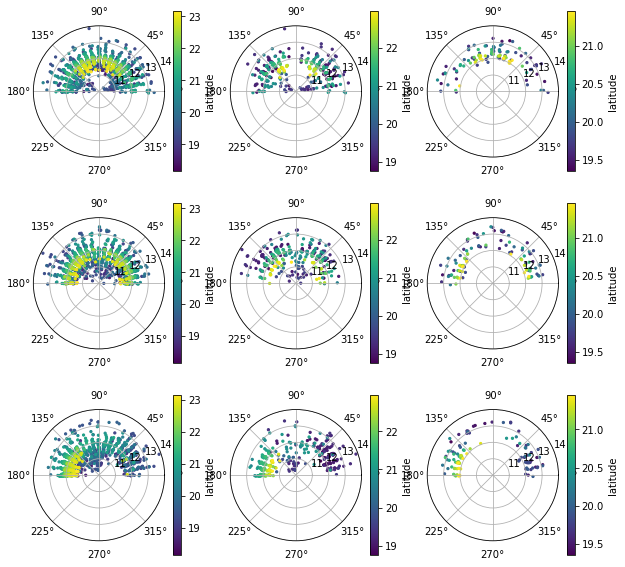

In [106]:
rmin,rmax = 10,14

S = 5
fig = plt.gcf()

plt.subplot(331,projection='polar')
p4 = plt.scatter(sub180diffa_longest_qnatotdir_slope+np.random.uniform(-2/180*np.pi,2/180*np.pi,np.shape(sub180diffa_longest_qnatotdir_slope)),np.log10(Tx_slope),c=Lat[1:,1:],s=S)
c4 = fig.colorbar(p4,label='latitude')
plt.ylim(rmin,rmax)

plt.subplot(332,projection='polar')
p4 = plt.scatter(sub180diffa_longest_qnatotdir_slope[np.any([morph==oblinds[i] for i in range(len(oblinds))],axis=0)]+np.random.uniform(-2/180*np.pi,2/180*np.pi,np.shape(sub180diffa_longest_qnatotdir_slope[np.any([morph==oblinds[i] for i in range(len(oblinds))],axis=0)])),
                 np.log10(Tx_slope)[np.any([morph==oblinds[i] for i in range(len(oblinds))],axis=0)],c=Lat[1:,1:][np.any([morph==oblinds[i] for i in range(len(oblinds))],axis=0)],s=S)
c4 = fig.colorbar(p4,label='latitude')
plt.ylim(rmin,rmax)

plt.subplot(333,projection='polar')
p4 = plt.scatter(sub180diffa_longest_qnatotdir_slope[morph==bsind]+np.random.uniform(-2/180*np.pi,2/180*np.pi,np.shape(sub180diffa_longest_qnatotdir_slope[morph==bsind])),
                 np.log10(Tx_slope)[morph==bsind],c=Lat[1:,1:][morph==bsind],s=S)
c4 = fig.colorbar(p4,label='latitude')
plt.ylim(rmin,rmax)

plt.subplot(334,projection='polar')
p4 = plt.scatter(sub180diffa_shortest_qnatotdir_slope+np.random.uniform(-2/180*np.pi,2/180*np.pi,np.shape(sub180diffa_shortest_qnatotdir_slope)),np.log10(Tx_slope),c=Lat[1:,1:],s=S)
c4 = fig.colorbar(p4,label='latitude')
plt.ylim(rmin,rmax)

plt.subplot(335,projection='polar')
p4 = plt.scatter(sub180diffa_shortest_qnatotdir_slope[np.any([morph==oblinds[i] for i in range(len(oblinds))],axis=0)]+np.random.uniform(-2/180*np.pi,2/180*np.pi,np.shape(sub180diffa_shortest_qnatotdir_slope[np.any([morph==oblinds[i] for i in range(len(oblinds))],axis=0)])),
                 np.log10(Tx_slope)[np.any([morph==oblinds[i] for i in range(len(oblinds))],axis=0)],c=Lat[1:,1:][np.any([morph==oblinds[i] for i in range(len(oblinds))],axis=0)],s=S)
c4 = fig.colorbar(p4,label='latitude')
plt.ylim(rmin,rmax)

plt.subplot(336,projection='polar')
p4 = plt.scatter(sub180diffa_shortest_qnatotdir_slope[morph==bsind]+np.random.uniform(-2/180*np.pi,2/180*np.pi,np.shape(sub180diffa_shortest_qnatotdir_slope[morph==bsind])),
                 np.log10(Tx_slope)[morph==bsind],c=Lat[1:,1:][morph==bsind],s=S)
c4 = fig.colorbar(p4,label='latitude')
plt.ylim(rmin,rmax)

plt.subplot(337,projection='polar')
p4 = plt.scatter(sub180diffa_steepest_qnatotdir_slope+np.random.uniform(-2/180*np.pi,2/180*np.pi,np.shape(sub180diffa_steepest_qnatotdir_slope)),np.log10(Tx_slope),c=Lat[1:,1:],s=S)
c4 = fig.colorbar(p4,label='latitude')
plt.ylim(rmin,rmax)

plt.subplot(338,projection='polar')
p4 = plt.scatter(sub180diffa_steepest_qnatotdir_slope[np.any([morph==oblinds[i] for i in range(len(oblinds))],axis=0)]+np.random.uniform(-2/180*np.pi,2/180*np.pi,np.shape(sub180diffa_steepest_qnatotdir_slope[np.any([morph==oblinds[i] for i in range(len(oblinds))],axis=0)])),
                 np.log10(Tx_slope)[np.any([morph==oblinds[i] for i in range(len(oblinds))],axis=0)],c=Lat[1:,1:][np.any([morph==oblinds[i] for i in range(len(oblinds))],axis=0)],s=S)
c4 = fig.colorbar(p4,label='latitude')
plt.ylim(rmin,rmax)

plt.subplot(339,projection='polar')
p4 = plt.scatter(sub180diffa_steepest_qnatotdir_slope[morph==bsind]+np.random.uniform(-2/180*np.pi,2/180*np.pi,np.shape(sub180diffa_steepest_qnatotdir_slope[morph==bsind])),
                 np.log10(Tx_slope)[morph==bsind],c=Lat[1:,1:][morph==bsind],s=S)
c4 = fig.colorbar(p4,label='latitude')
plt.ylim(rmin,rmax)

[Text(1, 0, 'B'),
 Text(1, 1, 'OB'),
 Text(1, 2, 'S'),
 Text(1, 3, 'OS'),
 Text(1, 4, 'D'),
 Text(1, 5, 'OD'),
 Text(1, 6, 'T'),
 Text(1, 7, 'TD'),
 Text(1, 8, 'BS')]

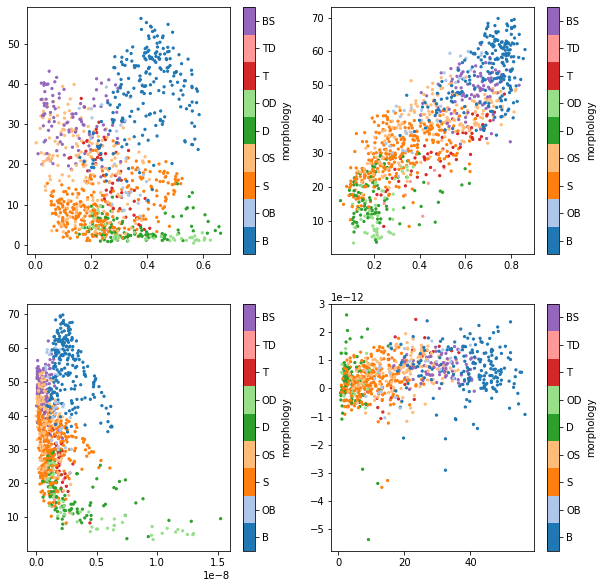

In [45]:
S = 5

fig = plt.gcf()

plt.subplot(221)
p1 = plt.scatter(qd_slope,equivalentthickness,c=morph,vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c1 = fig.colorbar(p1,ticks=np.arange(len(morphlist_abv)),label='morphology')
c1.ax.set_yticklabels(morphlist_abv)

plt.subplot(222)
p2 = plt.scatter(areafraction,equivalentthickness/areafraction,c=morph,vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c2 = fig.colorbar(p2,ticks=np.arange(len(morphlist_abv)),label='morphology')
c2.ax.set_yticklabels(morphlist_abv)

plt.subplot(223)
p3 = plt.scatter(migrationspeed_slope,equivalentthickness/areafraction,c=morph,vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c3 = fig.colorbar(p3,ticks=np.arange(len(morphlist_abv)),label='morphology')
c3.ax.set_yticklabels(morphlist_abv)

plt.subplot(224)
p4 = plt.scatter(equivalentthickness[1:-1,1:-1],np.mean(detadtflat_slope,axis=0),c=morph[1:-1,1:-1],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c4 = fig.colorbar(p4,ticks=np.arange(len(morphlist_abv)),label='morphology')
c4.ax.set_yticklabels(morphlist_abv)


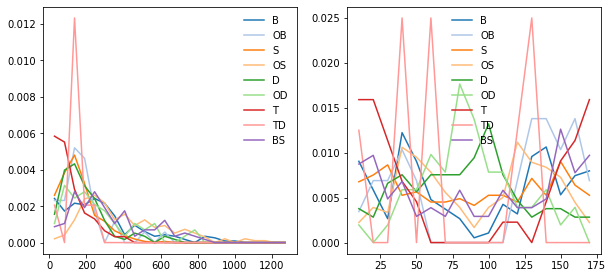

In [46]:
plt.subplot(221)
temp = bedformlength_qnatotdir_slope-np.min(bedformlengththeta,axis=2)
tempbins = np.linspace(0,1300,25)
tempbinmids = tempbins[1:]-np.diff(tempbins)[0]/2
for i in range(len(morphlist_abv)):
    c,_=np.histogram(temp[morph==i],bins=tempbins,density=True)
    plt.plot(tempbinmids,c,color=tab9(i),label=morphlist_abv[i])
plt.legend(frameon=False)

plt.subplot(222)
temp = sub180diffa_shortest_qnatotdir_slope*180/np.pi
tempbins = thetas[18:]*180/np.pi
tempbinmids = tempbins[1:]-np.diff(tempbins)[0]/2
for i in range(len(morphlist_abv)):
    c,_=np.histogram(temp[morph==i],bins=tempbins,density=True)
    plt.plot(tempbinmids,c,color=tab9(i),label=morphlist_abv[i])
plt.legend(frameon=False)

[Text(1, 0, 'B'),
 Text(1, 1, 'OB'),
 Text(1, 2, 'S'),
 Text(1, 3, 'OS'),
 Text(1, 4, 'D'),
 Text(1, 5, 'OD'),
 Text(1, 6, 'T'),
 Text(1, 7, 'TD'),
 Text(1, 8, 'BS')]

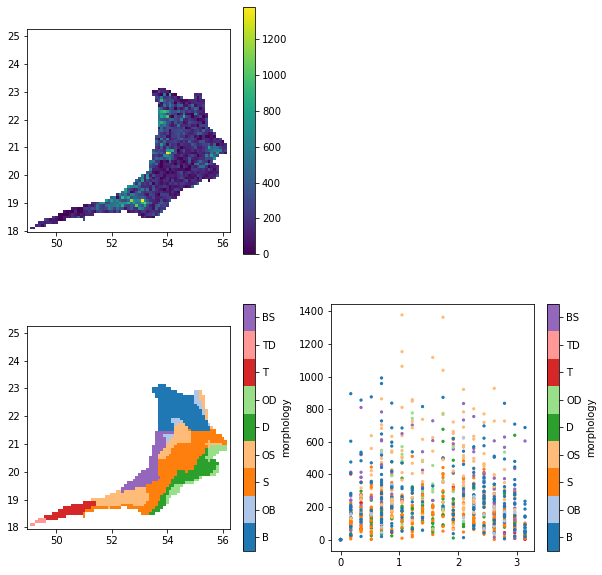

In [47]:
fig = plt.gcf()

plt.subplot(221)
plt.pcolormesh(templongrid,templatgrid,bedformlength_qnatotdir_slope-np.min(bedformlengththeta,axis=2))
plt.colorbar()
plt.axis('square')

plt.subplot(223)
p3 = plt.pcolormesh(templongrid,templatgrid,morph,vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9)
c3 = fig.colorbar(p3,ticks=np.arange(len(morphlist_abv)),label='morphology')
c3.ax.set_yticklabels(morphlist_abv)
plt.axis('square')

plt.subplot(224)
p4 = plt.scatter(sub180diffa_shortest_qnatotdir_slope,bedformlength_qnatotdir_slope-np.min(bedformlengththeta,axis=2),c=morph,vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c4 = fig.colorbar(p4,ticks=np.arange(len(morphlist_abv)),label='morphology')
c4.ax.set_yticklabels(morphlist_abv)

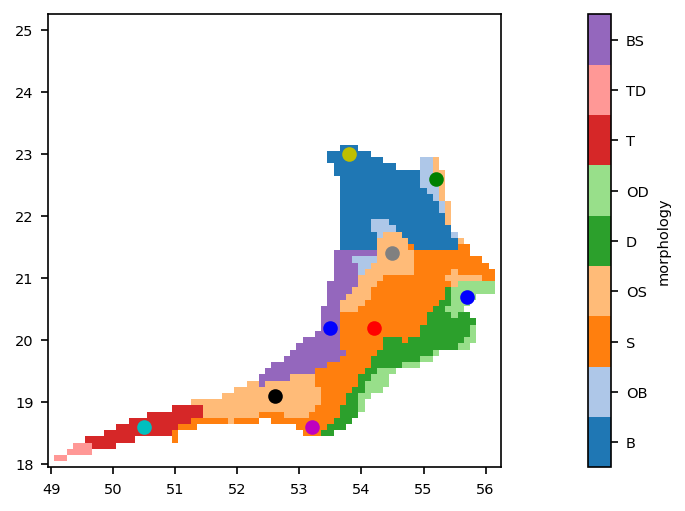

In [236]:
fig = plt.gcf()
p1 = plt.pcolormesh(templongrid,templatgrid,morph,vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9)
c1 = fig.colorbar(p1,ticks=np.arange(len(morphlist_abv)),label='morphology')
c1.ax.set_yticklabels(morphlist_abv)
plt.axis('square')

i1 = 15
j1 = 6
col1 = 'c'
plt.scatter(templongrid[i1],templatgrid[j1],c=col1)

i2 = 42
j2 = 6
col2 = 'm'
plt.scatter(templongrid[i2],templatgrid[j2],c=col2)

i3 = 48
j3 = 50
col3 = 'y'
plt.scatter(templongrid[i3],templatgrid[j3],c=col3)

i4 = 36
j4 = 11
col4 = 'k'
plt.scatter(templongrid[i4],templatgrid[j4],c=col4)

i5 = 52
j5 = 22
col5 = 'r'
plt.scatter(templongrid[i5],templatgrid[j5],c=col5)

i6 = 62
j6 = 46
col6 = 'g'
plt.scatter(templongrid[i6],templatgrid[j6],c=col6)

i7 = 67
j7 = 27
col7 = 'b'
plt.scatter(templongrid[i7],templatgrid[j7],c=col7)

i8 = 55
j8 = 34
col8 = 'grey'
plt.scatter(templongrid[i8],templatgrid[j8],c=col8)

i9 = 45
j9 = 22
col9 = 'b'
plt.scatter(templongrid[i9],templatgrid[j9],c=col9)

(-0.0045, 0.0045)

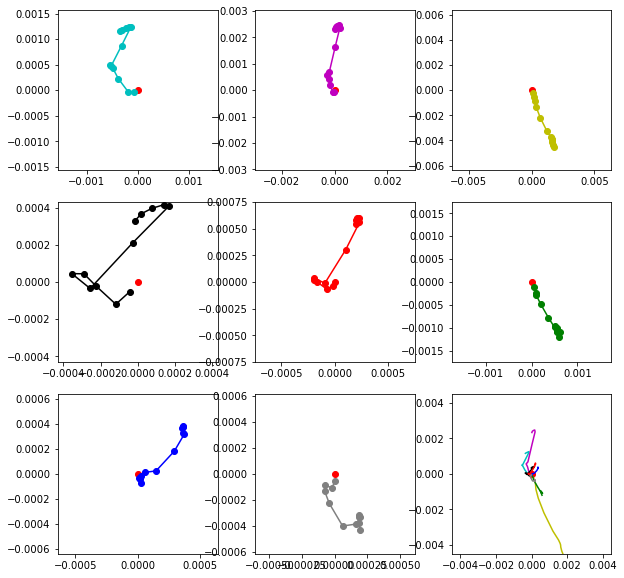

In [122]:
tempfactor = 1.3

plt.subplot(331)
plt.plot(np.cumsum(np.mean(qnx_slope[:,:,j1,i1],axis=0),axis=0),np.cumsum(np.mean(qny_slope[:,:,j1,i1],axis=0),axis=0),'-o',c=col1)
plt.scatter(0,0,c='r')
plt.axis('square')
amax = qnmtot_slope[j1,i1]*len(months)*tempfactor
amin = -amax
plt.xlim(amin,amax)
plt.ylim(amin,amax)

plt.subplot(332)
plt.plot(np.cumsum(np.mean(qnx_slope[:,:,j2,i2],axis=0),axis=0),np.cumsum(np.mean(qny_slope[:,:,j2,i2],axis=0),axis=0),'-o',c=col2)
plt.scatter(0,0,c='r')
plt.axis('square')
amax = qnmtot_slope[j2,i2]*len(months)*tempfactor
amin = -amax
plt.xlim(amin,amax)
plt.ylim(amin,amax)

plt.subplot(333)
plt.plot(np.cumsum(np.mean(qnx_slope[:,:,j3,i3],axis=0),axis=0),np.cumsum(np.mean(qny_slope[:,:,j3,i3],axis=0),axis=0),'-o',c=col3)
plt.scatter(0,0,c='r')
plt.axis('square')
amax = qnmtot_slope[j3,i3]*len(months)*tempfactor
amin = -amax
plt.xlim(amin,amax)
plt.ylim(amin,amax)

plt.subplot(334)
plt.plot(np.cumsum(np.mean(qnx_slope[:,:,j4,i4],axis=0),axis=0),np.cumsum(np.mean(qny_slope[:,:,j4,i4],axis=0),axis=0),'-o',c=col4)
plt.scatter(0,0,c='r')
plt.axis('square')
amax = qnmtot_slope[j4,i4]*len(months)*tempfactor
amin = -amax
plt.xlim(amin,amax)
plt.ylim(amin,amax)

plt.subplot(335)
plt.plot(np.cumsum(np.mean(qnx_slope[:,:,j5,i5],axis=0),axis=0),np.cumsum(np.mean(qny_slope[:,:,j5,i5],axis=0),axis=0),'-o',c=col5)
plt.scatter(0,0,c='r')
plt.axis('square')
amax = qnmtot_slope[j5,i5]*len(months)*tempfactor
amin = -amax
plt.xlim(amin,amax)
plt.ylim(amin,amax)

plt.subplot(336)
plt.plot(np.cumsum(np.mean(qnx_slope[:,:,j6,i6],axis=0),axis=0),np.cumsum(np.mean(qny_slope[:,:,j6,i6],axis=0),axis=0),'-o',c=col6)
plt.scatter(0,0,c='r')
plt.axis('square')
amax = qnmtot_slope[j6,i6]*len(months)*tempfactor
amin = -amax
plt.xlim(amin,amax)
plt.ylim(amin,amax)

plt.subplot(337)
plt.plot(np.cumsum(np.mean(qnx_slope[:,:,j7,i7],axis=0),axis=0),np.cumsum(np.mean(qny_slope[:,:,j7,i7],axis=0),axis=0),'-o',c=col7)
plt.scatter(0,0,c='r')
plt.axis('square')
amax = qnmtot_slope[j7,i7]*len(months)*tempfactor
amin = -amax
plt.xlim(amin,amax)
plt.ylim(amin,amax)

plt.subplot(338)
plt.plot(np.cumsum(np.mean(qnx_slope[:,:,j8,i8],axis=0),axis=0),np.cumsum(np.mean(qny_slope[:,:,j8,i8],axis=0),axis=0),'-o',c=col8)
plt.scatter(0,0,c='r')
plt.axis('square')
amax = qnmtot_slope[j8,i8]*len(months)*tempfactor
amin = -amax
plt.xlim(amin,amax)
plt.ylim(amin,amax)

plt.subplot(339)
plt.plot(np.cumsum(np.mean(qnx_slope[:,:,j1,i1],axis=0),axis=0),np.cumsum(np.mean(qny_slope[:,:,j1,i1],axis=0),axis=0),'-',c=col1)
plt.plot(np.cumsum(np.mean(qnx_slope[:,:,j2,i2],axis=0),axis=0),np.cumsum(np.mean(qny_slope[:,:,j2,i2],axis=0),axis=0),'-',c=col2)
plt.plot(np.cumsum(np.mean(qnx_slope[:,:,j3,i3],axis=0),axis=0),np.cumsum(np.mean(qny_slope[:,:,j3,i3],axis=0),axis=0),'-',c=col3)
plt.plot(np.cumsum(np.mean(qnx_slope[:,:,j4,i4],axis=0),axis=0),np.cumsum(np.mean(qny_slope[:,:,j4,i4],axis=0),axis=0),'-',c=col4)
plt.plot(np.cumsum(np.mean(qnx_slope[:,:,j5,i5],axis=0),axis=0),np.cumsum(np.mean(qny_slope[:,:,j5,i5],axis=0),axis=0),'-',c=col5)
plt.plot(np.cumsum(np.mean(qnx_slope[:,:,j6,i6],axis=0),axis=0),np.cumsum(np.mean(qny_slope[:,:,j6,i6],axis=0),axis=0),'-',c=col6)
plt.plot(np.cumsum(np.mean(qnx_slope[:,:,j7,i7],axis=0),axis=0),np.cumsum(np.mean(qny_slope[:,:,j7,i7],axis=0),axis=0),'-',c=col7)
plt.plot(np.cumsum(np.mean(qnx_slope[:,:,j8,i8],axis=0),axis=0),np.cumsum(np.mean(qny_slope[:,:,j8,i8],axis=0),axis=0),'-',c=col8)
plt.scatter(0,0,c='r')
plt.axis('square')
amax = 0.0045
amin = -amax
plt.xlim(amin,amax)
plt.ylim(amin,amax)

(-0.2, 0.2)

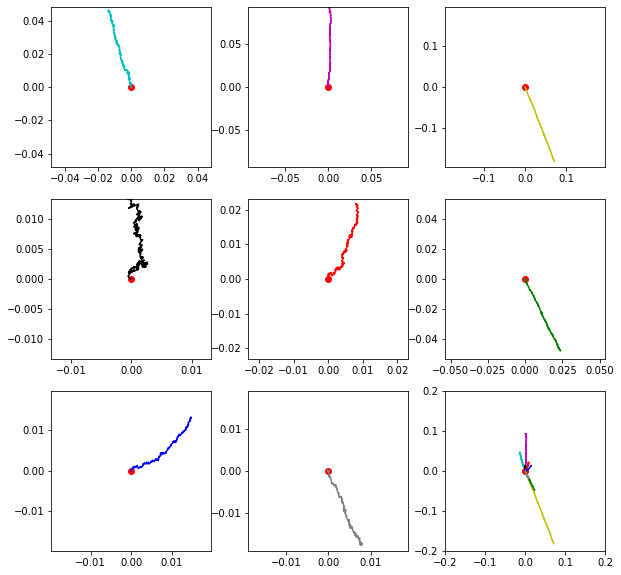

In [124]:
plt.subplot(331)
plt.plot(np.cumsum(qnxflat_slope[:,j1,i1],axis=0),np.cumsum(qnyflat_slope[:,j1,i1],axis=0),c=col1)
plt.scatter(0,0,c='r')
plt.axis('square')
amax = qnmtot_slope[j1,i1]*len(years)*len(months)
amin = -amax
plt.xlim(amin,amax)
plt.ylim(amin,amax)

plt.subplot(332)
plt.plot(np.cumsum(qnxflat_slope[:,j2,i2],axis=0),np.cumsum(qnyflat_slope[:,j2,i2],axis=0),c=col2)
plt.scatter(0,0,c='r')
plt.axis('square')
amax = qnmtot_slope[j2,i2]*len(years)*len(months)
amin = -amax
plt.xlim(amin,amax)
plt.ylim(amin,amax)

plt.subplot(333)
plt.plot(np.cumsum(qnxflat_slope[:,j3,i3],axis=0),np.cumsum(qnyflat_slope[:,j3,i3],axis=0),c=col3)
plt.scatter(0,0,c='r')
plt.axis('square')
amax = qnmtot_slope[j3,i3]*len(years)*len(months)
amin = -amax
plt.xlim(amin,amax)
plt.ylim(amin,amax)

plt.subplot(334)
plt.plot(np.cumsum(qnxflat_slope[:,j4,i4],axis=0),np.cumsum(qnyflat_slope[:,j4,i4],axis=0),c=col4)
plt.scatter(0,0,c='r')
plt.axis('square')
amax = qnmtot_slope[j4,i4]*len(years)*len(months)
amin = -amax
plt.xlim(amin,amax)
plt.ylim(amin,amax)

plt.subplot(335)
plt.plot(np.cumsum(qnxflat_slope[:,j5,i5],axis=0),np.cumsum(qnyflat_slope[:,j5,i5],axis=0),c=col5)
plt.scatter(0,0,c='r')
plt.axis('square')
amax = qnmtot_slope[j5,i5]*len(years)*len(months)
amin = -amax
plt.xlim(amin,amax)
plt.ylim(amin,amax)

plt.subplot(336)
plt.plot(np.cumsum(qnxflat_slope[:,j6,i6],axis=0),np.cumsum(qnyflat_slope[:,j6,i6],axis=0),c=col6)
plt.scatter(0,0,c='r')
plt.axis('square')
amax = qnmtot_slope[j6,i6]*len(years)*len(months)
amin = -amax
plt.xlim(amin,amax)
plt.ylim(amin,amax)

plt.subplot(337)
plt.plot(np.cumsum(qnxflat_slope[:,j7,i7],axis=0),np.cumsum(qnyflat_slope[:,j7,i7],axis=0),c=col7)
plt.scatter(0,0,c='r')
plt.axis('square')
amax = qnmtot_slope[j7,i7]*len(years)*len(months)
amin = -amax
plt.xlim(amin,amax)
plt.ylim(amin,amax)

plt.subplot(338)
plt.plot(np.cumsum(qnxflat_slope[:,j8,i8],axis=0),np.cumsum(qnyflat_slope[:,j8,i8],axis=0),c=col8)
plt.scatter(0,0,c='r')
plt.axis('square')
amax = qnmtot_slope[j8,i8]*len(years)*len(months)
amin = -amax
plt.xlim(amin,amax)
plt.ylim(amin,amax)

plt.subplot(339)
plt.plot(np.cumsum(qnxflat_slope[:,j1,i1],axis=0),np.cumsum(qnyflat_slope[:,j1,i1],axis=0),c=col1)
plt.plot(np.cumsum(qnxflat_slope[:,j2,i2],axis=0),np.cumsum(qnyflat_slope[:,j2,i2],axis=0),c=col2)
plt.plot(np.cumsum(qnxflat_slope[:,j3,i3],axis=0),np.cumsum(qnyflat_slope[:,j3,i3],axis=0),c=col3)
plt.plot(np.cumsum(qnxflat_slope[:,j4,i4],axis=0),np.cumsum(qnyflat_slope[:,j4,i4],axis=0),c=col4)
plt.plot(np.cumsum(qnxflat_slope[:,j5,i5],axis=0),np.cumsum(qnyflat_slope[:,j5,i5],axis=0),c=col5)
plt.plot(np.cumsum(qnxflat_slope[:,j6,i6],axis=0),np.cumsum(qnyflat_slope[:,j6,i6],axis=0),c=col6)
plt.plot(np.cumsum(qnxflat_slope[:,j7,i7],axis=0),np.cumsum(qnyflat_slope[:,j7,i7],axis=0),c=col7)
plt.plot(np.cumsum(qnxflat_slope[:,j8,i8],axis=0),np.cumsum(qnyflat_slope[:,j8,i8],axis=0),c=col8)
plt.scatter(0,0,c='r')
plt.axis('square')
amax = 0.2
amin = -amax
plt.xlim(amin,amax)
plt.ylim(amin,amax)

In [50]:
np.nanmean(Tz_slope)/yr_to_s*1e-6 #average accumulation time is 1.2 million years

1.2111124850008863

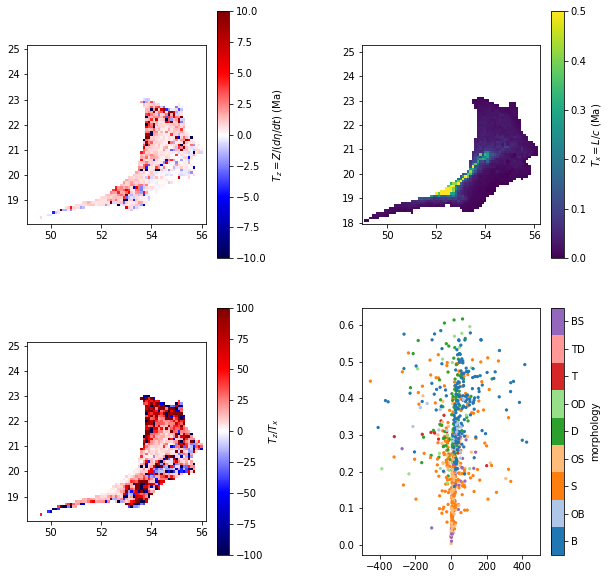

In [51]:
S = 5

fig = plt.gcf()

plt.subplot(221)
plt.pcolormesh(templongrid[1:-1],templatgrid[1:-1],Tz_slope*s_to_ma,vmin=-1e+1,vmax=1e+1,cmap='seismic')
plt.colorbar(label='$T_z=Z/(d\eta/dt)$ (Ma)')
plt.axis('square')

plt.subplot(222)
plt.pcolormesh(templongrid,templatgrid,Tx_slope*s_to_ma,vmin=0,vmax=0.5)
plt.colorbar(label='$T_x=L/c$ (Ma)')
plt.axis('square')

plt.subplot(223)
plt.pcolormesh(templongrid[1:-1],templatgrid[1:-1],M_slope,vmin=-1e+2,vmax=1e+2,cmap='seismic')
plt.colorbar(label='$T_z/T_x$')
plt.axis('square')

plt.subplot(224)
p4 = plt.scatter(M_slope,qnmtot_slope[1:-1,1:-1]/qamtot_slope[1:-1,1:-1],c=morph[1:-1,1:-1],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c4 = fig.colorbar(p4,ticks=np.arange(len(morphlist_abv)),label='morphology')
c4.ax.set_yticklabels(morphlist_abv)
plt.xlim(-5e+2,5e+2)

plt.subplots_adjust(wspace=0.5)

In [52]:
advect_timescale = np.nansum((Lx*Ly*areafraction/areafraction))**0.5/np.nanmean(migrationspeed_slope)
accumu_timescale = np.nanmean(equivalentthickness)/np.nanmean(detadt_slope)

print("{:.2e}".format(advect_timescale/yr_to_s))
print("{:.2e}".format(accumu_timescale/yr_to_s))
print(advect_timescale/accumu_timescale)
# the average time for dune to migrate across the field is ~5 times longer than the average accumulation time

6.04e+06
1.28e+06
4.727712954170958


In [53]:
print("{:.2e}".format(40*yr_to_s*np.nanmean(migrationspeed_slope)/np.nanmean((Lx*Ly*areafraction/areafraction))**0.5))
# distance bedforms migrate within the observation period is ~0.02% of the grid spacing, so fine to use quasi-static topography

2.14e-04


In [54]:
dfvolume = np.nansum(equivalentthickness*Lx*Ly)
print("{:.2e}".format(dfvolume))

2.30e+12


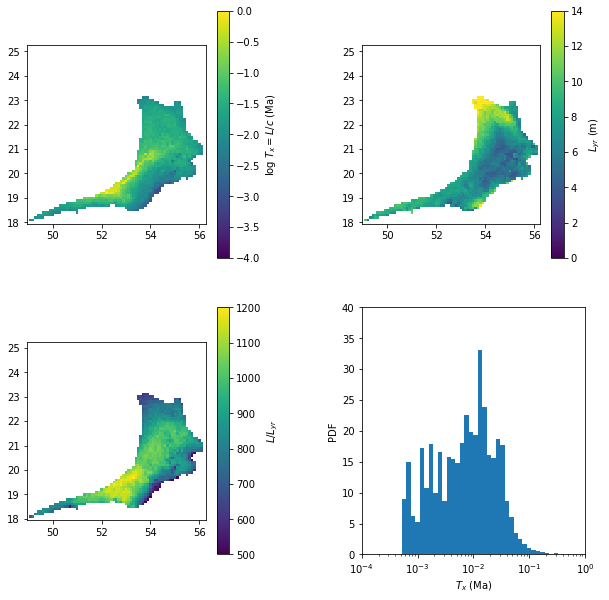

In [55]:
plt.subplot(221)
plt.pcolormesh(templongrid,templatgrid,np.log10(Tx_slope*s_to_ma),vmin=-4,vmax=0)
plt.colorbar(label='log $T_x=L/c$ (Ma)')
plt.axis('square')

plt.subplot(222)
plt.pcolormesh(templongrid,templatgrid,Lyr_slope,vmin=0,vmax=14)
plt.colorbar(label='$L_{yr}$ (m)')
plt.axis('square')

plt.subplot(223)
plt.pcolormesh(templongrid,templatgrid,(Lx*Ly*areafraction)**0.5/Lyr_slope,vmin=500,vmax=1200)
plt.colorbar(label='$L/L_{yr}$')
plt.axis('square')

plt.subplot(224)
tempbx = np.logspace(-4,0,51)
plt.hist(np.ndarray.flatten(Tx_slope)*s_to_ma,bins=tempbx,density=True)

plt.xscale('log')
plt.xlim(1e-4,1e+0)
plt.ylim(0,40)
plt.ylabel('PDF')
plt.xlabel('$T_x$ (Ma)')

plt.subplots_adjust(wspace=0.5)

(49.05, 56.5618902285, 17.795700632, 25.3075908605)

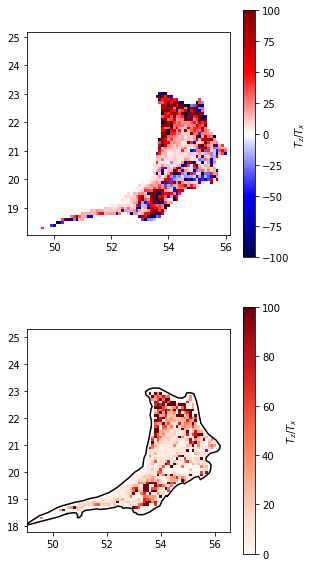

In [56]:
plt.subplot(221)
plt.pcolormesh(templongrid[1:-1],templatgrid[1:-1],M_slope,vmin=-1e+2,vmax=1e+2,cmap='seismic')
plt.colorbar(label='$T_z/T_x$')
plt.axis('square')

plt.subplot(223)
plt.pcolormesh(templongrid[1:-1],templatgrid[1:-1],M_slope,vmin=0,vmax=1e+2,cmap='Reds')
plt.colorbar(label='$T_z/T_x$')
plt.plot(*dfpoly.exterior.xy,c='k')
plt.axis('square')

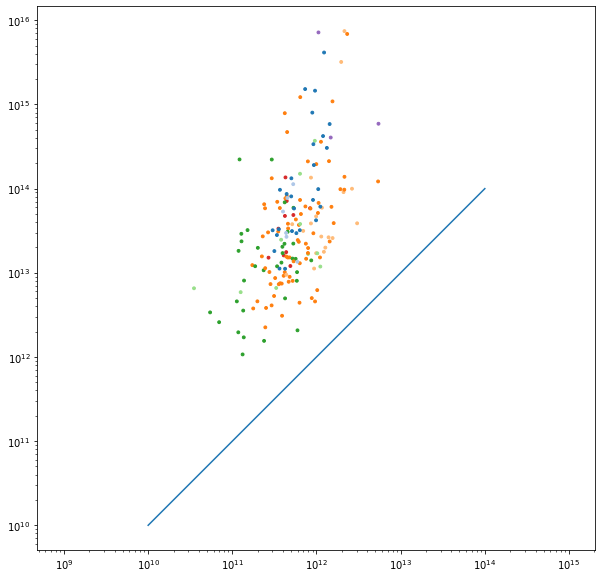

In [223]:
plt.scatter(Tx_slope[1:-1,1:-1],-Tz_slope,c=morph[1:-1,1:-1],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
plt.plot([1e+10,1e+14],[1e+10,1e+14])
c4 = fig.colorbar(p4,ticks=np.arange(len(morphlist_abv)),label='morphology')
c4.ax.set_yticklabels(morphlist_abv)
plt.axis('equal')
plt.xscale('log')
plt.yscale('log')

Text(0, 0.5, '$\\eta$')

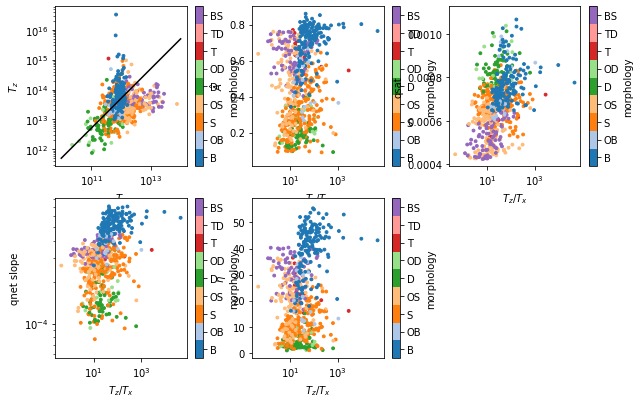

In [217]:
S = 8
fig = plt.gcf()

plt.subplot(331)
p4 = plt.scatter(Tx_slope[1:-1,1:-1],Tz_slope,c=morph[1:-1,1:-1],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c4 = fig.colorbar(p4,ticks=np.arange(len(morphlist_abv)),label='morphology')
c4.ax.set_yticklabels(morphlist_abv)
tempx = np.asarray([1e+10,1e+14])
plt.plot(tempx,tempx*50,'k')
plt.axis('equal')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$T_x$')
plt.ylabel('$T_z$')

plt.subplot(332)
p4 = plt.scatter(M_slope,areafraction[1:-1,1:-1],c=morph[1:-1,1:-1],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c4 = fig.colorbar(p4,ticks=np.arange(len(morphlist_abv)),label='morphology')
c4.ax.set_yticklabels(morphlist_abv)
plt.xscale('log')
plt.xlabel('$T_z/T_x$')
plt.ylabel('$\\hat{A}$')

plt.subplot(333)
p4 = plt.scatter(M_slope,qamtot[1:-1,1:-1],c=morph[1:-1,1:-1],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c4 = fig.colorbar(p4,ticks=np.arange(len(morphlist_abv)),label='morphology')
c4.ax.set_yticklabels(morphlist_abv)
plt.xscale('log')
plt.xlabel('$T_z/T_x$')
plt.ylabel('qsat')

plt.subplot(334)
p4 = plt.scatter(M_slope,qamtot_slope[1:-1,1:-1],c=morph[1:-1,1:-1],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c4 = fig.colorbar(p4,ticks=np.arange(len(morphlist_abv)),label='morphology')
c4.ax.set_yticklabels(morphlist_abv)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$T_z/T_x$')
plt.ylabel('qnet slope')

plt.subplot(335)
p4 = plt.scatter(M_slope,equivalentthickness[1:-1,1:-1],c=morph[1:-1,1:-1],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c4 = fig.colorbar(p4,ticks=np.arange(len(morphlist_abv)),label='morphology')
c4.ax.set_yticklabels(morphlist_abv)
plt.xscale('log')
plt.xlabel('$T_z/T_x$')
plt.ylabel('$\\eta$')

Text(0, 0.5, 'qabssat')

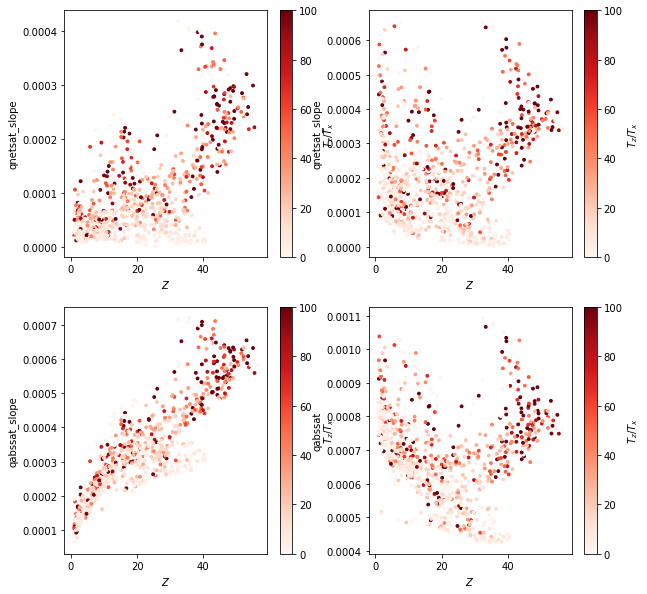

In [58]:
plt.subplot(221)
p4 = plt.scatter(equivalentthickness[1:-1,1:-1],qnmtot_slope[1:-1,1:-1],c=M_slope,vmin=0,vmax=1e+2,cmap='Reds',s=S)
plt.colorbar(label='$T_z/T_x$')
plt.xlabel('$Z$')
plt.ylabel('qnetsat_slope')

plt.subplot(222)
p4 = plt.scatter(equivalentthickness[1:-1,1:-1],qnmtot[1:-1,1:-1],c=M_slope,vmin=0,vmax=1e+2,cmap='Reds',s=S)
plt.colorbar(label='$T_z/T_x$')
plt.xlabel('$Z$')
plt.ylabel('qnetsat_slope')

plt.subplot(223)
p4 = plt.scatter(equivalentthickness[1:-1,1:-1],qamtot_slope[1:-1,1:-1],c=M_slope,vmin=0,vmax=1e+2,cmap='Reds',s=S)
plt.colorbar(label='$T_z/T_x$')
plt.xlabel('$Z$')
plt.ylabel('qabssat_slope')

plt.subplot(224)
p4 = plt.scatter(equivalentthickness[1:-1,1:-1],qamtot[1:-1,1:-1],c=M_slope,vmin=0,vmax=1e+2,cmap='Reds',s=S)
plt.colorbar(label='$T_z/T_x$')
plt.xlabel('$Z$')
plt.ylabel('qabssat')

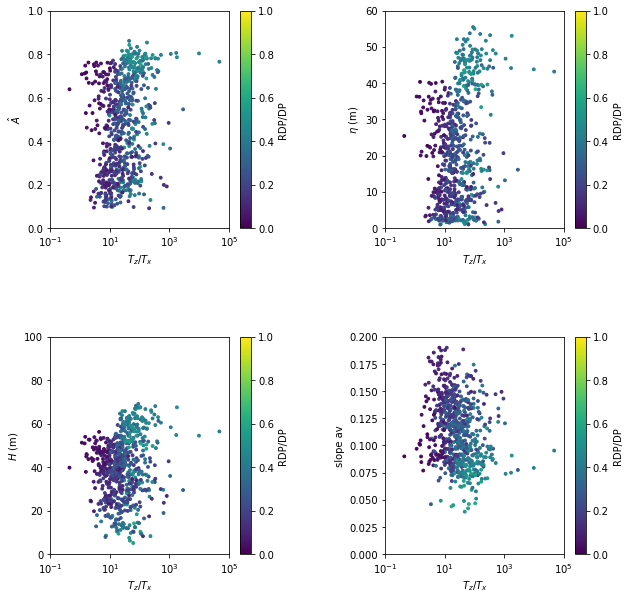

In [59]:
qd_lim = 0

plt.subplot(221)
plt.scatter(M_slope[qd_slope[1:-1,1:-1]>qd_lim],areafraction[1:-1,1:-1][qd_slope[1:-1,1:-1]>qd_lim],c=qd_slope[1:-1,1:-1][qd_slope[1:-1,1:-1]>qd_lim],vmin=qd_lim,vmax=1,s=S)
plt.colorbar(label='RDP/DP')
plt.xscale('log')
plt.xlim(1e-1,1e+5)
# plt.xlim(0,1000)
plt.ylim(0,1)
plt.xlabel('$T_z/T_x$')
plt.ylabel('$\\hat{A}$')

plt.subplot(222)
plt.scatter(M_slope[qd_slope[1:-1,1:-1]>qd_lim],equivalentthickness[1:-1,1:-1][qd_slope[1:-1,1:-1]>qd_lim],c=qd_slope[1:-1,1:-1][qd_slope[1:-1,1:-1]>qd_lim],vmin=qd_lim,vmax=1,s=S)
plt.colorbar(label='RDP/DP')
plt.xscale('log')
plt.xlim(1e-1,1e+5)
plt.ylim(0,60)
plt.xlabel('$T_z/T_x$')
plt.ylabel('$\\eta$ (m)')

plt.subplot(223)
plt.scatter(M_slope[qd_slope[1:-1,1:-1]>qd_lim],equivalentthickness[1:-1,1:-1][qd_slope[1:-1,1:-1]>qd_lim]/areafraction[1:-1,1:-1][qd_slope[1:-1,1:-1]>qd_lim],c=qd_slope[1:-1,1:-1][qd_slope[1:-1,1:-1]>qd_lim],vmin=qd_lim,vmax=1,s=S)
plt.colorbar(label='RDP/DP')
plt.xscale('log')
plt.xlim(1e-1,1e+5)
plt.ylim(0,100)
plt.xlabel('$T_z/T_x$')
plt.ylabel('$H$ (m)')

plt.subplot(224)
plt.scatter(M_slope[qd_slope[1:-1,1:-1]>qd_lim],np.mean(lengthweightedslopetheta,axis=2)[1:-1,1:-1][qd_slope[1:-1,1:-1]>qd_lim],c=qd_slope[1:-1,1:-1][qd_slope[1:-1,1:-1]>qd_lim],vmin=qd_lim,vmax=1,s=S)
plt.colorbar(label='RDP/DP')
plt.xscale('log')
plt.xlim(1e-1,1e+5)
plt.ylim(0,0.2)
plt.xlabel('$T_z/T_x$')
plt.ylabel('slope av')

plt.subplots_adjust(wspace=0.5,hspace=0.5)

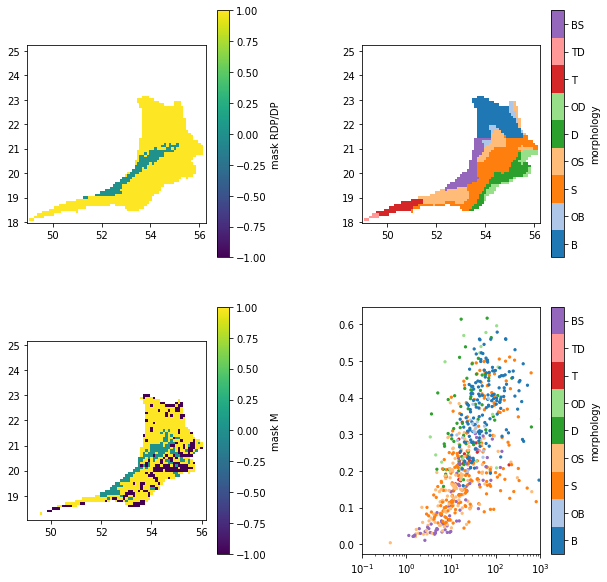

In [60]:
S = 5

fig = plt.gcf()

plt.subplot(221)

qd_lim = 0.1
temp = np.copy(qd_slope)
temp[qd_slope<qd_lim] = 0
temp[qd_slope>=qd_lim] = 1

plt.pcolormesh(templongrid,templatgrid,temp,vmin=-1,vmax=1)
plt.colorbar(label='mask RDP/DP')
plt.axis('square')

plt.subplot(222)
p2 = plt.pcolormesh(templongrid,templatgrid,morph,vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9)
c2 = fig.colorbar(p2,ticks=np.arange(len(morphlist_abv)),label='morphology')
plt.axis('square')
c2.ax.set_yticklabels(morphlist_abv)

plt.subplot(223)

M_lim = 10
temp = np.copy(M_slope)
temp[M_slope< M_lim] = 0
temp[M_slope>=M_lim] = 1
temp[M_slope<0] = -1

plt.pcolormesh(templongrid[1:-1],templatgrid[1:-1],temp,vmin=-1,vmax=1)
plt.colorbar(label='mask M')
plt.axis('square')

plt.subplot(224)
p4 = plt.scatter(M_slope,qd_slope[1:-1,1:-1],c=morph[1:-1,1:-1],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c4 = fig.colorbar(p4,ticks=np.arange(len(morphlist_abv)),label='morphology')
c4.ax.set_yticklabels(morphlist_abv)
plt.xscale('log')
plt.xlim(1e-1,1e+3)

plt.subplots_adjust(wspace=0.5)

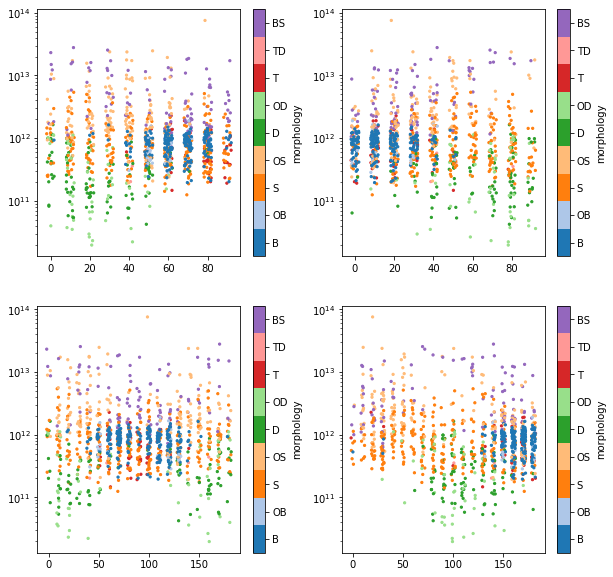

In [62]:
S = 5

fig = plt.gcf()

plt.subplot(221)
p4 = plt.scatter(sub90diffa_longest_qnatotdir_slope*180/np.pi+np.random.uniform(-2,2,np.shape(sub90diffa_longest_qnatotdir_slope)),Tx_slope,c=morph,vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c4 = fig.colorbar(p4,ticks=np.arange(len(morphlist_abv)),label='morphology')
c4.ax.set_yticklabels(morphlist_abv)
plt.yscale('log')

plt.subplot(222)
p4 = plt.scatter(sub90diffa_steepest_qnatotdir_slope*180/np.pi+np.random.uniform(-2,2,np.shape(sub90diffa_steepest_qnatotdir_slope)),Tx_slope,c=morph,vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c4 = fig.colorbar(p4,ticks=np.arange(len(morphlist_abv)),label='morphology')
c4.ax.set_yticklabels(morphlist_abv)
plt.yscale('log')

plt.subplot(223)
p4 = plt.scatter(sub180diffa_longest_qnatotdir_slope*180/np.pi+np.random.uniform(-2,2,np.shape(sub180diffa_longest_qnatotdir_slope)),Tx_slope,c=morph,vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c4 = fig.colorbar(p4,ticks=np.arange(len(morphlist_abv)),label='morphology')
c4.ax.set_yticklabels(morphlist_abv)
plt.yscale('log')

plt.subplot(224)
p4 = plt.scatter(sub180diffa_steepest_qnatotdir_slope*180/np.pi+np.random.uniform(-2,2,np.shape(sub180diffa_steepest_qnatotdir_slope)),Tx_slope,c=morph,vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c4 = fig.colorbar(p4,ticks=np.arange(len(morphlist_abv)),label='morphology')
c4.ax.set_yticklabels(morphlist_abv)
plt.yscale('log')

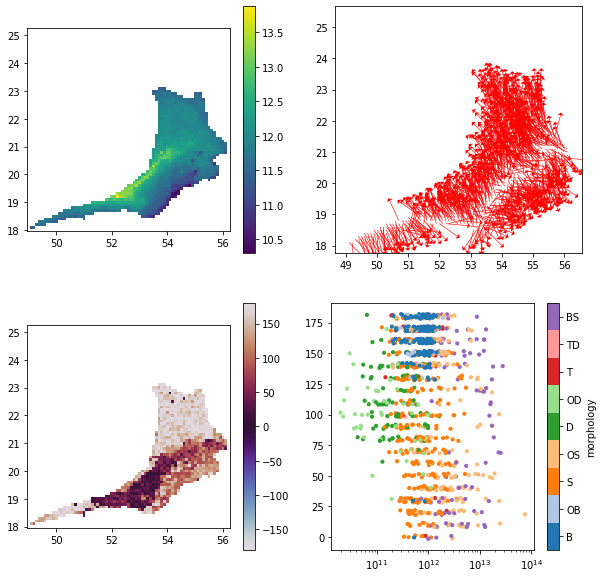

In [63]:
S = 10

fig = plt.gcf()

plt.subplot(221)
plt.pcolormesh(templongrid,templatgrid,np.log10(Tx_slope))
plt.axis('square')
plt.colorbar()

plt.subplot(222)
plt.quiver(templongrid,templatgrid,np.cos(thetasteepest),np.sin(thetasteepest),scale=1e+1,color='r',headwidth=10)
plt.axis('square')

plt.subplot(223)
plt.pcolormesh(templongrid,templatgrid,sub180diffa_steepest_qnatotdir_slope*180/np.pi,vmin=-180,vmax=180,cmap='twilight')
plt.colorbar()
plt.axis('square')

plt.subplot(224)
p4 = plt.scatter(Tx_slope,sub180diffa_steepest_qnatotdir_slope*180/np.pi+np.random.uniform(-2,2,np.shape(sub180diffa_steepest_qnatotdir_slope)),c=morph,vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c4 = fig.colorbar(p4,ticks=np.arange(len(morphlist_abv)),label='morphology')
c4.ax.set_yticklabels(morphlist_abv)
plt.xscale('log')

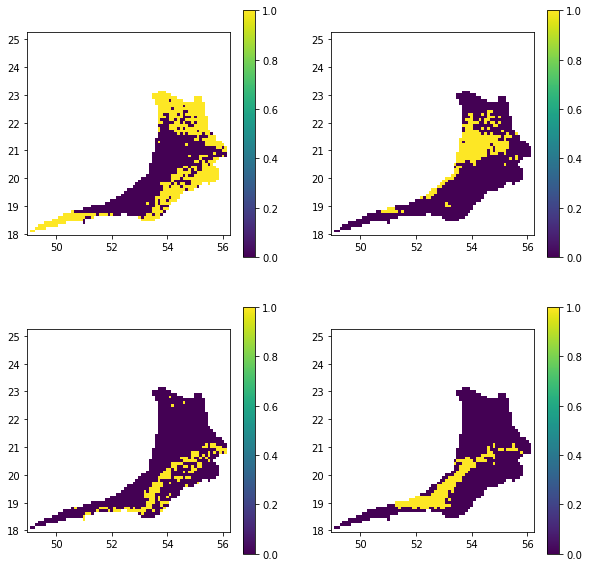

In [64]:
thetabound = 90
Txbound = 1e+12

temp = areafraction/areafraction-1
temp[(sub180diffa_steepest_qnatotdir_slope*180/np.pi>thetabound)&(Tx_slope<Txbound)] = 1

plt.subplot(221)
plt.pcolormesh(templongrid,templatgrid,temp)
plt.axis('square')
plt.colorbar()

temp = areafraction/areafraction-1
temp[(sub180diffa_steepest_qnatotdir_slope*180/np.pi>thetabound)&(Tx_slope>Txbound)] = 1

plt.subplot(222)
plt.pcolormesh(templongrid,templatgrid,temp)
plt.axis('square')
plt.colorbar()

temp = areafraction/areafraction-1
temp[(sub180diffa_steepest_qnatotdir_slope*180/np.pi<thetabound)&(Tx_slope<Txbound)] = 1

plt.subplot(223)
plt.pcolormesh(templongrid,templatgrid,temp)
plt.axis('square')
plt.colorbar()

temp = areafraction/areafraction-1
temp[(sub180diffa_steepest_qnatotdir_slope*180/np.pi<thetabound)&(Tx_slope>Txbound)] = 1

plt.subplot(224)
plt.pcolormesh(templongrid,templatgrid,temp)
plt.axis('square')
plt.colorbar()

In [65]:
latbound = 21.5

Tc = areafraction/areafraction
Tc[Lat[1:,1:] >latbound] = 1e+4*yr_to_s
Tc[Lat[1:,1:]<=latbound] = 1e+3*yr_to_s

Mtemp = Tx_slope/Tc

/local/k10/ag5517/tmp/ipykernel_1320372/398897089.py:3: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  c4 = fig.colorbar(p4,ticks=np.arange(len(morphlist_abv)),label='morphology')


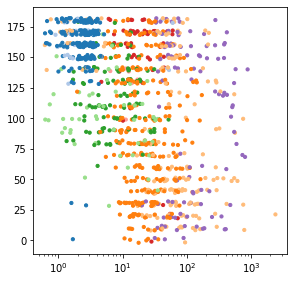

In [66]:
plt.subplot(221)
p4 = plt.scatter(Mtemp,sub180diffa_steepest_qnatotdir_slope*180/np.pi+np.random.uniform(-2,2,np.shape(sub180diffa_steepest_qnatotdir_slope)),c=morph,vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,s=S)
c4 = fig.colorbar(p4,ticks=np.arange(len(morphlist_abv)),label='morphology')
c4.ax.set_yticklabels(morphlist_abv)
plt.xscale('log')

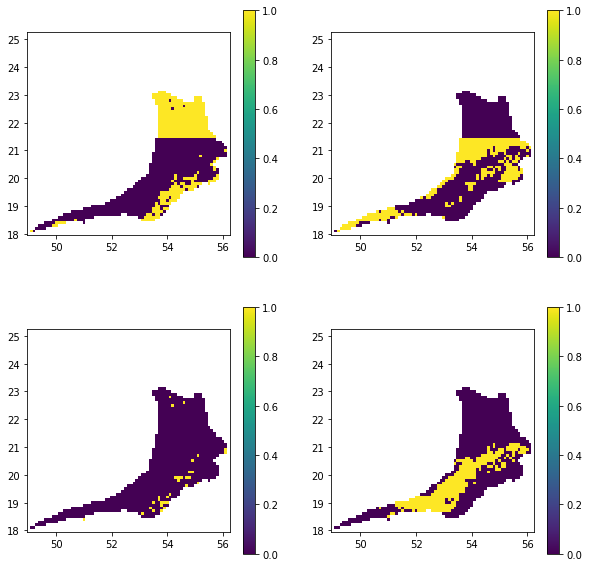

In [67]:
thetabound = 90
Mbound = 1e+1

temp = areafraction/areafraction-1
temp[(sub180diffa_steepest_qnatotdir_slope*180/np.pi>thetabound)&(Mtemp<Mbound)] = 1

plt.subplot(221)
plt.pcolormesh(templongrid,templatgrid,temp)
plt.axis('square')
plt.colorbar()

temp = areafraction/areafraction-1
temp[(sub180diffa_steepest_qnatotdir_slope*180/np.pi>thetabound)&(Mtemp>Mbound)] = 1

plt.subplot(222)
plt.pcolormesh(templongrid,templatgrid,temp)
plt.axis('square')
plt.colorbar()

temp = areafraction/areafraction-1
temp[(sub180diffa_steepest_qnatotdir_slope*180/np.pi<thetabound)&(Mtemp<Mbound)] = 1

plt.subplot(223)
plt.pcolormesh(templongrid,templatgrid,temp)
plt.axis('square')
plt.colorbar()

temp = areafraction/areafraction-1
temp[(sub180diffa_steepest_qnatotdir_slope*180/np.pi<thetabound)&(Mtemp>Mbound)] = 1

plt.subplot(224)
plt.pcolormesh(templongrid,templatgrid,temp)
plt.axis('square')
plt.colorbar()

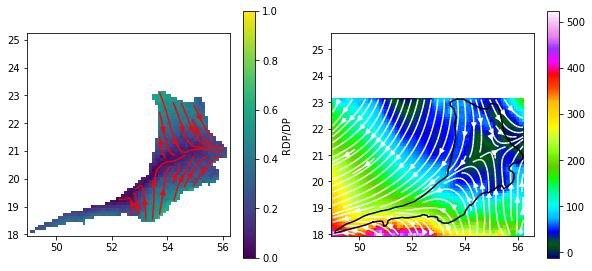

In [68]:
plt.subplot(221)
plt.pcolormesh(templongrid,templatgrid,qd_slope,vmin=0,vmax=1,cmap='viridis')
plt.colorbar(label='RDP/DP')
plt.streamplot(templongrid,templatgrid,qnxtot_slope,qnytot_slope,color='r')
plt.axis('square')

plt.subplot(222)
plt.pcolormesh(templongrid,templatgrid,basemap-basemap_dfmin,cmap='gist_ncar')
plt.colorbar()
plt.streamplot(templongrid,templatgrid,np.mean(uav,axis=(0,1)),np.mean(vav,axis=(0,1)),color='w')
plt.axis('square')
plt.plot(*dfpoly.exterior.xy,c='k')

(41.95, 56.25000000000004, 17.95, 32.25000000000004)

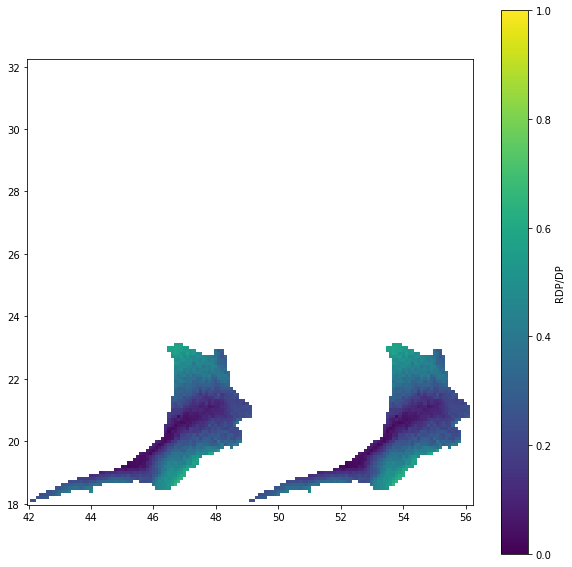

In [212]:
plt.pcolormesh(templongrid,templatgrid,qd_slope,vmin=0,vmax=1,cmap='viridis')
plt.pcolormesh(templongrid-7,templatgrid,qd_slope,vmin=0,vmax=1,cmap='viridis')
plt.colorbar(label='RDP/DP')
plt.axis('square')


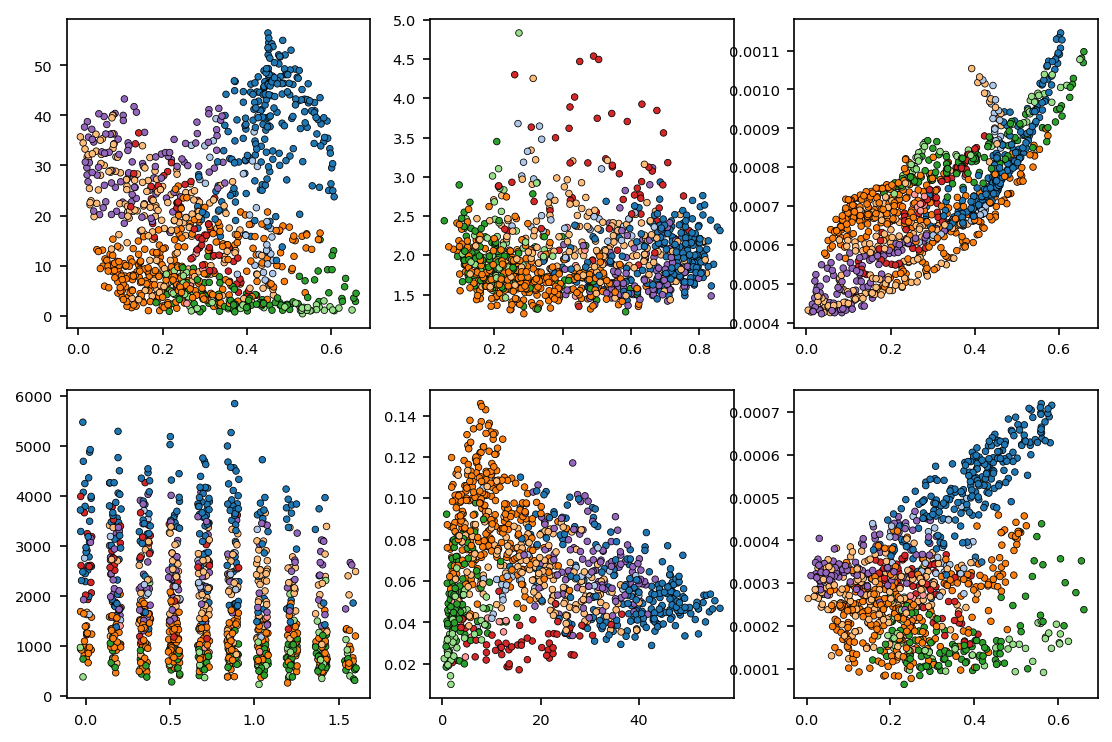

In [85]:
lw = 0.5
ss = 10

plt.figure(figsize=(12,6))

plt.subplot(241)
tempxx = np.ndarray.flatten(qd)
tempyy = np.ndarray.flatten(equivalentthickness)
tempzz = np.ndarray.flatten(morph)
randinds = np.arange(len(tempxx))
np.random.shuffle(randinds)
p1 = plt.scatter(tempxx[randinds],tempyy[randinds],lw=lw*0.75,s=ss,c=tempzz[randinds],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,edgecolor='k')
# plt.xlim(0,0.7)
# plt.ylim(0,60)

plt.subplot(245)
tempxx = np.ndarray.flatten(np.ndarray.flatten(sub90diffa_shortest_qnatotdir_slope+np.random.uniform(-2/180*np.pi,2/180*np.pi,np.shape(sub90diffa_shortest_qnatotdir_slope))))
tempyy = np.ndarray.flatten(np.max(bedformlengththeta,axis=2))
tempzz = np.ndarray.flatten(morph)
randinds = np.arange(len(tempxx))
np.random.shuffle(randinds)
p1 = plt.scatter(tempxx[randinds],tempyy[randinds],lw=lw*0.75,s=ss,c=tempzz[randinds],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,edgecolor='k')
# plt.xlim(0,0.7)
# plt.ylim(0,60)

plt.subplot(242)
tempxx = np.ndarray.flatten(areafraction)
tempyy = np.ndarray.flatten(np.max(bedformlengththeta,axis=2)/np.min(bedformlengththeta,axis=2))
tempzz = np.ndarray.flatten(morph)
randinds = np.arange(len(tempxx))
np.random.shuffle(randinds)
p1 = plt.scatter(tempxx[randinds],tempyy[randinds],lw=lw*0.75,s=ss,c=tempzz[randinds],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,edgecolor='k')
# plt.xlim(0,np.pi)
# plt.ylim(0,60)

plt.subplot(243)
tempxx = np.ndarray.flatten(qd)
tempyy = np.ndarray.flatten(qamtot)
tempzz = np.ndarray.flatten(morph)
randinds = np.arange(len(tempxx))
np.random.shuffle(randinds)
p1 = plt.scatter(tempxx[randinds],tempyy[randinds],lw=lw*0.75,s=ss,c=tempzz[randinds],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,edgecolor='k')
# plt.xlim(0,np.pi)
# plt.ylim(0,60)

plt.subplot(246)
tempxx = np.ndarray.flatten(equivalentthickness)
tempyy = np.ndarray.flatten(np.min(lengthweightedslopetheta,axis=2))
tempzz = np.ndarray.flatten(morph)
randinds = np.arange(len(tempxx))
np.random.shuffle(randinds)
p1 = plt.scatter(tempxx[randinds],tempyy[randinds],lw=lw*0.75,s=ss,c=tempzz[randinds],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,edgecolor='k')
# plt.xlim(0,np.pi)
# plt.ylim(0,60)

plt.subplot(247)
tempxx = np.ndarray.flatten(qd_slope)
tempyy = np.ndarray.flatten(qamtot_slope)
tempzz = np.ndarray.flatten(morph)
randinds = np.arange(len(tempxx))
np.random.shuffle(randinds)
p1 = plt.scatter(tempxx[randinds],tempyy[randinds],lw=lw*0.75,s=ss,c=tempzz[randinds],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,edgecolor='k')
# plt.xlim(0,np.pi)
# plt.ylim(0,60)

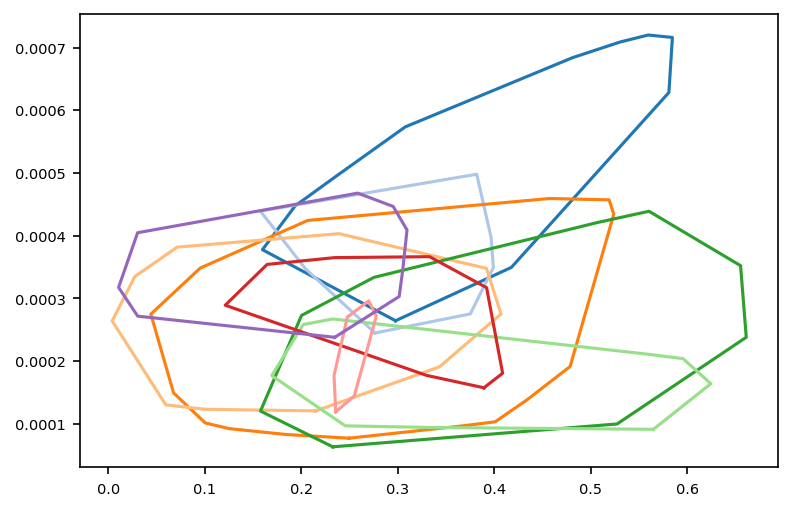

In [35]:
tempxx = np.ndarray.flatten(qd_slope)
tempyy = np.ndarray.flatten(qamtot_slope)
tempzz = np.ndarray.flatten(morph)
for i in range(len(morphlist)):
    plt.plot(*MultiPoint(list(zip(tempxx[tempzz==i],tempyy[tempzz==i]))).convex_hull.exterior.xy,c=tab9((i+0.5)/len(morphlist)))

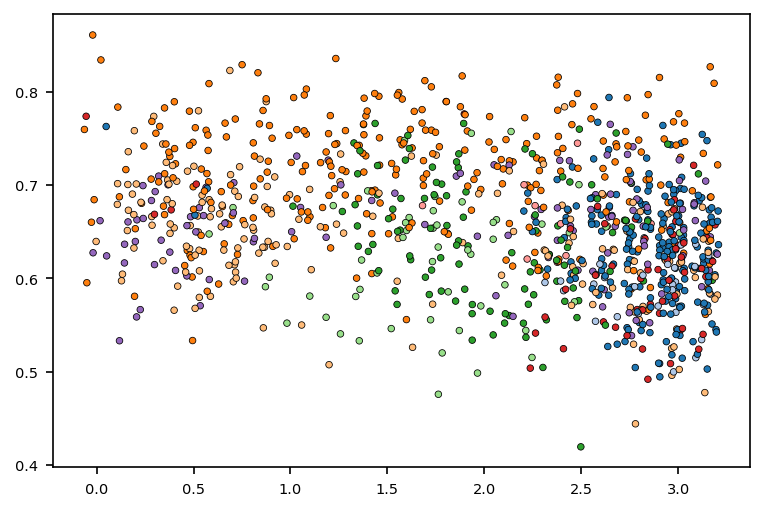

In [82]:
tempxx = np.ndarray.flatten(sub180diffa_steepest_qnatotdir_slope+np.random.uniform(-4/180*np.pi,4/180*np.pi,np.shape(sub180diffa_steepest_qnatotdir_slope)))
tempyy = np.ndarray.flatten(np.mean(lengthweightedslopetheta,axis=2)/np.max(lengthweightedslopetheta,axis=2))
tempzz = np.ndarray.flatten(morph)
randinds = np.arange(len(tempxx))
np.random.shuffle(randinds)
p1 = plt.scatter(tempxx[randinds],tempyy[randinds],lw=lw*0.75,s=ss,c=tempzz[randinds],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,edgecolor='k')

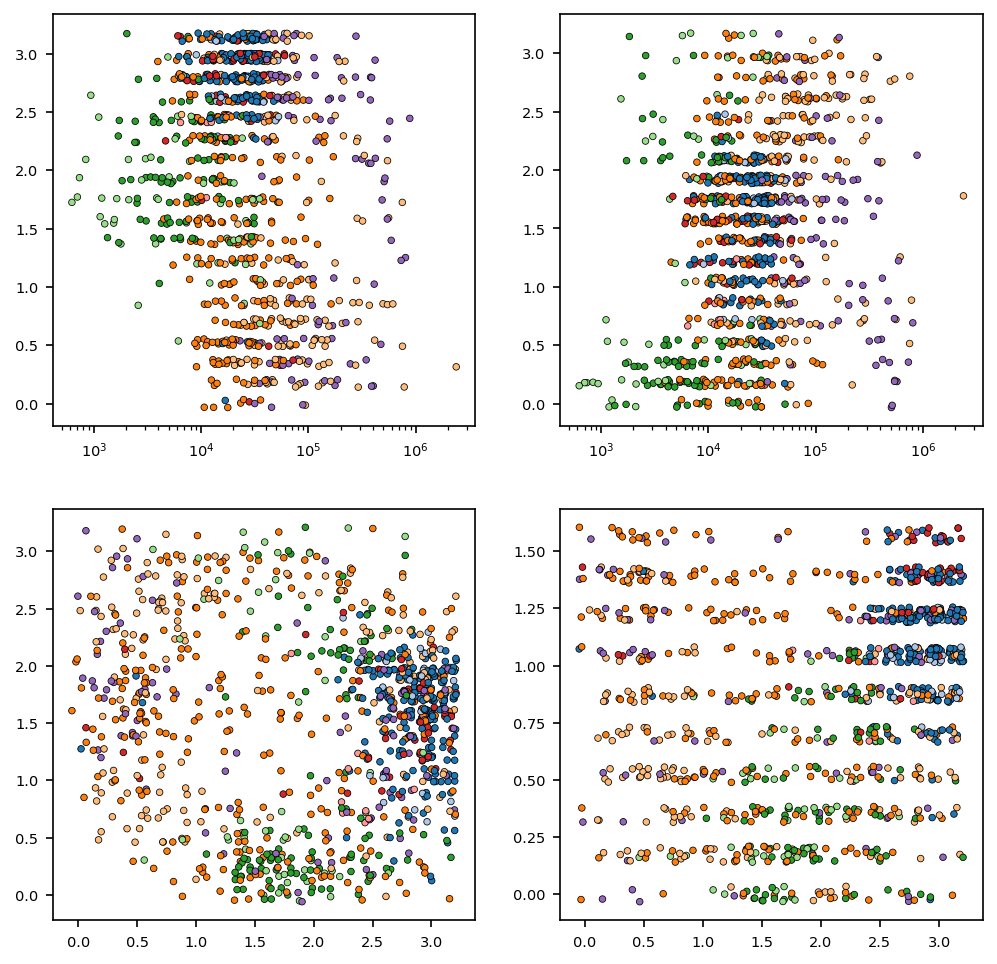

In [80]:
plt.figure(figsize=(8,8))

ax1 = plt.subplot(221)
tempxx = np.ndarray.flatten(Tx_slope/yr_to_s)
tempyy = np.ndarray.flatten(sub180diffa_steepest_qnatotdir_slope+np.random.uniform(-2/180*np.pi,2/180*np.pi,np.shape(sub180diffa_steepest_qnatotdir_slope)))
tempzz = np.ndarray.flatten(morph)
randinds = np.arange(len(tempxx))
np.random.shuffle(randinds)
p1 = plt.scatter(tempxx[randinds],tempyy[randinds],lw=lw*0.75,s=ss,c=tempzz[randinds],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,edgecolor='k')
plt.xscale('log')

ax1 = plt.subplot(222)
tempxx = np.ndarray.flatten(Tx_slope/yr_to_s)
tempyy = np.ndarray.flatten(sub180diffa_shallowest_qnatotdir_slope+np.random.uniform(-2/180*np.pi,2/180*np.pi,np.shape(sub180diffa_steepest_qnatotdir_slope)))
tempzz = np.ndarray.flatten(morph)
randinds = np.arange(len(tempxx))
np.random.shuffle(randinds)
p1 = plt.scatter(tempxx[randinds],tempyy[randinds],lw=lw*0.75,s=ss,c=tempzz[randinds],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,edgecolor='k')
plt.xscale('log')

ax1 = plt.subplot(223)
tempxx = np.ndarray.flatten(sub180diffa_steepest_qnatotdir_slope+np.random.uniform(-4/180*np.pi,4/180*np.pi,np.shape(sub180diffa_steepest_qnatotdir_slope)))
tempyy = np.ndarray.flatten(sub180diffa_shallowest_qnatotdir_slope+np.random.uniform(-4/180*np.pi,4/180*np.pi,np.shape(sub180diffa_steepest_qnatotdir_slope)))
tempzz = np.ndarray.flatten(morph)
randinds = np.arange(len(tempxx))
np.random.shuffle(randinds)
p1 = plt.scatter(tempxx[randinds],tempyy[randinds],lw=lw*0.75,s=ss,c=tempzz[randinds],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,edgecolor='k')

ax1 = plt.subplot(224)
tempyy = np.ndarray.flatten(sub90diffa_longest_qnatotdir_slope+np.random.uniform(-2/180*np.pi,2/180*np.pi,np.shape(sub180diffa_steepest_qnatotdir_slope)))
tempxx = np.ndarray.flatten(sub180diffa_steepest_qnatotdir_slope+np.random.uniform(-4/180*np.pi,4/180*np.pi,np.shape(sub180diffa_steepest_qnatotdir_slope)))
tempzz = np.ndarray.flatten(morph)
randinds = np.arange(len(tempxx))
np.random.shuffle(randinds)
p1 = plt.scatter(tempxx[randinds],tempyy[randinds],lw=lw*0.75,s=ss,c=tempzz[randinds],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,edgecolor='k')

([], [])

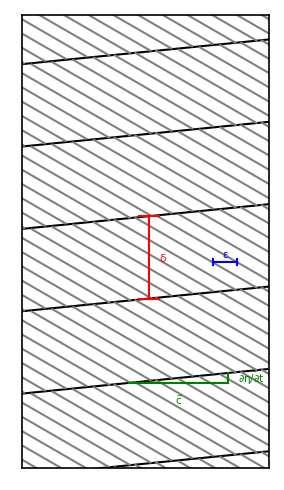

In [45]:
lw = 1

for i in range(nsets):
    plt.plot(tempx,tempsets[i],c='k',lw=lw)
    for j in range(nbeds):
        plt.plot(tempbedsx[i,j],tempbedsy[i,j],c='grey',lw=lw)

width = tempdel/4
i = 2
k = int(nx*0.73)
plt.plot([tempx[k],tempx[k]],[tempsets[i,k],tempsets[i,k]+tempdel],c='r',lw=lw)
plt.plot([tempx[k]-width/2,tempx[k]+width/2],[tempsets[i,k],tempsets[i,k]],c='r',lw=lw)
plt.plot([tempx[k]-width/2,tempx[k]+width/2],[tempsets[i,k]+tempdel,tempsets[i,k]+tempdel],c='r',lw=lw)
plt.text(tempx[k]+width/2,tempsets[i,k]+tempdel/2,'$\\delta$',color='r',ha='left',va='center')

width = tempeps/4
i = 3
j = 21
k = int(nx*0.5)
plt.plot([tempbedsx[i,j,k],tempbedsx[i,j,k]+tempeps],[tempbedsy[i,j,k],tempbedsy[i,j,k]],c='b',lw=lw)
plt.plot([tempbedsx[i,j,k],tempbedsx[i,j,k]],[tempbedsy[i,j,k]-width/2,tempbedsy[i,j,k]+width/2],c='b',lw=lw)
plt.plot([tempbedsx[i,j,k]+tempeps,tempbedsx[i,j,k]+tempeps],[tempbedsy[i,j,k]-width/2,tempbedsy[i,j,k]+width/2],c='b',lw=lw)
plt.text(tempbedsx[i,j,k]+tempeps/2,tempbedsy[i,j,k]+width/2,'$\\epsilon$',color='b',ha='center',va='bottom')

i = 1
k = int(nx*0.72)
scale = 4
width = tempdel/4
plt.plot([tempx[k],tempx[k]+scale*tempc],[tempsets[i,k],tempsets[i,k]],c='g',lw=lw)
plt.plot([tempx[k]+scale*tempc,tempx[k]+scale*tempc],[tempsets[i,k],tempsets[i,k]+scale*tempdetadt],c='g',lw=lw)
plt.text(tempx[k]+scale*tempc/2,tempsets[i,k]-width/2,'$\\vec{c}$',color='g',ha='center',va='top')
plt.text(tempx[k]+scale*tempc+width/2,tempsets[i,k]+scale*tempdetadt/2,'$\\vec{\\partial\\eta/\\partial t}$',color='g',ha='left',va='center')

plt.axis('square')
plt.xlim(4,7)
plt.ylim(0.5,6)
plt.xticks([])
plt.yticks([])

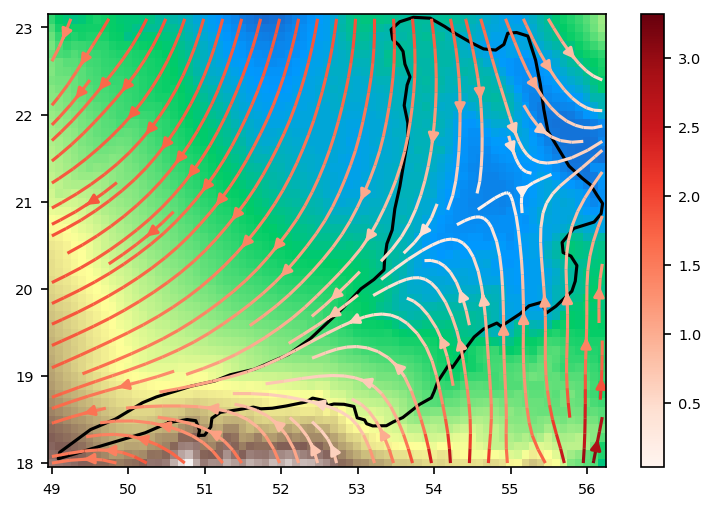

In [75]:
plt.pcolor(templongrid,templatgrid,basemap,cmap='terrain',vmin=0,vmax=600)
plt.plot(*dfpoly.exterior.xy,c='k')
plt.streamplot(templongrid,templatgrid,np.mean(uav,axis=(0,1)),np.mean(vav,axis=(0,1)),color=((np.mean(uav,axis=(0,1))**2+np.mean(vav,axis=(0,1))**2)**0.5),cmap='Reds')
plt.colorbar()

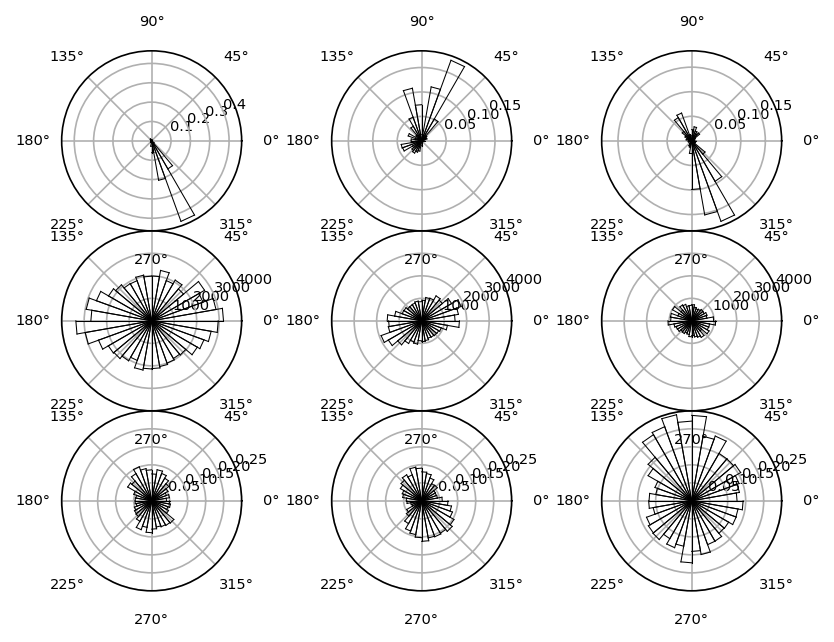

In [87]:
lw = 0.5
col1 = 'k'

fig = plt.gcf()

tempadiff = np.diff(thetas)[0]/2

i,j = 50,48
ax00 = fig.add_axes([0.,0,0.3,0.3],projection='polar')
for k in range(len(thetas)):
    plt.plot([thetas[k]-tempadiff,thetas[k]+tempadiff],[lengthweightedslopetheta[i,j][k],lengthweightedslopetheta[i,j][k]],lw=lw,c=col1)
    plt.plot([thetas[k]-tempadiff,thetas[k]-tempadiff],[0,lengthweightedslopetheta[i,j][k]],lw=lw,c=col1)
    plt.plot([thetas[k]+tempadiff,thetas[k]+tempadiff],[0,lengthweightedslopetheta[i,j][k]],lw=lw,c=col1)    
plt.ylim(0,0.25)
ax00 = fig.add_axes([0.,0.3,0.3,0.3],projection='polar')
for k in range(len(thetas)):
    plt.plot([thetas[k]-tempadiff,thetas[k]+tempadiff],[bedformlengththeta[i,j][k],bedformlengththeta[i,j][k]],lw=lw,c=col1)
    plt.plot([thetas[k]-tempadiff,thetas[k]-tempadiff],[0,bedformlengththeta[i,j][k]],lw=lw,c=col1)
    plt.plot([thetas[k]+tempadiff,thetas[k]+tempadiff],[0,bedformlengththeta[i,j][k]],lw=lw,c=col1)    
plt.ylim(0,4000)
ax00 = fig.add_axes([0.,0.6,0.3,0.3],projection='polar')
tempaa = np.arctan2(qnyflat_slope[:,i,j],qnxflat_slope[:,i,j])
temprr = (qnxflat_slope[:,i,j]**2+qnyflat_slope[:,i,j]**2)**0.5
tempcc = np.empty(len(thetas))
for i in range(len(thetas)):
    tempcc[i] = np.sum(temprr[(tempaa>thetas[i]-tempadiff)&(tempaa<=thetas[i]+tempadiff)])
tempcc = tempcc/np.sum(tempcc)
for i in range(len(thetas)):
    plt.plot([thetas[i]-tempadiff,thetas[i]+tempadiff],[tempcc[i],tempcc[i]],lw=lw,c=col1)
    plt.plot([thetas[i]-tempadiff,thetas[i]-tempadiff],[0,tempcc[i]],lw=lw,c=col1)
    plt.plot([thetas[i]+tempadiff,thetas[i]+tempadiff],[0,tempcc[i]],lw=lw,c=col1)
# plt.ylim(0,0.03)

i,j = 6,15
ax00 = fig.add_axes([0.3,0,0.3,0.3],projection='polar')
for k in range(len(thetas)):
    plt.plot([thetas[k]-tempadiff,thetas[k]+tempadiff],[lengthweightedslopetheta[i,j][k],lengthweightedslopetheta[i,j][k]],lw=lw,c=col1)
    plt.plot([thetas[k]-tempadiff,thetas[k]-tempadiff],[0,lengthweightedslopetheta[i,j][k]],lw=lw,c=col1)
    plt.plot([thetas[k]+tempadiff,thetas[k]+tempadiff],[0,lengthweightedslopetheta[i,j][k]],lw=lw,c=col1)    
plt.ylim(0,0.25)
ax00 = fig.add_axes([0.3,0.3,0.3,0.3],projection='polar')
for k in range(len(thetas)):
    plt.plot([thetas[k]-tempadiff,thetas[k]+tempadiff],[bedformlengththeta[i,j][k],bedformlengththeta[i,j][k]],lw=lw,c=col1)
    plt.plot([thetas[k]-tempadiff,thetas[k]-tempadiff],[0,bedformlengththeta[i,j][k]],lw=lw,c=col1)
    plt.plot([thetas[k]+tempadiff,thetas[k]+tempadiff],[0,bedformlengththeta[i,j][k]],lw=lw,c=col1)    
plt.ylim(0,4000)
ax00 = fig.add_axes([0.3,0.6,0.3,0.3],projection='polar')
tempaa = np.arctan2(qnyflat_slope[:,i,j],qnxflat_slope[:,i,j])
temprr = (qnxflat_slope[:,i,j]**2+qnyflat_slope[:,i,j]**2)**0.5
tempcc = np.empty(len(thetas))
for i in range(len(thetas)):
    tempcc[i] = np.sum(temprr[(tempaa>thetas[i]-tempadiff)&(tempaa<=thetas[i]+tempadiff)])
tempcc = tempcc/np.sum(tempcc)
for i in range(len(thetas)):
    plt.plot([thetas[i]-tempadiff,thetas[i]+tempadiff],[tempcc[i],tempcc[i]],lw=lw,c=col1)
    plt.plot([thetas[i]-tempadiff,thetas[i]-tempadiff],[0,tempcc[i]],lw=lw,c=col1)
    plt.plot([thetas[i]+tempadiff,thetas[i]+tempadiff],[0,tempcc[i]],lw=lw,c=col1)
# plt.ylim(0,0.03)

i,j = 34,55
ax00 = fig.add_axes([0.6,0,0.3,0.3],projection='polar')
for k in range(len(thetas)):
    plt.plot([thetas[k]-tempadiff,thetas[k]+tempadiff],[lengthweightedslopetheta[i,j][k],lengthweightedslopetheta[i,j][k]],lw=lw,c=col1)
    plt.plot([thetas[k]-tempadiff,thetas[k]-tempadiff],[0,lengthweightedslopetheta[i,j][k]],lw=lw,c=col1)
    plt.plot([thetas[k]+tempadiff,thetas[k]+tempadiff],[0,lengthweightedslopetheta[i,j][k]],lw=lw,c=col1)    
plt.ylim(0,0.25)
ax00 = fig.add_axes([0.6,0.3,0.3,0.3],projection='polar')
for k in range(len(thetas)):
    plt.plot([thetas[k]-tempadiff,thetas[k]+tempadiff],[bedformlengththeta[i,j][k],bedformlengththeta[i,j][k]],lw=lw,c=col1)
    plt.plot([thetas[k]-tempadiff,thetas[k]-tempadiff],[0,bedformlengththeta[i,j][k]],lw=lw,c=col1)
    plt.plot([thetas[k]+tempadiff,thetas[k]+tempadiff],[0,bedformlengththeta[i,j][k]],lw=lw,c=col1)    
plt.ylim(0,4000)
ax00 = fig.add_axes([0.6,0.6,0.3,0.3],projection='polar')
tempaa = np.arctan2(qnyflat_slope[:,i,j],qnxflat_slope[:,i,j])
temprr = (qnxflat_slope[:,i,j]**2+qnyflat_slope[:,i,j]**2)**0.5
tempcc = np.empty(len(thetas))
for i in range(len(thetas)):
    tempcc[i] = np.sum(temprr[(tempaa>thetas[i]-tempadiff)&(tempaa<=thetas[i]+tempadiff)])
tempcc = tempcc/np.sum(tempcc)
for i in range(len(thetas)):
    plt.plot([thetas[i]-tempadiff,thetas[i]+tempadiff],[tempcc[i],tempcc[i]],lw=lw,c=col1)
    plt.plot([thetas[i]-tempadiff,thetas[i]-tempadiff],[0,tempcc[i]],lw=lw,c=col1)
    plt.plot([thetas[i]+tempadiff,thetas[i]+tempadiff],[0,tempcc[i]],lw=lw,c=col1)
# plt.ylim(0,0.03)

In [27]:
i,j = 7,46
tempaa = np.arctan2(qnyflat_slope[:,i,j],qnxflat_slope[:,i,j])
temprr = (qnxflat_slope[:,i,j]**2+qnyflat_slope[:,i,j]**2)**0.5
tempcc = np.empty(len(thetas))
for i in range(len(thetas)):
    tempcc[i] = np.sum(temprr[(tempaa>thetas[i]-tempadiff)&(tempaa<=thetas[i]+tempadiff)])
tempcc = tempcc/np.sum(tempcc)

In [28]:
np.max(tempcc)

0.3339894296661902

(0.0, 0.35)

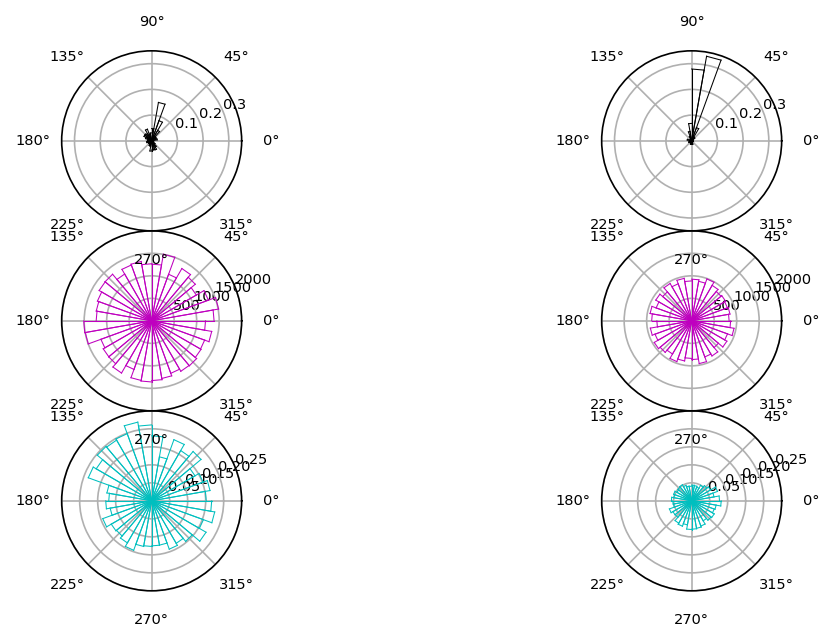

In [31]:
lw = 0.5
ss = 10

col1 = 'c'
col2 = 'm'
col3 = 'k'
slopemaxlim = 0.25
lengthmaxlim = 2000
qprobmaxlim = 0.35
tempadiff = np.diff(thetas)[0]/2

fig = plt.gcf()

tempadiff = np.diff(thetas)[0]/2

i,j = 18,44
ax00 = fig.add_axes([0.,0,0.3,0.3],projection='polar')
for k in range(len(thetas)):
    plt.plot([thetas[k]-tempadiff,thetas[k]+tempadiff],[lengthweightedslopetheta[i,j][k],lengthweightedslopetheta[i,j][k]],lw=lw,c=col1)
    plt.plot([thetas[k]-tempadiff,thetas[k]-tempadiff],[0,lengthweightedslopetheta[i,j][k]],lw=lw,c=col1)
    plt.plot([thetas[k]+tempadiff,thetas[k]+tempadiff],[0,lengthweightedslopetheta[i,j][k]],lw=lw,c=col1)    
plt.ylim(0,slopemaxlim)
ax00 = fig.add_axes([0.,0.3,0.3,0.3],projection='polar')
for k in range(len(thetas)):
    plt.plot([thetas[k]-tempadiff,thetas[k]+tempadiff],[bedformlengththeta[i,j][k],bedformlengththeta[i,j][k]],lw=lw,c=col2)
    plt.plot([thetas[k]-tempadiff,thetas[k]-tempadiff],[0,bedformlengththeta[i,j][k]],lw=lw,c=col2)
    plt.plot([thetas[k]+tempadiff,thetas[k]+tempadiff],[0,bedformlengththeta[i,j][k]],lw=lw,c=col2)    
plt.ylim(0,lengthmaxlim)
ax00 = fig.add_axes([0.,0.6,0.3,0.3],projection='polar')
tempaa = np.arctan2(qnyflat_slope[:,i,j],qnxflat_slope[:,i,j])
temprr = (qnxflat_slope[:,i,j]**2+qnyflat_slope[:,i,j]**2)**0.5
tempcc = np.empty(len(thetas))
for i in range(len(thetas)):
    tempcc[i] = np.sum(temprr[(tempaa>thetas[i]-tempadiff)&(tempaa<=thetas[i]+tempadiff)])
tempcc = tempcc/np.sum(tempcc)
for i in range(len(thetas)):
    plt.plot([thetas[i]-tempadiff,thetas[i]+tempadiff],[tempcc[i],tempcc[i]],lw=lw,c=col3)
    plt.plot([thetas[i]-tempadiff,thetas[i]-tempadiff],[0,tempcc[i]],lw=lw,c=col3)
    plt.plot([thetas[i]+tempadiff,thetas[i]+tempadiff],[0,tempcc[i]],lw=lw,c=col3)
plt.ylim(0,qprobmaxlim)

i,j = 7,46
ax00 = fig.add_axes([0.6,0,0.3,0.3],projection='polar')
for k in range(len(thetas)):
    plt.plot([thetas[k]-tempadiff,thetas[k]+tempadiff],[lengthweightedslopetheta[i,j][k],lengthweightedslopetheta[i,j][k]],lw=lw,c=col1)
    plt.plot([thetas[k]-tempadiff,thetas[k]-tempadiff],[0,lengthweightedslopetheta[i,j][k]],lw=lw,c=col1)
    plt.plot([thetas[k]+tempadiff,thetas[k]+tempadiff],[0,lengthweightedslopetheta[i,j][k]],lw=lw,c=col1)    
plt.ylim(0,slopemaxlim)
ax00 = fig.add_axes([0.6,0.3,0.3,0.3],projection='polar')
for k in range(len(thetas)):
    plt.plot([thetas[k]-tempadiff,thetas[k]+tempadiff],[bedformlengththeta[i,j][k],bedformlengththeta[i,j][k]],lw=lw,c=col2)
    plt.plot([thetas[k]-tempadiff,thetas[k]-tempadiff],[0,bedformlengththeta[i,j][k]],lw=lw,c=col2)
    plt.plot([thetas[k]+tempadiff,thetas[k]+tempadiff],[0,bedformlengththeta[i,j][k]],lw=lw,c=col2)    
plt.ylim(0,lengthmaxlim)
ax00 = fig.add_axes([0.6,0.6,0.3,0.3],projection='polar')
tempaa = np.arctan2(qnyflat_slope[:,i,j],qnxflat_slope[:,i,j])
temprr = (qnxflat_slope[:,i,j]**2+qnyflat_slope[:,i,j]**2)**0.5
tempcc = np.empty(len(thetas))
for i in range(len(thetas)):
    tempcc[i] = np.sum(temprr[(tempaa>thetas[i]-tempadiff)&(tempaa<=thetas[i]+tempadiff)])
tempcc = tempcc/np.sum(tempcc)
for i in range(len(thetas)):
    plt.plot([thetas[i]-tempadiff,thetas[i]+tempadiff],[tempcc[i],tempcc[i]],lw=lw,c=col3)
    plt.plot([thetas[i]-tempadiff,thetas[i]-tempadiff],[0,tempcc[i]],lw=lw,c=col3)
    plt.plot([thetas[i]+tempadiff,thetas[i]+tempadiff],[0,tempcc[i]],lw=lw,c=col3)
plt.ylim(0,qprobmaxlim)

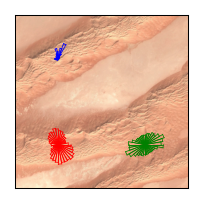

In [35]:
lw = 0.5
ss = 10
col1 = 'r'
col2 = 'g'
col3 = 'b'

slopemaxlim = 0.25
lengthmaxlim = 3500
qprobmaxlim = 0.5

fig = plt.gcf()

ax2l,ax2b,ax2w,ax2h = 0.005,1-0.005-pltspan2,pltspan2,pltspan2
ax20l,ax20b,ax20w,ax20h = ax2l,ax2b,pltspan2/2,pltspan2/2
ax21l,ax21b,ax21w,ax21h = ax2l+pltspan2/2,ax2b,pltspan2/2,pltspan2/2
ax22l,ax22b,ax22w,ax22h = ax2l,ax2b+pltspan2/2,pltspan2/2,pltspan2/2

tempadiff = np.diff(thetas)[0]/2

ax2 = fig.add_axes([ax2l,ax2b,ax2w,ax2h])
img = mpimg.imread(directory+'figures/im186505_4km.png')
plt.imshow(img)
plt.xticks([])
plt.yticks([])

i,j = 6,15
ax20 = fig.add_axes([ax20l,ax20b,ax20w,ax20h],projection='polar')
for k in range(len(thetas)):
    plt.plot([thetas[k]-tempadiff,thetas[k]+tempadiff],[lengthweightedslopetheta[i,j][k],lengthweightedslopetheta[i,j][k]],lw=lw*0.75,c=col1)
    plt.plot([thetas[k]-tempadiff,thetas[k]-tempadiff],[0,lengthweightedslopetheta[i,j][k]],lw=lw*0.75,c=col1)
    plt.plot([thetas[k]+tempadiff,thetas[k]+tempadiff],[0,lengthweightedslopetheta[i,j][k]],lw=lw*0.75,c=col1)    
plt.ylim(0,slopemaxlim)
ax21 = fig.add_axes([ax21l,ax21b,ax21w,ax21h],projection='polar')
for k in range(len(thetas)):
    plt.plot([thetas[k]-tempadiff,thetas[k]+tempadiff],[bedformlengththeta[i,j][k],bedformlengththeta[i,j][k]],lw=lw*0.75,c=col2)
    plt.plot([thetas[k]-tempadiff,thetas[k]-tempadiff],[0,bedformlengththeta[i,j][k]],lw=lw*0.75,c=col2)
    plt.plot([thetas[k]+tempadiff,thetas[k]+tempadiff],[0,bedformlengththeta[i,j][k]],lw=lw*0.75,c=col2)    
plt.ylim(0,lengthmaxlim)
ax22 = fig.add_axes([ax22l,ax22b,ax22w,ax22h],projection='polar')
tempaa = np.arctan2(qnyflat_slope[:,i,j],qnxflat_slope[:,i,j])
temprr = (qnxflat_slope[:,i,j]**2+qnyflat_slope[:,i,j]**2)**0.5
tempcc = np.empty(len(thetas))
for i in range(len(thetas)):
    tempcc[i] = np.sum(temprr[(tempaa>thetas[i]-tempadiff)&(tempaa<=thetas[i]+tempadiff)])
tempcc = tempcc/np.sum(tempcc)
for i in range(len(thetas)):
    plt.plot([thetas[i]-tempadiff,thetas[i]+tempadiff],[tempcc[i],tempcc[i]],lw=lw*0.75,c=col3)
    plt.plot([thetas[i]-tempadiff,thetas[i]-tempadiff],[0,tempcc[i]],lw=lw*0.75,c=col3)
    plt.plot([thetas[i]+tempadiff,thetas[i]+tempadiff],[0,tempcc[i]],lw=lw*0.75,c=col3)
plt.ylim(0,qprobmaxlim)

for ax in fig.axes:
    ax.tick_params(width=lw,length=lw*5,which='both',direction='in')
    ax.minorticks_off()
    if str(type(ax))=="<class 'matplotlib.projections.polar.PolarAxes'>":
        ax.axis('off')
    else:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(lw)
fig.set_size_inches(figw/25.4,figh/25.4,forward=True)

## Final plots

/local/k10/ag5517/tmp/ipykernel_311910/1653110.py:98: RuntimeWarning: divide by zero encountered in log10
  p3 = plt.pcolor(tempxx,tempxx,np.log10(tempcc).T,cmap='hot',vmin=-3,vmax=3,rasterized=True)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Arial
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not

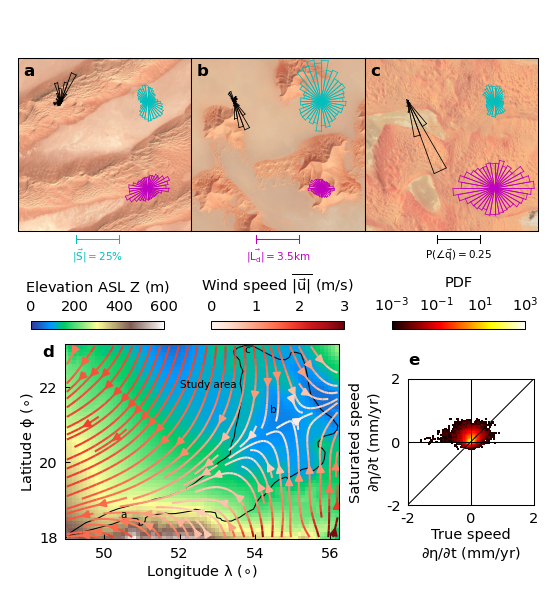

In [23]:
draft = False
polars = True

lw = 0.5
ss = 10

col1 = 'c'
col2 = 'm'
col3 = 'k'
slopemaxlim = 0.25
lengthmaxlim = 3500
qprobmaxlim = 0.25
tempadiff = np.diff(thetas)[0]/2

figw = 89
figh = 89
cbh = 0.015
buffw0 = 0.13
buffw1 = 0.09
cb1l0 = 0.03
cbw = (1-2*cb1l0-buffw1*2)/3
buffh = 0.03
pltspan0h = 0.37
pltspan0w = pltspan0h*(np.max(templongrid)-np.min(templongrid))/(np.max(templatgrid)-np.min(templatgrid))/figw*figh
pltspan1 = 0.24
pltspan2 = 0.33
pltspan3 = pltspan2*0.5
padw0 = 0.01
labbuf = 0.01

ax0l,ax0b,ax0w,ax0h = 0.095,0.08,pltspan0w,pltspan0h
cb1l,cb1b,cb1w,cb1h = cb1l0,ax0b+pltspan0h+buffh,cbw,cbh
cb2l,cb2b,cb2w,cb2h = cb1l+cbw+buffw1,ax0b+pltspan0h+buffh,cbw,cbh
cb3l,cb3b,cb3w,cb3h = cb1l+2*(cbw+buffw1),ax0b+pltspan0h+buffh,cbw,cbh
ax1l,ax1b,ax1w,ax1h = ax0l+pltspan0w+buffw0,ax0b+pltspan0h/2-pltspan1/2,pltspan1,pltspan1
ax2l,ax2b,ax2w,ax2h = 0.005,1-0.005-pltspan2,pltspan2,pltspan2
ax3l,ax3b,ax3w,ax3h = ax2l+pltspan2,ax2b,pltspan2,pltspan2
ax4l,ax4b,ax4w,ax4h = ax2l+pltspan2*2,ax2b,pltspan2,pltspan2

ax20l,ax20b,ax20w,ax20h = ax2l+pltspan2/2,ax2b+pltspan2/2,pltspan3,pltspan3
ax21l,ax21b,ax21w,ax21h = ax2l+pltspan2/2,ax2b,pltspan3,pltspan3
ax22l,ax22b,ax22w,ax22h = ax2l,ax2b+pltspan2/2,pltspan3,pltspan3
ax30l,ax30b,ax30w,ax30h = ax3l+pltspan2/2,ax3b+pltspan2/2,pltspan3,pltspan3
ax31l,ax31b,ax31w,ax31h = ax3l+pltspan2/2,ax3b,pltspan3,pltspan3
ax32l,ax32b,ax32w,ax32h = ax3l,ax3b+pltspan2/2,pltspan3,pltspan3
ax40l,ax40b,ax40w,ax40h = ax4l+pltspan2/2,ax4b+pltspan2/2,pltspan3,pltspan3
ax41l,ax41b,ax41w,ax41h = ax4l+pltspan2/2,ax4b,pltspan3,pltspan3
ax42l,ax42b,ax42w,ax42h = ax4l-pltspan3/2,ax4b+pltspan2/2-pltspan3/2,2*pltspan3,2*pltspan3

fig = plt.gcf()

ax00 = fig.add_axes([0,0,1,1])
ax00.patch.set_alpha(0)
ax00.set_zorder(1)
if draft:
    plt.xticks([])
    plt.yticks([])
else:
    plt.axis('off')
    
ax00.text(ax2l+labbuf,ax2b+ax2h-labbuf,'a',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax3l+labbuf,ax3b+ax3h-labbuf,'b',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax4l+labbuf,ax4b+ax4h-labbuf,'c',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax0l-labbuf*2,ax0b+ax0h,'d',fontsize=8, weight='bold',va='top',ha='right')
ax00.text(ax1l,ax1b+ax1h+labbuf*2,'e',fontsize=8, weight='bold',va='bottom',ha='left')

ax00.plot([cb1l+cbw/2-ax20w/4,cb1l+cbw/2+ax20w/4],[ax2b-buffh/2,ax2b-buffh/2],lw=lw,c=col1)
ax00.plot([cb1l+cbw/2-ax20w/4,cb1l+cbw/2-ax20w/4],[ax2b-buffh/2+cbh/2,ax2b-buffh/2-cbh/2],lw=lw,c=col1)
ax00.plot([cb1l+cbw/2+ax20w/4,cb1l+cbw/2+ax20w/4],[ax2b-buffh/2+cbh/2,ax2b-buffh/2-cbh/2],lw=lw,c=col1)
ax00.text(cb1l+cbw/2,ax2b-buffh/2-cbh,'$|\\vec{S}|=%d$%%'%(slopemaxlim*1e+2),color=col1,ha='center',va='top',fontsize=5)
ax00.plot([cb2l+cbw/2-ax20w/4,cb2l+cbw/2+ax20w/4],[ax2b-buffh/2,ax2b-buffh/2],lw=lw,c=col2)
ax00.plot([cb2l+cbw/2-ax20w/4,cb2l+cbw/2-ax20w/4],[ax2b-buffh/2+cbh/2,ax2b-buffh/2-cbh/2],lw=lw,c=col2)
ax00.plot([cb2l+cbw/2+ax20w/4,cb2l+cbw/2+ax20w/4],[ax2b-buffh/2+cbh/2,ax2b-buffh/2-cbh/2],lw=lw,c=col2)
ax00.text(cb2l+cbw/2,ax2b-buffh/2-cbh,'$|\\vec{L_d}|=%.1f km$'%(lengthmaxlim*1e-3),color=col2,ha='center',va='top',fontsize=5)
ax00.plot([cb3l+cbw/2-ax20w/4,cb3l+cbw/2+ax20w/4],[ax2b-buffh/2,ax2b-buffh/2],lw=lw,c=col3)
ax00.plot([cb3l+cbw/2-ax20w/4,cb3l+cbw/2-ax20w/4],[ax2b-buffh/2+cbh/2,ax2b-buffh/2-cbh/2],lw=lw,c=col3)
ax00.plot([cb3l+cbw/2+ax20w/4,cb3l+cbw/2+ax20w/4],[ax2b-buffh/2+cbh/2,ax2b-buffh/2-cbh/2],lw=lw,c=col3)
ax00.text(cb3l+cbw/2,ax2b-buffh/2-cbh,'$P(\\angle\\vec{q})=%.2f$'%qprobmaxlim,color=col3,ha='center',va='top',fontsize=5)
ax00.set_xlim(0,1)
ax00.set_ylim(0,1)

ax0 = fig.add_axes([ax0l,ax0b,ax0w,ax0h])
p1 = plt.pcolor(templongrid,templatgrid,basemap,cmap='terrain',vmin=0,vmax=600,rasterized=True)
plt.plot(*dfpoly.exterior.xy,c='k',lw=lw)
p2 = plt.streamplot(templongrid,templatgrid,np.mean(uav,axis=(0,1)),np.mean(vav,axis=(0,1)),color=((np.mean(uav,axis=(0,1))**2+np.mean(vav,axis=(0,1))**2)**0.5),cmap='Reds',linewidth=lw*2,arrowsize=lw*1.5,norm=Normalize(0,3))
plt.text(52,22,'Study area',fontsize=5)
ax0.set_xticks([50,52,54,56])
ax0.set_xticklabels([50,52,54,56])
ax0.set_yticks([18,20,22])
ax0.set_yticklabels([18,20,22])
ax0.set_xlabel('Longitude $\\lambda$ ($\\circ$)',labelpad=1)
ax0.set_ylabel('Latitude $\\phi$ ($\\circ$)',labelpad=1)

ax1 = fig.add_axes([ax1l,ax1b,ax1w,ax1h])
tempabsx = 4
tempxx = np.linspace(-tempabsx/2,tempabsx/2,100)
tempcc,_,_ = np.histogram2d(np.ndarray.flatten(detadt_slope*mps_to_mmpyr),np.ndarray.flatten(detadt*mps_to_mmpyr),bins=tempxx,density=True)
p3 = plt.pcolor(tempxx,tempxx,np.log10(tempcc).T,cmap='hot',vmin=-3,vmax=3,rasterized=True)
plt.plot([-tempabsx/2,tempabsx/2],[0,0],c='k',lw=lw)
plt.plot([0,0],[-tempabsx/2,tempabsx/2],c='k',lw=lw)
plt.plot([-tempabsx/2,tempabsx/2],[-tempabsx/2,tempabsx/2],c='k',lw=lw)
plt.xlim(-tempabsx/2,tempabsx/2)
plt.ylim(-tempabsx/2,tempabsx/2)
ax1.set_xticks([-2,0,2])
ax1.set_xticklabels([-2,0,2])
ax1.set_yticks([-2,0,2])
ax1.set_yticklabels([-2,0,2])
ax1.set_xlabel('True speed\n$\\partial\\eta/\\partial t$ (mm/yr)',labelpad=1)
ax1.set_ylabel('Saturated speed\n$\\partial\\eta/\\partial t$ (mm/yr)',labelpad=1)

ax2 = fig.add_axes([ax2l,ax2b,ax2w,ax2h])
i,j = 6,15
ax0.text(templongrid[j],templatgrid[i],'a',fontsize=5,va='center',ha='center')
img = mpimg.imread(directory+'figures/im186505_4km.png')
plt.imshow(img)
plt.xticks([])
plt.yticks([])
if polars:
    ax20 = fig.add_axes([ax20l,ax20b,ax20w,ax20h],projection='polar')
    for k in range(len(thetas)):
        plt.plot([thetas[k]-tempadiff,thetas[k]+tempadiff],[lengthweightedslopetheta[i,j][k],lengthweightedslopetheta[i,j][k]],lw=lw*0.75,c=col1)
        plt.plot([thetas[k]-tempadiff,thetas[k]-tempadiff],[0,lengthweightedslopetheta[i,j][k]],lw=lw*0.75,c=col1)
        plt.plot([thetas[k]+tempadiff,thetas[k]+tempadiff],[0,lengthweightedslopetheta[i,j][k]],lw=lw*0.75,c=col1)    
    plt.ylim(0,slopemaxlim)
    ax21 = fig.add_axes([ax21l,ax21b,ax21w,ax21h],projection='polar')
    for k in range(len(thetas)):
        plt.plot([thetas[k]-tempadiff,thetas[k]+tempadiff],[bedformlengththeta[i,j][k],bedformlengththeta[i,j][k]],lw=lw*0.75,c=col2)
        plt.plot([thetas[k]-tempadiff,thetas[k]-tempadiff],[0,bedformlengththeta[i,j][k]],lw=lw*0.75,c=col2)
        plt.plot([thetas[k]+tempadiff,thetas[k]+tempadiff],[0,bedformlengththeta[i,j][k]],lw=lw*0.75,c=col2)    
    plt.ylim(0,lengthmaxlim)
    ax22 = fig.add_axes([ax22l,ax22b,ax22w,ax22h],projection='polar')
    tempaa = np.arctan2(qnyflat_slope[:,i,j],qnxflat_slope[:,i,j])
    temprr = (qnxflat_slope[:,i,j]**2+qnyflat_slope[:,i,j]**2)**0.5
    tempcc = np.empty(len(thetas))
    for i in range(len(thetas)):
        tempcc[i] = np.sum(temprr[(tempaa>thetas[i]-tempadiff)&(tempaa<=thetas[i]+tempadiff)])
    tempcc = tempcc/np.sum(tempcc)
    for i in range(len(thetas)):
        plt.plot([thetas[i]-tempadiff,thetas[i]+tempadiff],[tempcc[i],tempcc[i]],lw=lw*0.75,c=col3)
        plt.plot([thetas[i]-tempadiff,thetas[i]-tempadiff],[0,tempcc[i]],lw=lw*0.75,c=col3)
        plt.plot([thetas[i]+tempadiff,thetas[i]+tempadiff],[0,tempcc[i]],lw=lw*0.75,c=col3)
    plt.ylim(0,qprobmaxlim)

ax3 = fig.add_axes([ax3l,ax3b,ax3w,ax3h])
i,j = 34,55
ax0.text(templongrid[j],templatgrid[i],'b',fontsize=5,va='center',ha='center')
img = mpimg.imread(directory+'figures/im226552_4km.png')
plt.imshow(img)
plt.xticks([])
plt.yticks([])
if polars:
    ax30 = fig.add_axes([ax30l,ax30b,ax30w,ax30h],projection='polar')
    for k in range(len(thetas)):
        plt.plot([thetas[k]-tempadiff,thetas[k]+tempadiff],[lengthweightedslopetheta[i,j][k],lengthweightedslopetheta[i,j][k]],lw=lw*0.75,c=col1)
        plt.plot([thetas[k]-tempadiff,thetas[k]-tempadiff],[0,lengthweightedslopetheta[i,j][k]],lw=lw*0.75,c=col1)
        plt.plot([thetas[k]+tempadiff,thetas[k]+tempadiff],[0,lengthweightedslopetheta[i,j][k]],lw=lw*0.75,c=col1)    
    plt.ylim(0,slopemaxlim)
    ax31 = fig.add_axes([ax31l,ax31b,ax31w,ax31h],projection='polar')
    for k in range(len(thetas)):
        plt.plot([thetas[k]-tempadiff,thetas[k]+tempadiff],[bedformlengththeta[i,j][k],bedformlengththeta[i,j][k]],lw=lw*0.75,c=col2)
        plt.plot([thetas[k]-tempadiff,thetas[k]-tempadiff],[0,bedformlengththeta[i,j][k]],lw=lw*0.75,c=col2)
        plt.plot([thetas[k]+tempadiff,thetas[k]+tempadiff],[0,bedformlengththeta[i,j][k]],lw=lw*0.75,c=col2)    
    plt.ylim(0,lengthmaxlim)
    ax32 = fig.add_axes([ax32l,ax32b,ax32w,ax32h],projection='polar')
    tempaa = np.arctan2(qnyflat_slope[:,i,j],qnxflat_slope[:,i,j])
    temprr = (qnxflat_slope[:,i,j]**2+qnyflat_slope[:,i,j]**2)**0.5
    tempcc = np.empty(len(thetas))
    for i in range(len(thetas)):
        tempcc[i] = np.sum(temprr[(tempaa>thetas[i]-tempadiff)&(tempaa<=thetas[i]+tempadiff)])
    tempcc = tempcc/np.sum(tempcc)
    for i in range(len(thetas)):
        plt.plot([thetas[i]-tempadiff,thetas[i]+tempadiff],[tempcc[i],tempcc[i]],lw=lw*0.75,c=col3)
        plt.plot([thetas[i]-tempadiff,thetas[i]-tempadiff],[0,tempcc[i]],lw=lw*0.75,c=col3)
        plt.plot([thetas[i]+tempadiff,thetas[i]+tempadiff],[0,tempcc[i]],lw=lw*0.75,c=col3)
    plt.ylim(0,qprobmaxlim)
    
ax4 = fig.add_axes([ax4l,ax4b,ax4w,ax4h])
i,j = 50,48
ax0.text(templongrid[j],templatgrid[i],'c',fontsize=5,va='center',ha='center')
img = mpimg.imread(directory+'figures/im230538_4km.png')
plt.imshow(img)
plt.xticks([])
plt.yticks([])
if polars:
    ax40 = fig.add_axes([ax40l,ax40b,ax40w,ax40h],projection='polar')
    for k in range(len(thetas)):
        plt.plot([thetas[k]-tempadiff,thetas[k]+tempadiff],[lengthweightedslopetheta[i,j][k],lengthweightedslopetheta[i,j][k]],lw=lw*0.75,c=col1)
        plt.plot([thetas[k]-tempadiff,thetas[k]-tempadiff],[0,lengthweightedslopetheta[i,j][k]],lw=lw*0.75,c=col1)
        plt.plot([thetas[k]+tempadiff,thetas[k]+tempadiff],[0,lengthweightedslopetheta[i,j][k]],lw=lw*0.75,c=col1)    
    plt.ylim(0,slopemaxlim)
    ax41 = fig.add_axes([ax41l,ax41b,ax41w,ax41h],projection='polar')
    for k in range(len(thetas)):
        plt.plot([thetas[k]-tempadiff,thetas[k]+tempadiff],[bedformlengththeta[i,j][k],bedformlengththeta[i,j][k]],lw=lw*0.75,c=col2)
        plt.plot([thetas[k]-tempadiff,thetas[k]-tempadiff],[0,bedformlengththeta[i,j][k]],lw=lw*0.75,c=col2)
        plt.plot([thetas[k]+tempadiff,thetas[k]+tempadiff],[0,bedformlengththeta[i,j][k]],lw=lw*0.75,c=col2)    
    plt.ylim(0,lengthmaxlim)
    ax42 = fig.add_axes([ax42l,ax42b,ax42w,ax42h],projection='polar')
    tempaa = np.arctan2(qnyflat_slope[:,i,j],qnxflat_slope[:,i,j])
    temprr = (qnxflat_slope[:,i,j]**2+qnyflat_slope[:,i,j]**2)**0.5
    tempcc = np.empty(len(thetas))
    for i in range(len(thetas)):
        tempcc[i] = np.sum(temprr[(tempaa>thetas[i]-tempadiff)&(tempaa<=thetas[i]+tempadiff)])
    tempcc = tempcc/np.sum(tempcc)
    for i in range(len(thetas)):
        plt.plot([thetas[i]-tempadiff,thetas[i]+tempadiff],[tempcc[i],tempcc[i]],lw=lw*0.75,c=col3)
        plt.plot([thetas[i]-tempadiff,thetas[i]-tempadiff],[0,tempcc[i]],lw=lw*0.75,c=col3)
        plt.plot([thetas[i]+tempadiff,thetas[i]+tempadiff],[0,tempcc[i]],lw=lw*0.75,c=col3)
    plt.ylim(0,2*qprobmaxlim)

cbar1_ax = fig.add_axes([cb1l,cb1b,cb1w,cb1h])
cb1 = fig.colorbar(p1, orientation='horizontal',cax=cbar1_ax, ticks=[0,200,400,600])
cbar1_ax.xaxis.set_label_position('top')
cbar1_ax.xaxis.set_ticks_position('top')
cb1.ax.set_xlabel('Elevation ASL $Z$ (m)',labelpad=4)
cb1.ax.set_xticklabels([0,200,400,600])

cbar2_ax = fig.add_axes([cb2l,cb2b,cb2w,cb2h])
cb2 = fig.colorbar(p2.lines, orientation='horizontal',cax=cbar2_ax, ticks=[0,1,2,3])
cbar2_ax.xaxis.set_label_position('top')
cbar2_ax.xaxis.set_ticks_position('top')
cb2.ax.set_xlabel('Wind speed $\\overline{|\\vec{u}|}$ (m/s)',labelpad=4)
cb2.ax.set_xticklabels([0,1,2,3])

cbar3_ax = fig.add_axes([cb3l,cb3b,cb3w,cb3h])
cb3 = fig.colorbar(p3, orientation='horizontal',cax=cbar3_ax, ticks=[-3,-1,1,3])
cbar3_ax.xaxis.set_label_position('top')
cbar3_ax.xaxis.set_ticks_position('top')
cb3.ax.set_xlabel('PDF',labelpad=4)
cb3.ax.set_xticklabels(['$10^{-3}$','$10^{-1}$','$10^{1}$','$10^{3}$'])

for ax in fig.axes:
    ax.tick_params(width=lw,length=lw*5,which='both',direction='in')
    ax.minorticks_off()
    if str(type(ax))=="<class 'matplotlib.projections.polar.PolarAxes'>":
        ax.axis('off')
    else:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(lw)
cb1.ax.tick_params(width=0,length=0,which='both',direction='in')
cb1.outline.set_linewidth(lw)
cb2.ax.tick_params(width=0,length=0,which='both',direction='in')
cb2.outline.set_linewidth(lw)
cb3.ax.tick_params(width=0,length=0,which='both',direction='in')
cb3.outline.set_linewidth(lw)

fig.set_size_inches(figw/25.4,figh/25.4,forward=True)
if draft==False:
    plt.savefig(directory+'figures/fig1.pdf',dpi=300)
    plt.savefig(directory+'figures/fig1.png',dpi=300)

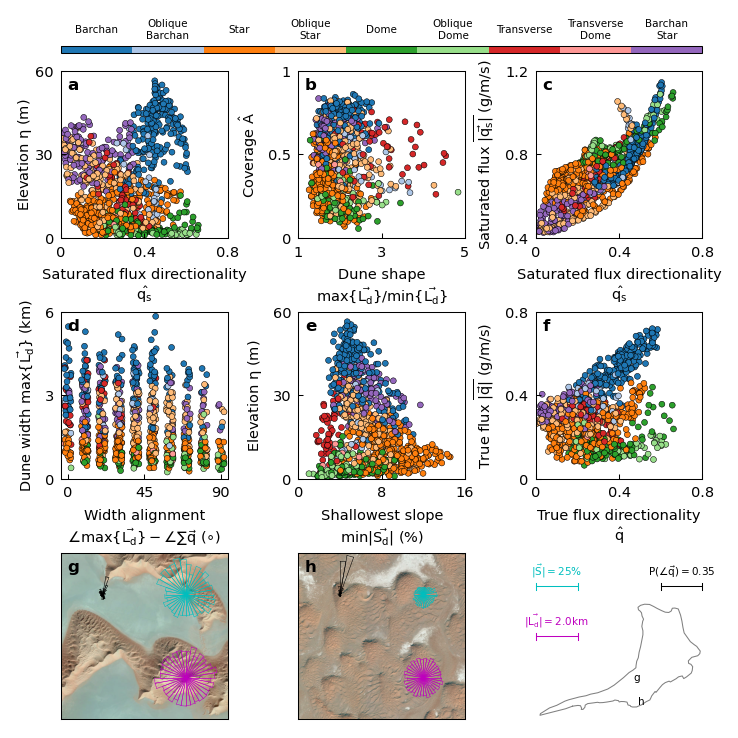

In [41]:
draft = False
polars = True

lw = 0.5
ss = 8

col1 = 'c'
col2 = 'm'
col3 = 'k'
slopemaxlim = 0.25
lengthmaxlim = 2000
qprobmaxlim = 0.35
tempadiff = np.diff(thetas)[0]/2

figw = 120
figh = 120
pltspan0 = 0.235
labbuf = 0.009
cbh = 0.01
buffw = 0.1
buffh = 0.105
cbuffh = 0.025
pltspan3 = pltspan0*0.5
pltspan1h = pltspan0/((np.max(templongrid)-np.min(templongrid))/(np.max(templatgrid)-np.min(templatgrid))/figw*figh)


ax1l,ax1b,ax1w,ax1h = 0.065,0.005,pltspan0,pltspan0
ax2l,ax2b,ax2w,ax2h = ax1l+pltspan0+buffw,ax1b,pltspan0,pltspan0
ax3l,ax3b,ax3w,ax3h = ax1l,ax1b+pltspan0+buffh,pltspan0,pltspan0
ax4l,ax4b,ax4w,ax4h = ax1l+pltspan0+buffw,ax1b+pltspan0+buffh,pltspan0,pltspan0
ax5l,ax5b,ax5w,ax5h = ax1l+2*(pltspan0+buffw),ax1b+pltspan0+buffh,pltspan0,pltspan0
ax6l,ax6b,ax6w,ax6h = ax1l,ax1b+2*(pltspan0+buffh),pltspan0,pltspan0
ax7l,ax7b,ax7w,ax7h = ax1l+pltspan0+buffw,ax1b+2*(pltspan0+buffh),pltspan0,pltspan0
ax8l,ax8b,ax8w,ax8h = ax1l+2*(pltspan0+buffw),ax1b+2*(pltspan0+buffh),pltspan0,pltspan0
cb1l,cb1b,cb1w,cb1h = ax1l,ax6b+pltspan0+cbuffh,2*(pltspan0+buffw)+pltspan0,cbh

ax0l,ax0b,ax0w,ax0h = ax1l+2*(pltspan0+buffw),ax1b,pltspan0,pltspan1h
ax10l,ax10b,ax10w,ax10h = ax1l+pltspan0/2,ax1b+pltspan0/2,pltspan3,pltspan3
ax11l,ax11b,ax11w,ax11h = ax1l+pltspan0/2,ax1b,pltspan3,pltspan3
ax12l,ax12b,ax12w,ax12h = ax1l,ax1b+pltspan0/2,pltspan3,pltspan3
ax20l,ax20b,ax20w,ax20h = ax2l+pltspan0/2,ax1b+pltspan0/2,pltspan3,pltspan3
ax21l,ax21b,ax21w,ax21h = ax2l+pltspan0/2,ax1b,pltspan3,pltspan3
ax22l,ax22b,ax22w,ax22h = ax2l,ax2b+pltspan0/2,pltspan3,pltspan3

fig = plt.gcf()

ax00 = fig.add_axes([0,0,1,1])
ax00.patch.set_alpha(0)
ax00.set_zorder(1)
if draft:
    plt.xticks([])
    plt.yticks([])
else:
    plt.axis('off')
ax00.text(ax1l+labbuf,ax1b+pltspan0-labbuf,'g',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax2l+labbuf,ax2b+pltspan0-labbuf,'h',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax3l+labbuf,ax3b+pltspan0-labbuf,'d',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax4l+labbuf,ax4b+pltspan0-labbuf,'e',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax5l+labbuf,ax5b+pltspan0-labbuf,'f',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax6l+labbuf,ax6b+pltspan0-labbuf,'a',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax7l+labbuf,ax7b+pltspan0-labbuf,'b',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax8l+labbuf,ax8b+pltspan0-labbuf,'c',fontsize=8, weight='bold',va='top',ha='left')

ax00.plot([ax0l,ax0l+ax20w/2],[ax1b+pltspan0*0.8,ax1b+pltspan0*0.8],lw=lw,c=col1)
ax00.plot([ax0l,ax0l],[ax1b+pltspan0*0.8-cbh/2,ax1b+pltspan0*0.8+cbh/2],lw=lw,c=col1)
ax00.plot([ax0l+ax20w/2,ax0l+ax20w/2],[ax1b+pltspan0*0.8-cbh/2,ax1b+pltspan0*0.8+cbh/2],lw=lw,c=col1)
ax00.text(ax0l+ax20w/4,ax1b+pltspan0*0.8+cbh,'$|\\vec{S}|=%d$%%'%(slopemaxlim*1e+2),color=col1,ha='center',va='bottom',fontsize=5)
ax00.plot([ax0l,ax0l+ax20w/2],[ax1b+pltspan0*0.5,ax1b+pltspan0*0.5],lw=lw,c=col2)
ax00.plot([ax0l,ax0l],[ax1b+pltspan0*0.5-cbh/2,ax1b+pltspan0*0.5+cbh/2],lw=lw,c=col2)
ax00.plot([ax0l+ax20w/2,ax0l+ax20w/2],[ax1b+pltspan0*0.5-cbh/2,ax1b+pltspan0*0.5+cbh/2],lw=lw,c=col2)
ax00.text(ax0l+ax20w/4,ax1b+pltspan0*0.5+cbh,'$|\\vec{L_d}|=%.1f km$'%(lengthmaxlim*1e-3),color=col2,ha='center',va='bottom',fontsize=5)
ax00.plot([ax0l+pltspan0-ax20w/2,ax0l+pltspan0],[ax1b+pltspan0*0.8,ax1b+pltspan0*0.8],lw=lw,c=col3)
ax00.plot([ax0l+pltspan0-ax20w/2,ax0l+pltspan0-ax20w/2],[ax1b+pltspan0*0.8-cbh/2,ax1b+pltspan0*0.8+cbh/2],lw=lw,c=col3)
ax00.plot([ax0l+pltspan0,ax0l+pltspan0],[ax1b+pltspan0*0.8-cbh/2,ax1b+pltspan0*0.8+cbh/2],lw=lw,c=col3)
ax00.text(ax0l+pltspan0-ax20w/4,ax1b+pltspan0*0.8+cbh,'$P(\\angle\\vec{q})=%.2f$'%qprobmaxlim,color=col3,ha='center',va='bottom',fontsize=5)
ax00.set_xlim(0,1)
ax00.set_ylim(0,1)

ax0 = fig.add_axes([ax0l,ax0b,ax0w,ax0h])
plt.plot(*dfpoly.exterior.xy,c='grey',lw=lw)
ax0.set_xlim(templongrid[0]-0.1,templongrid[-1]+0.1)
ax0.set_ylim(templatgrid[0]-0.1*((np.max(templongrid)-np.min(templongrid))/(np.max(templatgrid)-np.min(templatgrid))),templatgrid[-1]+0.1*((np.max(templongrid)-np.min(templongrid))/(np.max(templatgrid)-np.min(templatgrid))))

ax1 = fig.add_axes([ax1l,ax1b,ax1w,ax1h])
i,j = 18,44
img = mpimg.imread(directory+'figures/im198534_4km.png')
ax0.text(templongrid[j],templatgrid[i],'g',fontsize=5,va='center',ha='center')
plt.imshow(img)
plt.xticks([])
plt.yticks([])
if polars:
    ax10 = fig.add_axes([ax10l,ax10b,ax10w,ax10h],projection='polar')
    for k in range(len(thetas)):
        plt.plot([thetas[k]-tempadiff,thetas[k]+tempadiff],[lengthweightedslopetheta[i,j][k],lengthweightedslopetheta[i,j][k]],lw=lw*0.5,c=col1)
        plt.plot([thetas[k]-tempadiff,thetas[k]-tempadiff],[0,lengthweightedslopetheta[i,j][k]],lw=lw*0.5,c=col1)
        plt.plot([thetas[k]+tempadiff,thetas[k]+tempadiff],[0,lengthweightedslopetheta[i,j][k]],lw=lw*0.5,c=col1)    
    plt.ylim(0,slopemaxlim)
    ax11 = fig.add_axes([ax11l,ax11b,ax11w,ax11h],projection='polar')
    for k in range(len(thetas)):
        plt.plot([thetas[k]-tempadiff,thetas[k]+tempadiff],[bedformlengththeta[i,j][k],bedformlengththeta[i,j][k]],lw=lw*0.5,c=col2)
        plt.plot([thetas[k]-tempadiff,thetas[k]-tempadiff],[0,bedformlengththeta[i,j][k]],lw=lw*0.5,c=col2)
        plt.plot([thetas[k]+tempadiff,thetas[k]+tempadiff],[0,bedformlengththeta[i,j][k]],lw=lw*0.5,c=col2)    
    plt.ylim(0,lengthmaxlim)
    ax12 = fig.add_axes([ax12l,ax12b,ax12w,ax12h],projection='polar')
    tempaa = np.arctan2(qnyflat_slope[:,i,j],qnxflat_slope[:,i,j])
    temprr = (qnxflat_slope[:,i,j]**2+qnyflat_slope[:,i,j]**2)**0.5
    tempcc = np.empty(len(thetas))
    for i in range(len(thetas)):
        tempcc[i] = np.sum(temprr[(tempaa>thetas[i]-tempadiff)&(tempaa<=thetas[i]+tempadiff)])
    tempcc = tempcc/np.sum(tempcc)
    for i in range(len(thetas)):
        plt.plot([thetas[i]-tempadiff,thetas[i]+tempadiff],[tempcc[i],tempcc[i]],lw=lw*0.5,c=col3)
        plt.plot([thetas[i]-tempadiff,thetas[i]-tempadiff],[0,tempcc[i]],lw=lw*0.5,c=col3)
        plt.plot([thetas[i]+tempadiff,thetas[i]+tempadiff],[0,tempcc[i]],lw=lw*0.5,c=col3)
    plt.ylim(0,qprobmaxlim)

ax2 = fig.add_axes([ax2l,ax2b,ax2w,ax2h])
i,j = 7,46
img = mpimg.imread(directory+'figures/im187536_4km.png')
ax0.text(templongrid[j],templatgrid[i],'h',fontsize=5,va='center',ha='center')
plt.imshow(img)
plt.xticks([])
plt.yticks([])
if polars:
    ax20 = fig.add_axes([ax20l,ax20b,ax20w,ax20h],projection='polar')
    for k in range(len(thetas)):
        plt.plot([thetas[k]-tempadiff,thetas[k]+tempadiff],[lengthweightedslopetheta[i,j][k],lengthweightedslopetheta[i,j][k]],lw=lw*0.5,c=col1)
        plt.plot([thetas[k]-tempadiff,thetas[k]-tempadiff],[0,lengthweightedslopetheta[i,j][k]],lw=lw*0.5,c=col1)
        plt.plot([thetas[k]+tempadiff,thetas[k]+tempadiff],[0,lengthweightedslopetheta[i,j][k]],lw=lw*0.5,c=col1)    
    plt.ylim(0,slopemaxlim)
    ax21 = fig.add_axes([ax21l,ax21b,ax21w,ax21h],projection='polar')
    for k in range(len(thetas)):
        plt.plot([thetas[k]-tempadiff,thetas[k]+tempadiff],[bedformlengththeta[i,j][k],bedformlengththeta[i,j][k]],lw=lw*0.5,c=col2)
        plt.plot([thetas[k]-tempadiff,thetas[k]-tempadiff],[0,bedformlengththeta[i,j][k]],lw=lw*0.5,c=col2)
        plt.plot([thetas[k]+tempadiff,thetas[k]+tempadiff],[0,bedformlengththeta[i,j][k]],lw=lw*0.5,c=col2)    
    plt.ylim(0,lengthmaxlim)
    ax22 = fig.add_axes([ax22l,ax22b,ax22w,ax22h],projection='polar')
    tempaa = np.arctan2(qnyflat_slope[:,i,j],qnxflat_slope[:,i,j])
    temprr = (qnxflat_slope[:,i,j]**2+qnyflat_slope[:,i,j]**2)**0.5
    tempcc = np.empty(len(thetas))
    for i in range(len(thetas)):
        tempcc[i] = np.sum(temprr[(tempaa>thetas[i]-tempadiff)&(tempaa<=thetas[i]+tempadiff)])
    tempcc = tempcc/np.sum(tempcc)
    for i in range(len(thetas)):
        plt.plot([thetas[i]-tempadiff,thetas[i]+tempadiff],[tempcc[i],tempcc[i]],lw=lw*0.5,c=col3)
        plt.plot([thetas[i]-tempadiff,thetas[i]-tempadiff],[0,tempcc[i]],lw=lw*0.5,c=col3)
        plt.plot([thetas[i]+tempadiff,thetas[i]+tempadiff],[0,tempcc[i]],lw=lw*0.5,c=col3)
    plt.ylim(0,qprobmaxlim)

ax3 = fig.add_axes([ax3l,ax3b,ax3w,ax3h])
tempxx = np.ndarray.flatten(np.ndarray.flatten(sub90diffa_shortest_qnatotdir_slope+np.random.uniform(-2/180*np.pi,2/180*np.pi,np.shape(sub90diffa_shortest_qnatotdir_slope))))
tempyy = np.ndarray.flatten(np.max(bedformlengththeta,axis=2))
tempzz = np.ndarray.flatten(morph)
randinds = np.arange(len(tempxx))
np.random.shuffle(randinds)
p1 = plt.scatter(tempxx[randinds],tempyy[randinds]*1e-3,lw=lw*0.5,s=ss,c=tempzz[randinds],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,edgecolor='k')
ax3.set_ylim(0,6)
ax3.set_xlim(0-4/180*np.pi,np.pi/2+4/180*np.pi)
ax3.set_xticks([0,np.pi/4,np.pi/2])
ax3.set_xticklabels(['0','45','90'])
ax3.set_yticks([0,3,6])
ax3.set_yticklabels(['0','3','6'])
ax3.set_xlabel('Width alignment\n$\\angle\\max\{\\vec{L_d}\}-\\angle \\sum{\\vec{q}}$ ($\\circ$)')
ax3.set_ylabel('Dune width $\\max\{\\vec{L_d}\}$ (km)')

ax4 = fig.add_axes([ax4l,ax4b,ax4w,ax4h])
tempxx = np.ndarray.flatten(np.min(lengthweightedslopetheta,axis=2))
tempyy = np.ndarray.flatten(equivalentthickness)
tempzz = np.ndarray.flatten(morph)
randinds = np.arange(len(tempxx))
np.random.shuffle(randinds)
p1 = plt.scatter(tempxx[randinds]*1e+2,tempyy[randinds],lw=lw*0.5,s=ss,c=tempzz[randinds],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,edgecolor='k')
ax4.set_ylim(0,60)
ax4.set_xlim(0,16)
ax4.set_xticks([0,8,16])
ax4.set_xticklabels([0,8,16])
ax4.set_yticks([0,30,60])
ax4.set_yticklabels([0,30,60])
ax4.set_xlabel('Shallowest slope\n$\\min|\\vec{S_d}|$ (%)')
ax4.set_ylabel('Elevation $\\eta$ (m)')

ax5 = fig.add_axes([ax5l,ax5b,ax5w,ax5h])
tempxx = np.ndarray.flatten(qd_slope)
tempyy = np.ndarray.flatten(qamtot_slope)
tempzz = np.ndarray.flatten(morph)
randinds = np.arange(len(tempxx))
np.random.shuffle(randinds)
p1 = plt.scatter(tempxx[randinds],tempyy[randinds]*1e+3,lw=lw*0.5,s=ss,c=tempzz[randinds],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,edgecolor='k')
ax5.set_ylim(0,0.8)
ax5.set_xlim(0,0.8)
ax5.set_xticks([0,0.4,0.8])
ax5.set_xticklabels([0,0.4,0.8])
ax5.set_yticks([0,0.4,0.8])
ax5.set_yticklabels([0,0.4,0.8])
ax5.set_xlabel('True flux directionality\n$\\hat{q}$')
ax5.set_ylabel('True flux $\\overline{|\\vec{q}|}$ (g/m/s)')

ax6 = fig.add_axes([ax6l,ax6b,ax6w,ax6h])
tempxx = np.ndarray.flatten(qd)
tempyy = np.ndarray.flatten(equivalentthickness)
tempzz = np.ndarray.flatten(morph)
randinds = np.arange(len(tempxx))
np.random.shuffle(randinds)
p1 = plt.scatter(tempxx[randinds],tempyy[randinds],lw=lw*0.5,s=ss,c=tempzz[randinds],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,edgecolor='k')
ax6.set_ylim(0,60)
ax6.set_xlim(0,0.8)
ax6.set_xticks([0,0.4,0.8])
ax6.set_xticklabels([0,0.4,0.8])
ax6.set_yticks([0,30,60])
ax6.set_yticklabels([0,30,60])
ax6.set_xlabel('Saturated flux directionality\n$\\hat{q_s}$')
ax6.set_ylabel('Elevation $\\eta$ (m)',labelpad=0.5)

ax7 = fig.add_axes([ax7l,ax7b,ax7w,ax7h])
tempxx = np.ndarray.flatten(np.max(bedformlengththeta,axis=2)/np.min(bedformlengththeta,axis=2))
tempyy = np.ndarray.flatten(areafraction)
tempzz = np.ndarray.flatten(morph)
randinds = np.arange(len(tempxx))
np.random.shuffle(randinds)
p1 = plt.scatter(tempxx[randinds],tempyy[randinds],lw=lw*0.5,s=ss,c=tempzz[randinds],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,edgecolor='k')
ax7.set_ylim(0,1)
ax7.set_xlim(1,5)
ax7.set_xticks([1,3,5])
ax7.set_xticklabels([1,3,5])
ax7.set_yticks([0,0.5,1])
ax7.set_yticklabels([0,0.5,1])
ax7.set_xlabel('Dune shape\n$\\max\{\\vec{L_d}\}/\\min\{\\vec{L_d}\}$')
ax7.set_ylabel('Coverage $\\hat{A}$')

ax8 = fig.add_axes([ax8l,ax8b,ax8w,ax8h])
tempxx = np.ndarray.flatten(qd)
tempyy = np.ndarray.flatten(qamtot)
tempzz = np.ndarray.flatten(morph)
randinds = np.arange(len(tempxx))
np.random.shuffle(randinds)
p1 = plt.scatter(tempxx[randinds],tempyy[randinds]*1e+3,lw=lw*0.5,s=ss,c=tempzz[randinds],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,edgecolor='k')
ax8.set_ylim(0.4,1.2)
ax8.set_xlim(0,0.8)
ax8.set_xticks([0,0.4,0.8])
ax8.set_xticklabels([0,0.4,0.8])
ax8.set_yticks([0.4,0.8,1.2])
ax8.set_yticklabels([0.4,0.8,1.2])
ax8.set_xlabel('Saturated flux directionality\n$\\hat{q_s}$')
ax8.set_ylabel('Saturated flux $\\overline{|\\vec{q_s}|}$ (g/m/s)')

cbar1_ax = fig.add_axes([cb1l,cb1b,cb1w,cb1h])
cb1 = fig.colorbar(p1, orientation='horizontal',cax=cbar1_ax, ticks=np.arange(len(morphlist_abv)))
cbar1_ax.xaxis.set_label_position('top')
cbar1_ax.xaxis.set_ticks_position('top')
cb1.ax.set_xlabel('',labelpad=1)
cb1.ax.xaxis.set_tick_params(pad=8)
cb1.ax.set_xticklabels(morphlist,fontsize=5,va='center')

for ax in fig.axes:
    ax.tick_params(width=lw,length=lw*5,which='both',direction='in')
    ax.minorticks_off()
    if str(type(ax))=="<class 'matplotlib.projections.polar.PolarAxes'>":
        ax.axis('off')
    else:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(lw)
cb1.ax.tick_params(width=0,length=0,which='both',direction='in')
cb1.outline.set_linewidth(lw)
ax0.axis('off')

fig.set_size_inches(figw/25.4,figh/25.4,forward=True)
if draft==False:
    plt.savefig(directory+'figures/fig3.pdf',dpi=300)
    plt.savefig(directory+'figures/fig3.png',dpi=300)

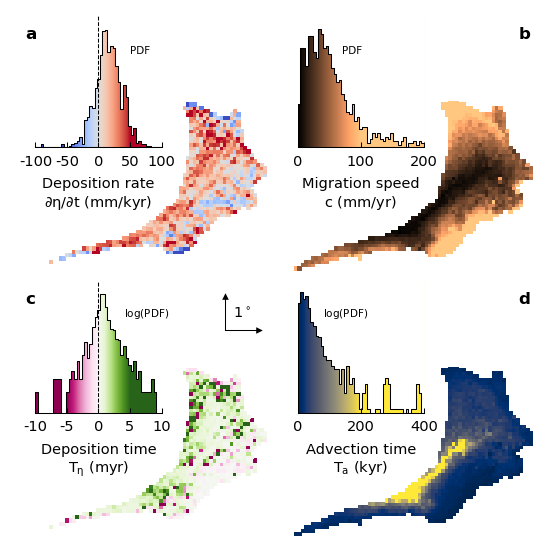

In [42]:
draft = False

lw = 0.5
ss = 10

figw = 89
figh = 89
cbw = 0.12
buffh = 0.18
buffw0 = 0.04
pltspan0h = 0.325
pltspan0w = pltspan0h*(np.max(templongrid)-np.min(templongrid))/(np.max(templatgrid)-np.min(templatgrid))/figw*figh
labbuf = 0.02
cbuffw = pltspan0w*0.15
cbuffh = pltspan0h*1.5
ax01h = 0.25
lweps = lw/72*25.4/figw/cbw

pdflim1min,pdflim1max = 1e-3,1e+0
pmin1,pmax1 = -1e+1,1e+1
cmin1,cmax1 = -5e+0,5e+0
ax11w = (pmax1-pmin1)/(cmax1-cmin1)*cbw
ax1l,ax1b,ax1w,ax1h = 0.03,0.005,pltspan0w,pltspan0h
ax11l,ax11b,ax11w,ax11h = ax1l+cbuffw+cbw/2-ax11w/2,ax1b+cbuffh-ax01h,ax11w,ax01h

pdflim2min,pdflim2max = 1e-4,4e-2
pmin2,pmax2 = 0,4e+2
cmin2,cmax2 = 0,2e+2
ax21w = (pmax2-pmin2)/(cmax2-cmin2)*cbw
ax2l,ax2b,ax2w,ax2h = ax1l+pltspan0w+buffw0,ax1b,pltspan0w,pltspan0h
ax21l,ax21b,ax21w,ax21h = ax2l+cbuffw+cbw/2-ax21w/2,ax2b+cbuffh-ax01h,ax21w,ax01h

pdflim3min,pdflim3max = 0,0.025
pmin3,pmax3 = -1e+2,1e+2
cmin3,cmax3 = -5e+1,5e+1
ax31w = (pmax3-pmin3)/(cmax3-cmin3)*cbw
ax3l,ax3b,ax3w,ax3h = ax1l,ax1b+pltspan0h+buffh,pltspan0w,pltspan0h
ax31l,ax31b,ax31w,ax31h = ax3l+cbuffw+cbw/2-ax31w/2,ax3b+cbuffh-ax01h,ax31w,ax01h

pdflim4min,pdflim4max = 0,0.016
pmin4,pmax4 = 0,2e+2
cmin4,cmax4 = 0,1e+2
ax41w = (pmax4-pmin4)/(cmax4-cmin4)*cbw
ax4l,ax4b,ax4w,ax4h = ax1l+pltspan0w+buffw0,ax1b+pltspan0h+buffh,pltspan0w,pltspan0h
ax41l,ax41b,ax41w,ax41h = ax4l+cbuffw+cbw/2-ax41w/2,ax4b+cbuffh-ax01h,ax41w,ax01h

fig = plt.gcf()

ax00 = fig.add_axes([0,0,1,1])
ax00.patch.set_alpha(0)
ax00.set_zorder(1)
if draft:
    plt.xticks([])
    plt.yticks([])
else:
    plt.axis('off')
ax00.text(labbuf,ax31b+ax31h-labbuf,'a',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(labbuf,ax11b+ax11h-labbuf,'c',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(1-labbuf,ax41b+ax41h-labbuf,'b',fontsize=8, weight='bold',va='top',ha='right')
ax00.text(1-labbuf,ax21b+ax21h-labbuf,'d',fontsize=8, weight='bold',va='top',ha='right')
ax00.text(ax21l+ax21w*0.2,ax21b+ax21h*0.7,'$\\log(PDF)$',fontsize=5, va='bottom',ha='left')
ax00.text(ax11l+ax11w*0.7,ax11b+ax11h*0.7,'$\\log(PDF)$',fontsize=5, va='bottom',ha='left')
ax00.text(ax31l+ax31w*0.75,ax31b+ax31h*0.7,'PDF',fontsize=5, va='bottom',ha='left')
ax00.text(ax41l+ax41w*0.35,ax41b+ax41h*0.7,'PDF',fontsize=5, va='bottom',ha='left')

ax00.plot([0.4,0.4+pltspan0w/(np.max(templongrid)-np.min(templongrid))],[0.4,0.4],c='k',lw=lw)
ax00.plot([0.4,0.4],[0.4,0.4+pltspan0h/(np.max(templatgrid)-np.min(templatgrid))],c='k',lw=lw)
ax00.scatter(0.4,0.4+pltspan0h/(np.max(templatgrid)-np.min(templatgrid)),c='k',lw=0,marker='^',s=ss)
ax00.scatter(0.4+pltspan0w/(np.max(templongrid)-np.min(templongrid)),0.4,c='k',lw=0,marker='>',s=ss)
ax00.text(0.4+pltspan0w/(np.max(templongrid)-np.min(templongrid))/2,0.4+pltspan0h/(np.max(templatgrid)-np.min(templatgrid))/2,'1$^\\circ$', va='center',ha='center')

ax00.set_xlim(0,1)
ax00.set_ylim(0,1)

ax3 = fig.add_axes([ax3l,ax3b,ax3w,ax3h])
p3 = plt.pcolor(templongrid[1:-1],templatgrid[1:-1],np.mean(detadt_slope,axis=(0,1))*mps_to_mmpyr*1e+3,cmap='coolwarm',vmin=cmin3,vmax=cmax3,rasterized=True)
ax3.set_xlim(templongrid[0],templongrid[-1])
ax3.set_ylim(templatgrid[0],templatgrid[-1])

cbar30_ax = fig.add_axes([ax31l+(ax31w-cbw)/2,ax31b,cbw,ax31h-lw/72*25.4/figw])
cb3 = fig.colorbar(p3, orientation='horizontal',cax=cbar30_ax, ticks=[cmin3,0,cmax3])
cbar31_ax = fig.add_axes([ax31l+(ax31w+cbw)/2,ax31b,(ax31w-cbw)/2,ax31h])
cbar31_ax.fill_between([0,1],[0,0],[1,1],color=plt.cm.coolwarm(256))
cbar31_ax.set_xlim(0,1+lweps*3)
cbar31_ax.set_ylim(0,1+lweps)
cbar32_ax = fig.add_axes([ax31l,ax31b,(ax31w-cbw)/2,ax31h])
cbar32_ax.fill_between([0,1],[0,0],[1,1],color=plt.cm.coolwarm(0))
cbar32_ax.set_xlim(0-lweps*3,1)
cbar32_ax.set_ylim(0,1+lweps)

ax31 = fig.add_axes([ax31l,ax31b,ax31w,ax31h])
ax31.patch.set_alpha(0)
tempxx = np.linspace(pmin3,pmax3,50)
tempcc,_ = np.histogram(np.mean(detadt_slope,axis=(0,1))*mps_to_mmpyr*1e+3,bins=tempxx,density=True)
ax31.fill_between(np.ndarray.flatten(np.vstack((tempxx,tempxx)).T)[1:-1],pdflim3max,np.ndarray.flatten(np.vstack((tempcc,tempcc)).T),lw=lw,fc=(1,1,1,1),ec=None)
ax31.fill_between(np.ndarray.flatten(np.vstack((tempxx,tempxx)).T)[1:-1],np.ndarray.flatten(np.vstack((tempcc,tempcc)).T),lw=lw,fc=(1,1,1,0),ec='k')
ax31.plot([0,0],[pdflim3min,pdflim3max],'--k',lw=lw)
ax31.set_ylim(pdflim3min,pdflim3max)
ax31.set_xlim(tempxx[0],tempxx[-1])
ax31.set_xticks([-100,-50,0,50,100])
ax31.set_xticklabels(['-100','-50','0','50','100'])
ax31.set_yticks([])
ax31.set_xlabel('Deposition rate\n$\\partial\\eta/\\partial t$ (mm/kyr)')

ax1 = fig.add_axes([ax1l,ax1b,ax1w,ax1h])
p1 = plt.pcolor(templongrid[1:-1],templatgrid[1:-1],Tz_slope/yr_to_s*1e-6,cmap='PiYG',vmin=cmin1,vmax=cmax1,rasterized=True)
ax1.set_xlim(templongrid[0],templongrid[-1])
ax1.set_ylim(templatgrid[0],templatgrid[-1])

cbar10_ax = fig.add_axes([ax11l+(ax11w-cbw)/2,ax11b,cbw,ax11h-lw/72*25.4/figw])
cb1 = fig.colorbar(p1, orientation='horizontal',cax=cbar10_ax, ticks=[cmin1,0,cmax1])
cbar11_ax = fig.add_axes([ax11l+(ax11w+cbw)/2,ax11b,(ax11w-cbw)/2,ax11h])
cbar11_ax.fill_between([0,1],[0,0],[1,1],color=plt.cm.PiYG(256))
cbar11_ax.set_xlim(0,1+lweps*3)
cbar11_ax.set_ylim(0,1+lweps)
cbar12_ax = fig.add_axes([ax11l,ax11b,(ax11w-cbw)/2,ax11h])
cbar12_ax.fill_between([0,1],[0,0],[1,1],color=plt.cm.PiYG(0))
cbar12_ax.set_xlim(0-lweps*3,1)
cbar12_ax.set_ylim(0,1+lweps)

ax11 = fig.add_axes([ax11l,ax11b,ax11w,ax11h])
ax11.patch.set_alpha(0)
tempxx = np.linspace(pmin1,pmax1,50)
tempcc,_ = np.histogram(Tz_slope/yr_to_s*1e-6,bins=tempxx,density=True)
ax11.fill_between(np.ndarray.flatten(np.vstack((tempxx,tempxx)).T)[1:-1],pdflim1max,np.ndarray.flatten(np.vstack((tempcc,tempcc)).T),lw=lw,fc=(1,1,1,1),ec=None)
ax11.fill_between(np.ndarray.flatten(np.vstack((tempxx,tempxx)).T)[1:-1],np.ndarray.flatten(np.vstack((tempcc,tempcc)).T),lw=lw,fc=(1,1,1,0),ec='k')
ax11.plot([0,0],[pdflim1min,pdflim1max],'--k',lw=lw)
plt.yscale('log')
ax11.set_ylim(pdflim1min,pdflim1max)
ax11.set_xlim(tempxx[0],tempxx[-1])
ax11.set_xticks([-10,-5,0,5,10])
ax11.set_xticklabels(['-10','-5','0','5','10'])
ax11.set_yticks([])
ax11.set_xlabel('Deposition time\n$T_\\eta$ (myr)')

ax2 = fig.add_axes([ax2l,ax2b,ax2w,ax2h])
p2 = plt.pcolor(templongrid,templatgrid,Tx_slope/yr_to_s*1e-3,cmap='cividis',vmin=cmin2,vmax=cmax2,rasterized=True)
ax2.set_xlim(templongrid[0],templongrid[-1])
ax2.set_ylim(templatgrid[0],templatgrid[-1])

cbar20_ax = fig.add_axes([ax21l+lw/72*25.4/figw/2,ax21b,cbw,ax21h-lw/72*25.4/figw])
cb2 = fig.colorbar(p2, orientation='horizontal',cax=cbar20_ax, ticks=[cmin2,cmax2])
cbar21_ax = fig.add_axes([ax21l+cbw,ax21b,ax21w-cbw,ax21h])
cbar21_ax.fill_between([0,1],[0,0],[1,1],color=plt.cm.cividis(256))
cbar21_ax.set_xlim(0,1+lweps)
cbar21_ax.set_ylim(0,1+lweps)

ax21 = fig.add_axes([ax21l,ax21b,ax21w,ax21h])
ax21.patch.set_alpha(0)
tempxx = np.linspace(pmin2,pmax2,50)
tempcc,_ = np.histogram(Tx_slope/yr_to_s*1e-3,bins=tempxx,density=True)
ax21.fill_between(np.ndarray.flatten(np.vstack((tempxx,tempxx)).T)[1:-1],pdflim2max,np.ndarray.flatten(np.vstack((tempcc,tempcc)).T),lw=lw,fc=(1,1,1,1),ec=None)
ax21.fill_between(np.ndarray.flatten(np.vstack((tempxx,tempxx)).T)[1:-1],np.ndarray.flatten(np.vstack((tempcc,tempcc)).T),lw=lw,fc=(1,1,1,0),ec='k')
plt.yscale('log')
ax21.set_ylim(pdflim2min,pdflim2max)
ax21.set_xlim(tempxx[0],tempxx[-1])
ax21.set_xticks([0,200,400])
ax21.set_xticklabels(['0','200','400'])
ax21.set_yticks([])
ax21.set_xlabel('Advection time\n$T_a$ (kyr)')

ax4 = fig.add_axes([ax4l,ax4b,ax4w,ax4h])
p4 = plt.pcolor(templongrid,templatgrid,migrationspeed_slope*mps_to_mmpyr,cmap='copper',vmin=cmin4,vmax=cmax4,rasterized=True)
ax4.set_xlim(templongrid[0],templongrid[-1])
ax4.set_ylim(templatgrid[0],templatgrid[-1])

cbar40_ax = fig.add_axes([ax41l+lw/72*25.4/figw/2,ax41b,cbw,ax41h-lw/72*25.4/figw])
cb4 = fig.colorbar(p4, orientation='horizontal',cax=cbar40_ax, ticks=[cmin4,cmax4])
cbar41_ax = fig.add_axes([ax41l+cbw,ax41b,ax41w-cbw,ax41h])
cbar41_ax.fill_between([0,1],[0,0],[1,1],color=plt.cm.copper(256))
cbar41_ax.set_xlim(0,1+lweps)
cbar41_ax.set_ylim(0,1+lweps)

ax41 = fig.add_axes([ax41l,ax41b,ax41w,ax41h])
ax41.patch.set_alpha(0)
tempxx = np.linspace(pmin4,pmax4,50)
tempcc,_ = np.histogram(migrationspeed_slope*mps_to_mmpyr,bins=tempxx,density=True)
ax41.fill_between(np.ndarray.flatten(np.vstack((tempxx,tempxx)).T)[1:-1],pdflim4max,np.ndarray.flatten(np.vstack((tempcc,tempcc)).T),lw=lw,fc=(1,1,1,1),ec=None)
ax41.fill_between(np.ndarray.flatten(np.vstack((tempxx,tempxx)).T)[1:-1],np.ndarray.flatten(np.vstack((tempcc,tempcc)).T),lw=lw,fc=(1,1,1,0),ec='k')
ax41.set_ylim(pdflim4min,pdflim4max)
ax41.set_xlim(tempxx[0],tempxx[-1])
ax41.set_xticks([0,100,200])
ax41.set_xticklabels(['0','100','200'])
ax41.set_yticks([])
ax41.set_xlabel('Migration speed\n$c$ (mm/yr)')

for ax in [ax1,cbar10_ax,cbar11_ax,cbar12_ax,
           ax2,cbar20_ax,cbar21_ax,
           ax3,cbar30_ax,cbar31_ax,cbar32_ax,
           ax4,cbar40_ax,cbar41_ax]:
    ax.axis('off')
for ax in [ax11,ax21,ax31,ax41]:
    ax.tick_params(width=lw,length=lw*5,which='both',direction='in')
    ax.minorticks_off()
    for axis in ['top','left','right']:
        ax.spines[axis].set_visible(False)
    ax.spines['bottom'].set_linewidth(lw)

fig.set_size_inches(figw/25.4,figh/25.4,forward=True)
if draft==False:
    plt.savefig(directory+'figures/fig2.pdf',dpi=300)
    plt.savefig(directory+'figures/fig2.png',dpi=300)

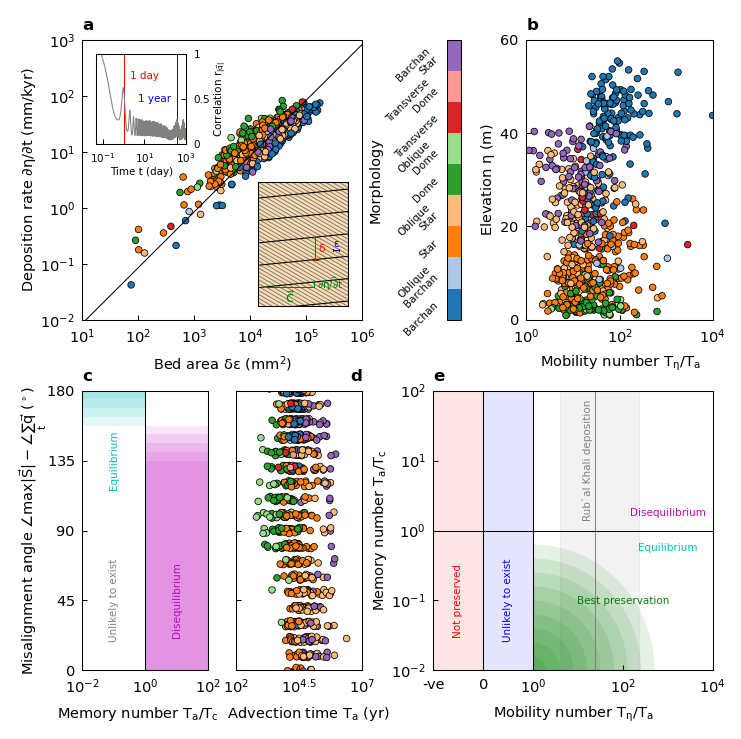

In [43]:
draft = False

lw = 0.5
ss = 10

ydiff = 0.5

pltspan = 0.395
insetscale0 = 0.32
insetscale1 = 0.32
buffw = 0.1
buffw0 = 0.04
buffh = 0.1
buff1 = 0.02
ax5spanx = 4
ax5spany = 5.5
cbw = 0.02
labbuf = 0.01

ax2l,ax2b,ax2w,ax2h = 0.095,0.075,pltspan/2-buffw0/2,pltspan
ax0l,ax0b,ax0w,ax0h = ax2l+pltspan+buffw,ax2b,pltspan,pltspan
ax1l,ax1b,ax1w,ax1h = ax2l+pltspan/2+buffw0/2,ax2b,pltspan/2-buffw0/2,pltspan
ax3l,ax3b,ax3w,ax3h = ax0l+pltspan/3,ax2b+pltspan+buffh,pltspan*2/3,pltspan
ax4l,ax4b,ax4w,ax4h = ax2l,ax2b+pltspan+buffh,pltspan,pltspan
ax5l,ax5b,ax5w,ax5h = ax4l+(1-insetscale1)*pltspan-buff1,ax4b+buff1,insetscale1*pltspan,insetscale1*pltspan*ax5spany/ax5spanx
ax6l,ax6b,ax6w,ax6h = ax4l+buff1,ax4b+(1-insetscale0)*pltspan-buff1,insetscale0*pltspan,insetscale0*pltspan
cb1l,cb1b,cb1w,cb1h = ax4l+pltspan+buffw+cbw,ax4b,cbw,pltspan

fig = plt.gcf()

ax00 = fig.add_axes([0,0,1,1])
ax00.patch.set_alpha(0)
ax00.set_zorder(1)
ax00.text(ax4l,ax4b+pltspan+labbuf,'a',fontsize=8, weight='bold',va='bottom',ha='left')
ax00.text(ax3l,ax3b+pltspan+labbuf,'b',fontsize=8, weight='bold',va='bottom',ha='left')
ax00.text(ax2l,ax2b+pltspan+labbuf,'c',fontsize=8, weight='bold',va='bottom',ha='left')
ax00.text(ax1l+ax1w,ax1b+pltspan+labbuf,'d',fontsize=8, weight='bold',va='bottom',ha='right')
ax00.text(ax0l,ax0b+pltspan+labbuf,'e',fontsize=8, weight='bold',va='bottom',ha='left')
if draft:
    plt.xticks([])
    plt.yticks([])
else:
    plt.axis('off')

ax0 = fig.add_axes([ax0l,ax0b,ax0w,ax0h])
plt.fill_betweenx([1e-2,1e+2],np.percentile(M_slope[M_slope>0],5),np.percentile(M_slope[M_slope>0],95),alpha=0.1,lw=lw,color='grey')
plt.plot([np.percentile(M_slope[M_slope>0],50),np.percentile(M_slope[M_slope>0],50)],[1e-2,1e+2],c='grey',lw=lw)
plt.fill_betweenx([1e-2,1e+2],-1,0,alpha=0.1,color='r',lw=0)
plt.fill_betweenx([1e-2,1e+2],0,1,alpha=0.1,color='b',lw=0)
plt.plot([-1,1e+4],[1,1],c='k',lw=lw)
plt.plot([0,0],[1e-2,1e+2],c='k',lw=lw)
plt.plot([1,1],[1e-2,1e+2],c='k',lw=lw)
plt.text(-0.5,10**-1,'Not preserved',color='r',ha='center',va='center',rotation='vertical',fontsize=5)
plt.text(0.5,10**-1,'Unlikely to exist',color='b',ha='center',va='center',rotation='vertical',fontsize=5)
plt.text(1e+2,10**-1,'Best preservation',color='g',ha='center',va='center',fontsize=5)
plt.text(1e+3,10**-0.25,'Equilibrium',color='c',ha='center',va='center',fontsize=5)
plt.text(1e+3,10**0.25,'Disequilibrium',color='m',ha='center',va='center',fontsize=5)
plt.text(np.percentile(M_slope[M_slope>0],50)*0.9,1e+1,'Rub`al Khali deposition',color='grey',ha='right',va='center',rotation='vertical',fontsize=5)
temptt = np.linspace(0,np.pi/2)
temprr = np.linspace(0.2,2,10)
tempxx = temprr[:,None]*np.cos(temptt[None,:])
tempyy = temprr[:,None]*np.sin(temptt[None,:])
for i in range(len(temprr)-1):
    plt.fill_between(10**(1.5*tempxx[i]),10**(tempyy[i]-2),alpha=0.1,color='g',lw=0)
plt.xscale('symlog', linthresh=1)
plt.yscale('log')
plt.xlim(-1,1e+4)
plt.ylim(1e-2,1e+2)
ax0.set_xticks([-1,0,1e+0,1e+2,1e+4])
ax0.set_xticklabels(['-ve','$0$','$10^0$','$10^2$','$10^{4}$ '])
ax0.set_yticks([1e-2,1e-1,1e+0,1e+1,1e+2])
ax0.set_yticklabels(['$10^{-2}$','$10^{-1}$','$10^{0}$','$10^{1}$','$10^{2}$'])
ax0.set_xlabel('Mobility number $T_\\eta/T_a$')
ax0.set_ylabel('Memory number $T_a/T_c$',labelpad=1)


ax2 = fig.add_axes([ax2l,ax2b,ax2w,ax2h])
plt.plot([0,0],[-1,1],c='k',lw=lw)
tempyy = np.linspace(0.75,1,5)
for i in range(len(tempyy)):
    plt.fill_between([-1,0],tempyy[i],1,alpha=0.1,color='c',lw=0)
tempyy = np.linspace(0.5,0.75,5)
for i in range(len(tempyy)):
    plt.fill_between([0,1],-1,tempyy[i],alpha=0.1,color='m',lw=0)
plt.text(-0.5,-0.5,'Unlikely to exist',color='grey',ha='center',va='center',rotation='vertical',fontsize=5)
plt.text(-0.5,0.5,'Equilibrium',color='c',ha='center',va='center',rotation='vertical',fontsize=5)
plt.text(0.5,-0.5,'Disequilibrium',color='m',ha='center',va='center',rotation='vertical',fontsize=5)
ax2.set_xlim(-1,1)
ax2.set_ylim(-1,1)
ax2.set_xticks([-1,0,1])
ax2.set_yticks([-1,-0.5,0,0.5,1])
ax2.set_ylabel('Misalignment angle $\\angle\\max|\\vec{S}|-\\angle \\sum_t{\\vec{q}}$ ($^\\circ$)',labelpad=-1.5)
ax2.set_xlabel('Memory number $T_a/T_c$    ')
ax2.set_xticklabels(['$10^{-2}$','$10^{0}$','$10^{2}$'])
ax2.set_yticklabels(['$0$','$45$','$90$','$135$','$180$'])


ax1 = fig.add_axes([ax1l,ax1b,ax1w,ax1h])
tempxx = np.ndarray.flatten(Tx_slope/yr_to_s)
tempyy = np.ndarray.flatten(sub180diffa_steepest_qnatotdir_slope+np.random.uniform(-2/180*np.pi,2/180*np.pi,np.shape(sub180diffa_steepest_qnatotdir_slope)))
tempzz = np.ndarray.flatten(morph)
randinds = np.arange(len(tempxx))
np.random.shuffle(randinds)
p1 = plt.scatter(tempxx[randinds],tempyy[randinds],lw=lw*0.75,s=ss,c=tempzz[randinds],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,edgecolor='k')
plt.xscale('log')
ax1.set_ylim(0,np.pi)
ax1.set_xlim(1e+2,1e+7)
ax1.set_xticks([1e+2,10**4.5,1e+7])
ax1.set_xticklabels(['$10^{2}$','$10^{4.5}$','$10^{7}$'])
ax1.set_yticks([0,np.pi/4,np.pi/2,np.pi*3/4,np.pi])
ax1.set_yticklabels(['','','','',''])
ax1.set_xlabel('    Advection time $T_a$ (yr)')


ax3 = fig.add_axes([ax3l,ax3b,ax3w,ax3h])
tempxx = np.ndarray.flatten(M_slope)
tempyy = np.ndarray.flatten(equivalentthickness[1:-1,1:-1])
tempzz = np.ndarray.flatten(morph[1:-1,1:-1])
randinds = np.arange(len(tempxx))
np.random.shuffle(randinds)
plt.scatter(tempxx[randinds],tempyy[randinds],lw=lw*0.75,s=ss,c=tempzz[randinds],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,edgecolor='k')
plt.xscale('log')
plt.xlim(1e+0,1e+4)
plt.ylim(0,60)
ax3.set_xticks([1e+0,1e+2,1e+4])
ax3.set_xticklabels(['$10^0$','$10^2$','$10^{4}$ '])
ax3.set_yticks([0,20,40,60])
ax3.set_yticklabels(['$0$','$20$','$40$','$60$'])
ax3.set_xlabel('Mobility number $T_\\eta/T_a$')
ax3.set_ylabel('Elevation $\\eta$ (m)',labelpad=1)

ax4 = fig.add_axes([ax4l,ax4b,ax4w,ax4h])
tempxx = np.ndarray.flatten(setthickness_slope*crossbedwidth_slope[1:-1,1:-1]*1e+6)
tempyy = np.ndarray.flatten(np.mean(detadt_slope,axis=(0,1))*mps_to_mmpyr*1e+3)
tempzz = np.ndarray.flatten(morph[1:-1,1:-1])
randinds = np.arange(len(tempxx))
np.random.shuffle(randinds)
plt.scatter(tempxx[randinds],tempyy[randinds],lw=lw*0.75,s=ss,c=tempzz[randinds],vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,edgecolor='k')
plt.plot([0,1*1e+6],[0,1*1/yr_to_s/np.nanmean(bedformlength_qnatotdir_slope)*mps_to_mmpyr*1e+3],c='k',lw=lw)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e+1,1e+6)
plt.ylim(1e-2,1e+3)
ax4.set_xticks([1e+1,1e+2,1e+3,1e+4,1e+5,1e+6])
ax4.set_xticklabels(['$10^1$','$10^2$','$10^3$','$10^4$','$10^5$','$10^6$'])
ax4.set_yticks([1e-2,1e-1,1e+0,1e+1,1e+2,1e+3])
ax4.set_yticklabels(['$10^{-2}$','$10^{-1}$','$10^0$','$10^1$','$10^2$','$10^3$'])
ax4.set_xlabel('Bed area $\\delta\\epsilon$ (mm$^2$)')
ax4.set_ylabel('Deposition rate $\\partial\\eta/\\partial t$ (mm/kyr)',labelpad=1)


ax5 = fig.add_axes([ax5l,ax5b,ax5w,ax5h])
for i in range(nsets):
    for j in range(nbeds):
        plt.plot(tempbedsx[i,j],tempbedsy[i,j],c='grey',lw=lw)
for i in range(nsets):
    plt.plot(tempx,tempsets[i],c='k',lw=lw)
width = tempdel/4
i = 2
k = int(nx*0.73)
plt.plot([tempx[k],tempx[k]],[tempsets[i,k],tempsets[i,k]+tempdel],c='r',lw=lw)
plt.plot([tempx[k]-width/2,tempx[k]+width/2],[tempsets[i,k],tempsets[i,k]],c='r',lw=lw)
plt.plot([tempx[k]-width/2,tempx[k]+width/2],[tempsets[i,k]+tempdel,tempsets[i,k]+tempdel],c='r',lw=lw)
plt.text(tempx[k]+width/2,tempsets[i,k]+tempdel/2,'$\\delta$',color='r',ha='left',va='center',fontsize=5)
width = tempeps/4
i = 3
j = 21
k = int(nx*0.5)
plt.plot([tempbedsx[i,j,k],tempbedsx[i,j,k]+tempeps],[tempbedsy[i,j,k],tempbedsy[i,j,k]],c='b',lw=lw)
plt.plot([tempbedsx[i,j,k],tempbedsx[i,j,k]],[tempbedsy[i,j,k]-width/2,tempbedsy[i,j,k]+width/2],c='b',lw=lw)
plt.plot([tempbedsx[i,j,k]+tempeps,tempbedsx[i,j,k]+tempeps],[tempbedsy[i,j,k]-width/2,tempbedsy[i,j,k]+width/2],c='b',lw=lw)
plt.text(tempbedsx[i,j,k]+tempeps/2,tempbedsy[i,j,k]+width/2,'$\\epsilon$',color='b',ha='center',va='bottom',fontsize=5)
i = 1
k = int(nx*0.64)
scale = 7
width = tempdel/4
plt.plot([tempx[k],tempx[k]+scale*tempc],[tempsets[i,k],tempsets[i,k]],c='g',lw=lw)
plt.plot([tempx[k]+scale*tempc,tempx[k]+scale*tempc],[tempsets[i,k],tempsets[i,k]+scale*tempdetadt],c='g',lw=lw)
plt.text(tempx[k]+scale*tempc/2,tempsets[i,k]-width/2,'$\\vec{c}$',color='g',ha='center',va='top')
plt.text(tempx[k]+scale*tempc+width/2,tempsets[i,k]+scale*tempdetadt/2,'$\\vec{\\partial\\eta/\\partial t}$',color='g',ha='left',va='center',fontsize=5)
plt.axis('square')
ax5.set_xlim(3,3+ax5spanx)
ax5.set_ylim(0.5,0.5+ax5spany)
ax5.set_xticks([])
ax5.set_yticks([])
ax5.set_facecolor('navajowhite')

ax6 = fig.add_axes([ax6l,ax6b,ax6w,ax6h])
plt.plot([1,1],[0,1],c='r',lw=lw)
plt.text(1*2,0.75,'1 day',color='r',ha='left',va='center',fontsize=5)
plt.plot([365,365],[0,1],c='b',lw=lw)
plt.text(365/2,0.5,'1 year',color='b',ha='right',va='center',fontsize=5)
plt.plot(qm_store_time/60/60/24,qm_store_autocorr.real,c='grey',lw=lw)
plt.xscale('log')
ax6.set_xlim(5e-2,1e+3)
ax6.set_ylim(0,1)
ax6.set_xticks([1e-1,1e+1,1e+3])
ax6.set_xticklabels(['$10^{-1}$','$10^1$','$10^3$'],fontsize=5)
ax6.set_yticks([0,0.5,1])
ax6.set_yticklabels(['0','0.5','1'],fontsize=5)
ax6.set_xlabel('Time t (day)',labelpad=1,fontsize=5)
ax6.set_ylabel('Correlation $r_{|\\vec{q}|}$',labelpad=1,fontsize=5)
ax6.yaxis.set_label_position("right")
ax6.yaxis.tick_right()

cbar1_ax = fig.add_axes([cb1l,cb1b,cb1w,cb1h])
cb1 = fig.colorbar(p1, orientation='vertical',cax=cbar1_ax, ticks=np.arange(len(morphlist_abv)))
cbar1_ax.yaxis.set_label_position('left')
cbar1_ax.yaxis.set_ticks_position('left')
cb1.ax.set_ylabel('Morphology',labelpad=1)
cb1.ax.set_yticklabels(morphlist,rotation=45,fontsize=5)

for ax in fig.axes:
    ax.tick_params(width=lw,length=lw*5,which='both',direction='in')
    ax.minorticks_off()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(lw)
cb1.ax.tick_params(width=0,length=0,which='both',direction='in')
cb1.outline.set_linewidth(lw)

fig.set_size_inches(120/25.4,120/25.4,forward=True)
if draft==False:
    plt.savefig(directory+'figures/fig4.pdf',dpi=300)
    plt.savefig(directory+'figures/fig4.png',dpi=300)

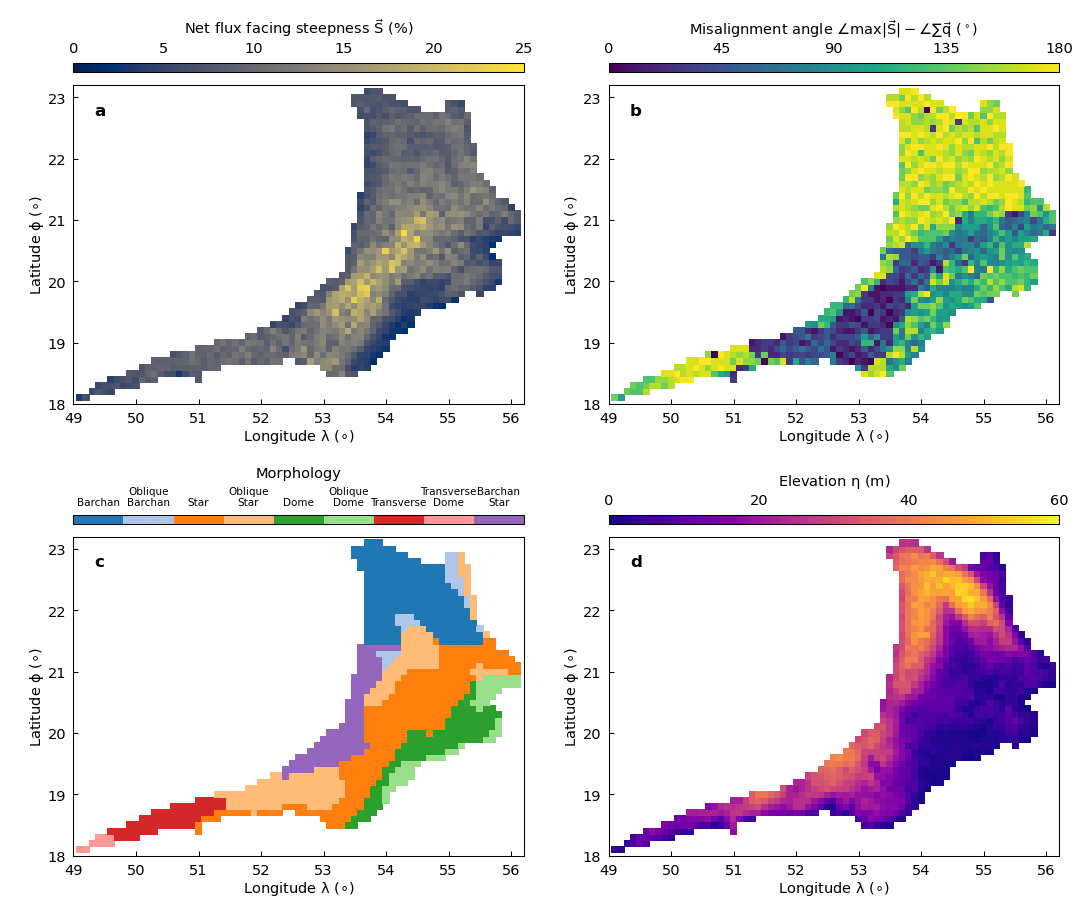

In [67]:
draft = False

lw = 0.5
ss = 10

figw = 180
figh = 150
buffh = 0.15
buffw = 0.08
pltspan0h = 0.36
pltspan0w = pltspan0h*(np.max(templongrid)-np.min(templongrid))/(np.max(templatgrid)-np.min(templatgrid))/figw*figh
labbuf = 0.02
cbw = pltspan0w*1
cbh = 0.01
cbuffh = buffh*0.1

ax0l,ax0b,ax0w,ax0h = 0.055,0.05,pltspan0w,pltspan0h
ax1l,ax1b,ax1w,ax1h = ax0l+pltspan0w+buffw,ax0b,pltspan0w,pltspan0h
ax2l,ax2b,ax2w,ax2h = ax0l,ax0b+pltspan0h+buffh,pltspan0w,pltspan0h
ax3l,ax3b,ax3w,ax3h = ax0l+pltspan0w+buffw,ax0b+pltspan0h+buffh,pltspan0w,pltspan0h

cb0l,cb0b,cb0w,cb0h = ax0l+pltspan0w/2-cbw/2,ax0b+pltspan0h+cbuffh,cbw,cbh
cb1l,cb1b,cb1w,cb1h = ax1l+pltspan0w/2-cbw/2,ax1b+pltspan0h+cbuffh,cbw,cbh
cb2l,cb2b,cb2w,cb2h = ax2l+pltspan0w/2-cbw/2,ax2b+pltspan0h+cbuffh,cbw,cbh
cb3l,cb3b,cb3w,cb3h = ax3l+pltspan0w/2-cbw/2,ax3b+pltspan0h+cbuffh,cbw,cbh

fig = plt.gcf()

ax00 = fig.add_axes([0,0,1,1])
ax00.patch.set_alpha(0)
ax00.set_zorder(1)
if draft:
    plt.xticks([])
    plt.yticks([])
else:
    plt.axis('off')
ax00.text(ax0l+labbuf,ax0b+pltspan0h-labbuf,'c',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax1l+labbuf,ax1b+pltspan0h-labbuf,'d',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax2l+labbuf,ax2b+pltspan0h-labbuf,'a',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax3l+labbuf,ax3b+pltspan0h-labbuf,'b',fontsize=8, weight='bold',va='top',ha='left')

ax00.set_xlim(0,1)
ax00.set_ylim(0,1)

ax0 = fig.add_axes([ax0l,ax0b,ax0w,ax0h])
p0 = plt.pcolor(templongrid,templatgrid,morph,vmin=-0.5,vmax=len(morphlist_abv)-0.5,cmap=tab9,rasterized=True)
ax0.set_xlim(templongrid[0],templongrid[-1])
ax0.set_ylim(templatgrid[0],templatgrid[-1]+0.1)
ax0.set_xlabel('Longitude $\\lambda$ ($\\circ$)',labelpad=1)
ax0.set_ylabel('Latitude $\\phi$ ($\\circ$)',labelpad=1)

ax1 = fig.add_axes([ax1l,ax1b,ax1w,ax1h])
p1 = plt.pcolor(templongrid,templatgrid,equivalentthickness,vmin=0,vmax=60,cmap='plasma',rasterized=True)
ax1.set_xlim(templongrid[0],templongrid[-1])
ax1.set_ylim(templatgrid[0],templatgrid[-1]+0.1)
ax1.set_xlabel('Longitude $\\lambda$ ($\\circ$)',labelpad=1)
ax1.set_ylabel('Latitude $\\phi$ ($\\circ$)',labelpad=1)

ax2 = fig.add_axes([ax2l,ax2b,ax2w,ax2h])
p2 = plt.pcolor(templongrid,templatgrid,lengthweightedslope_qnatotdir_slope*1e+2,vmin=0,vmax=25,cmap='cividis',rasterized=True)
ax2.set_xlim(templongrid[0],templongrid[-1])
ax2.set_ylim(templatgrid[0],templatgrid[-1]+0.1)
ax2.set_xlabel('Longitude $\\lambda$ ($\\circ$)',labelpad=1)
ax2.set_ylabel('Latitude $\\phi$ ($\\circ$)',labelpad=1)

ax3 = fig.add_axes([ax3l,ax3b,ax3w,ax3h])
p3 = plt.pcolor(templongrid,templatgrid,sub180diffa_steepest_qnatotdir_slope*180/np.pi,vmin=0,vmax=180,cmap='viridis',rasterized=True)
ax3.set_xlim(templongrid[0],templongrid[-1])
ax3.set_ylim(templatgrid[0],templatgrid[-1]+0.1)
ax3.set_xlabel('Longitude $\\lambda$ ($\\circ$)',labelpad=1)
ax3.set_ylabel('Latitude $\\phi$ ($\\circ$)',labelpad=1)

cbar0_ax = fig.add_axes([cb0l,cb0b,cb0w,cb0h])
cb0 = fig.colorbar(p0, orientation='horizontal',cax=cbar0_ax, ticks=np.arange(len(morphlist_abv)))
cbar0_ax.xaxis.set_label_position('top')
cbar0_ax.xaxis.set_ticks_position('top')
cb0.ax.set_xlabel('Morphology')
cb0.ax.set_xticklabels(morphlist,fontsize=5,ha='center',va='bottom')

cbar1_ax = fig.add_axes([cb1l,cb1b,cb1w,cb1h])
cb1 = fig.colorbar(p1, orientation='horizontal',cax=cbar1_ax, ticks=[0,20,40,60])
cbar1_ax.xaxis.set_label_position('top')
cbar1_ax.xaxis.set_ticks_position('top')
cb1.ax.set_xlabel('Elevation $\\eta$ (m)')
cb1.ax.set_xticklabels([0,20,40,60])

cbar2_ax = fig.add_axes([cb2l,cb2b,cb2w,cb2h])
cb2 = fig.colorbar(p2, orientation='horizontal',cax=cbar2_ax, ticks=[0,5,10,15,20,25])
cbar2_ax.xaxis.set_label_position('top')
cbar2_ax.xaxis.set_ticks_position('top')
cb2.ax.set_xlabel('Net flux facing steepness $\\vec{S}$ (%)')
cb2.ax.set_xticklabels([0,5,10,15,20,25])

cbar3_ax = fig.add_axes([cb3l,cb3b,cb3w,cb3h])
cb3 = fig.colorbar(p3, orientation='horizontal',cax=cbar3_ax, ticks=[0,45,90,135,180])
cbar3_ax.xaxis.set_label_position('top')
cbar3_ax.xaxis.set_ticks_position('top')
cb3.ax.set_xlabel('Misalignment angle $\\angle\\max|\\vec{S}|-\\angle \\sum{\\vec{q}}$ ($^\\circ$)')
cb3.ax.set_xticklabels([0,45,90,135,180])

for ax in fig.axes:
    ax.tick_params(width=lw,length=lw*5,which='both',direction='in')
    ax.minorticks_off()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(lw)
cb0.ax.tick_params(width=0,length=0,which='both',direction='in')
cb0.outline.set_linewidth(lw)
cb1.ax.tick_params(width=0,length=0,which='both',direction='in')
cb1.outline.set_linewidth(lw)
cb2.ax.tick_params(width=0,length=0,which='both',direction='in')
cb2.outline.set_linewidth(lw)
cb3.ax.tick_params(width=0,length=0,which='both',direction='in')
cb3.outline.set_linewidth(lw)

fig.set_size_inches(figw/25.4,figh/25.4,forward=True)
if draft==False:
    plt.savefig(directory+'figures/figS2.pdf',dpi=300)
    plt.savefig(directory+'figures/figS2.png',dpi=300)